In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from spec_id import *
from sim_engine import *
from spec_stats import Highest_density_region, Linear_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from prospect.models.transforms import logsfr_ratios_to_masses
from time import time
import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# Examine fits

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


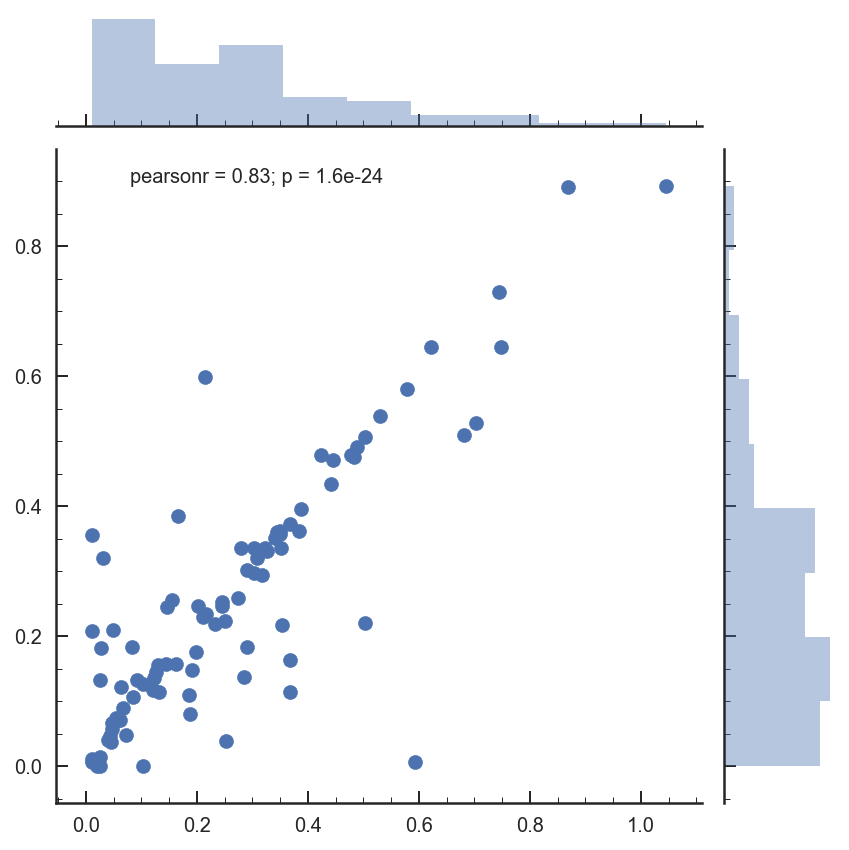

In [281]:
tlist = glob('../data/posteriors/G*tabfit_Pd.*')
dlist = glob('../data/posteriors/G*delayfit_Pd.*')

tval = np.zeros(len(tlist))
dval = np.zeros(len(dlist))

for i in range(len(tlist)):
    t,pt = np.load(tlist[i])
    d,pd = np.load(dlist[i])
    dval[i] = d[pd == max(pd)][0]
    tval[i] = t[pt == max(pt)][0]


sea.jointplot(dval,tval)


0.44642920320246726
-0.1897001203333506


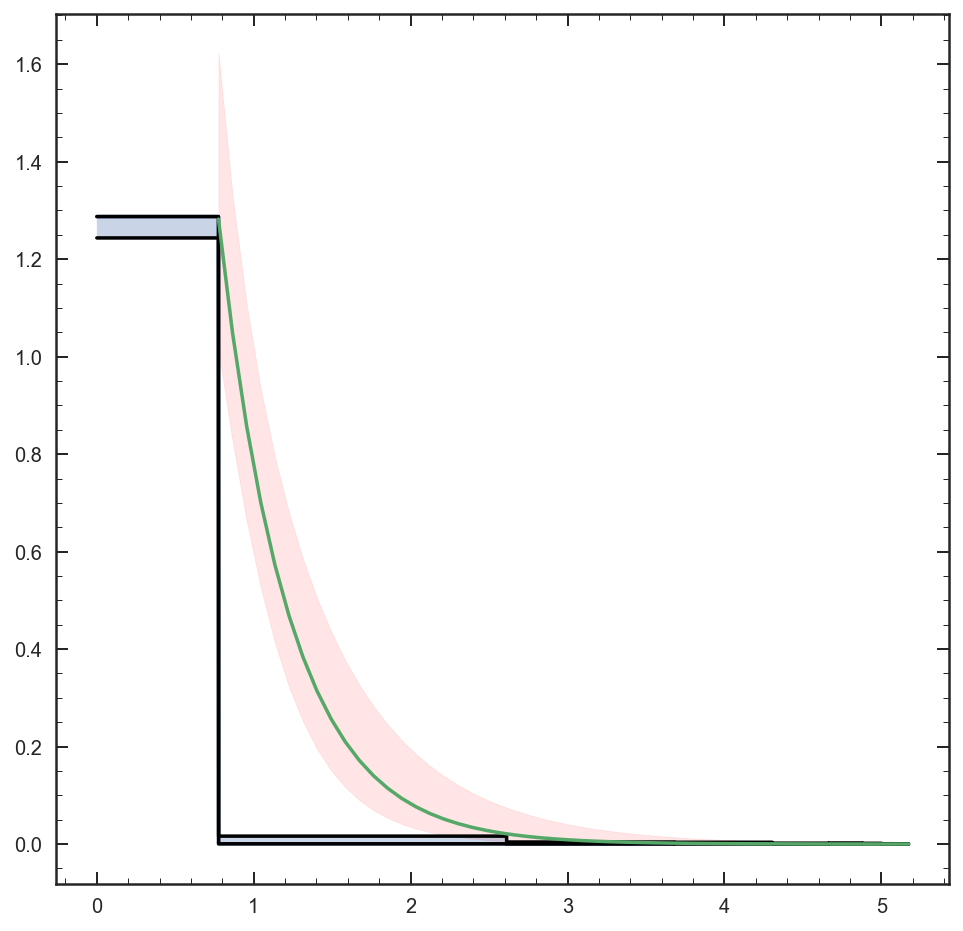

In [55]:
plt.figure(figsize = [8,8])
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GSD_39170_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GSD_39170_tabfit_Pa.npy')
a,ale,ahe = Highest_density_region(px,x)

time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

y_vals = np.zeros(10)
y_errs = np.zeros(10)
x_vals = np.zeros(10)

for i in range(len(time)//2):    
    y_vals[i] = np.log(sfr[i*2 +1])
    y_errs[i] = (np.log(sfr_l[i*2 +1])  + np.log(sfr_h[i*2 +1])) / 2
    x_vals[i] = time[i*2 +1]
    
newx = np.linspace(x_vals[0],x_vals[-1])
lfit, lfiterr= Linear_fit(x_vals, y_vals, y_errs,newx)

print(-1/((lfit[1] - lfit[0]) / (newx[1] - newx[0])))
print(-1/((lfiterr[1] + lfiterr[0]) / (newx[1] - newx[0])))

plt.plot(time,sfr)
plt.plot(time,sfr_l,'k')
plt.plot(time,sfr_h,'k')
plt.plot(newx,np.exp(lfit))
plt.fill_between(newx,np.exp(lfit - lfiterr),np.exp(lfit + lfiterr), alpha=0.1, color='r')

plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)

# x,px = np.load('../data/posteriors/GND_21156_delayfit_Pt.npy')
# tau, taul, tauh = Highest_density_region(px,x)

# x,px = np.load('../data/posteriors/GND_21156_delayfit_Pa.npy')
# a,ale,ahe = Highest_density_region(px,x)
# print(tau)
# t = np.arange(0,a,0.01)
# sfr = t*np.exp( -t / tau) / np.trapz(t*np.exp( -t / tau),t)
# sfrl = t*np.exp( -t /(tau - taul)) / np.trapz(t*np.exp( -t /(tau - taul)),t)
# sfrh = t*np.exp( -t / (tau + tauh)) /  np.trapz(t*np.exp( -t / (tau + tauh)),t)

# plt.plot(t,sfr)
# plt.plot(t,sfrl,'r')
# plt.plot(t,sfrh,'r')

# plt.fill_between(t,sfrl, sfrh, alpha = 0.3)


In [75]:
np.trapz(sfr,time)


1.0010115191236908

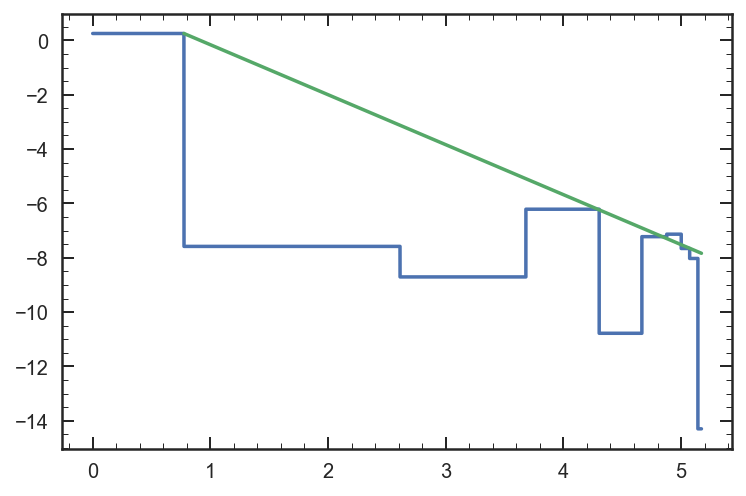

In [74]:
plt.plot(time,np.log(sfr))
# plt.plot(time,np.log(sfr_l),'k')
# plt.plot(time,np.log(sfr_h),'k')
plt.plot(newx,lfit)

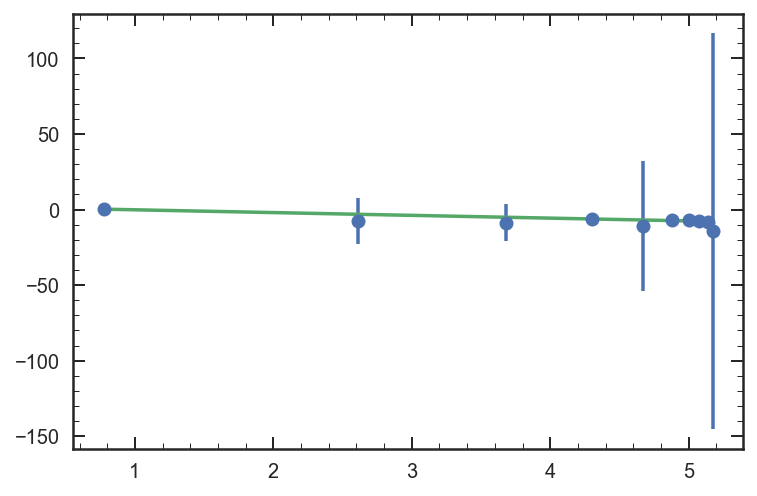

In [72]:
y_vals = np.zeros(10)
y_errsl = np.zeros(10)
y_errsh = np.zeros(10)
x_vals = np.zeros(10)

for i in range(len(time)//2):    
    y_vals[i] = np.log(sfr[i*2 +1])
    y_errs[i] = ((sfr_h[i*2 +1] - sfr_l[i*2 +1]) / 2) / sfr[i*2 +1]
    y_errsl[i] = np.log(sfr[i*2 +1]) - np.log(sfr_l[i*2 +1])
    y_errsh[i] = np.log(sfr_h[i*2 +1]) - np.log(sfr[i*2 +1])
    x_vals[i] = time[i*2 +1]
    
newx = np.linspace(x_vals[0],x_vals[-1])
lfit, lfiterr= Linear_fit(x_vals, y_vals, y_errs,newx)

# plt.plot(newx,np.exp(lfit))
# plt.fill_between(newx,np.exp(lfit - lfiterr),np.exp(lfit + lfiterr), alpha=0.1)

# plt.errorbar(x_vals, y_vals, [y_errsl,y_errsh],fmt='o')
plt.errorbar(x_vals, y_vals, y_errs,fmt='o')

plt.plot(newx,lfit)

In [73]:
y_vals[0],y_errsl[0],y_errsh[0], y_errs

(0.2526623204271697,
 0.03467268284781208,
 0.0,
 array([1.70392364e-02, 1.54926492e+01, 1.21933619e+01, 9.09682842e-01,
        4.30609026e+01, 1.35029972e+00, 6.80918749e-01, 4.60029475e-01,
        5.52242875e-01, 1.30800169e+02]))

In [195]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

def PLOT(field, galaxy, savefig = False):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    
    
    Gs = Gen_spec(field, galaxy, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.05, irac_err = 0.1, decontam = True) 

    Gs.Sim_all_premade(wave*(1+z),flux)
    
    gcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [bp1,rp1], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])
    
    gs = GridSpec(2,4, hspace=0.3, wspace = 0.3)   

    plt.figure(figsize=[16,10])
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / gcal[0],Gs.Ber*1E18 / gcal[0],
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  gcal[1],Gs.Rer*1E18 / gcal[1],
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)
    
    plt.subplot(gs[0,3])
    plt.plot(time,sfr)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(Z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pm.npy'.format(field, galaxy))
    
    plt.subplot(gs[1,0])
    plt.plot(z,pz)
    plt.xlabel('Z / Z$_\odot$', fontsize=15)
    plt.ylabel('P(Z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(lwa)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(field, galaxy))

    plt.subplot(gs[1,1])
    plt.plot(z,pz)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('P(lwa)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
    
    plt.subplot(gs[1,2])
    plt.plot(z,pz)
    plt.xlabel('redshift', fontsize=15)
    plt.ylabel('P(z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(d)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pd.npy'.format(field, galaxy))
    
    plt.subplot(gs[1,3])
    plt.plot(z,pz)
    plt.xlabel('Av', fontsize=15)
    plt.ylabel('P(Av)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    
    if savefig:
#         plt.savefig('../plots/ALMA/all_data_{0}.png'.format(galaxy),bbox_inches = 'tight')

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


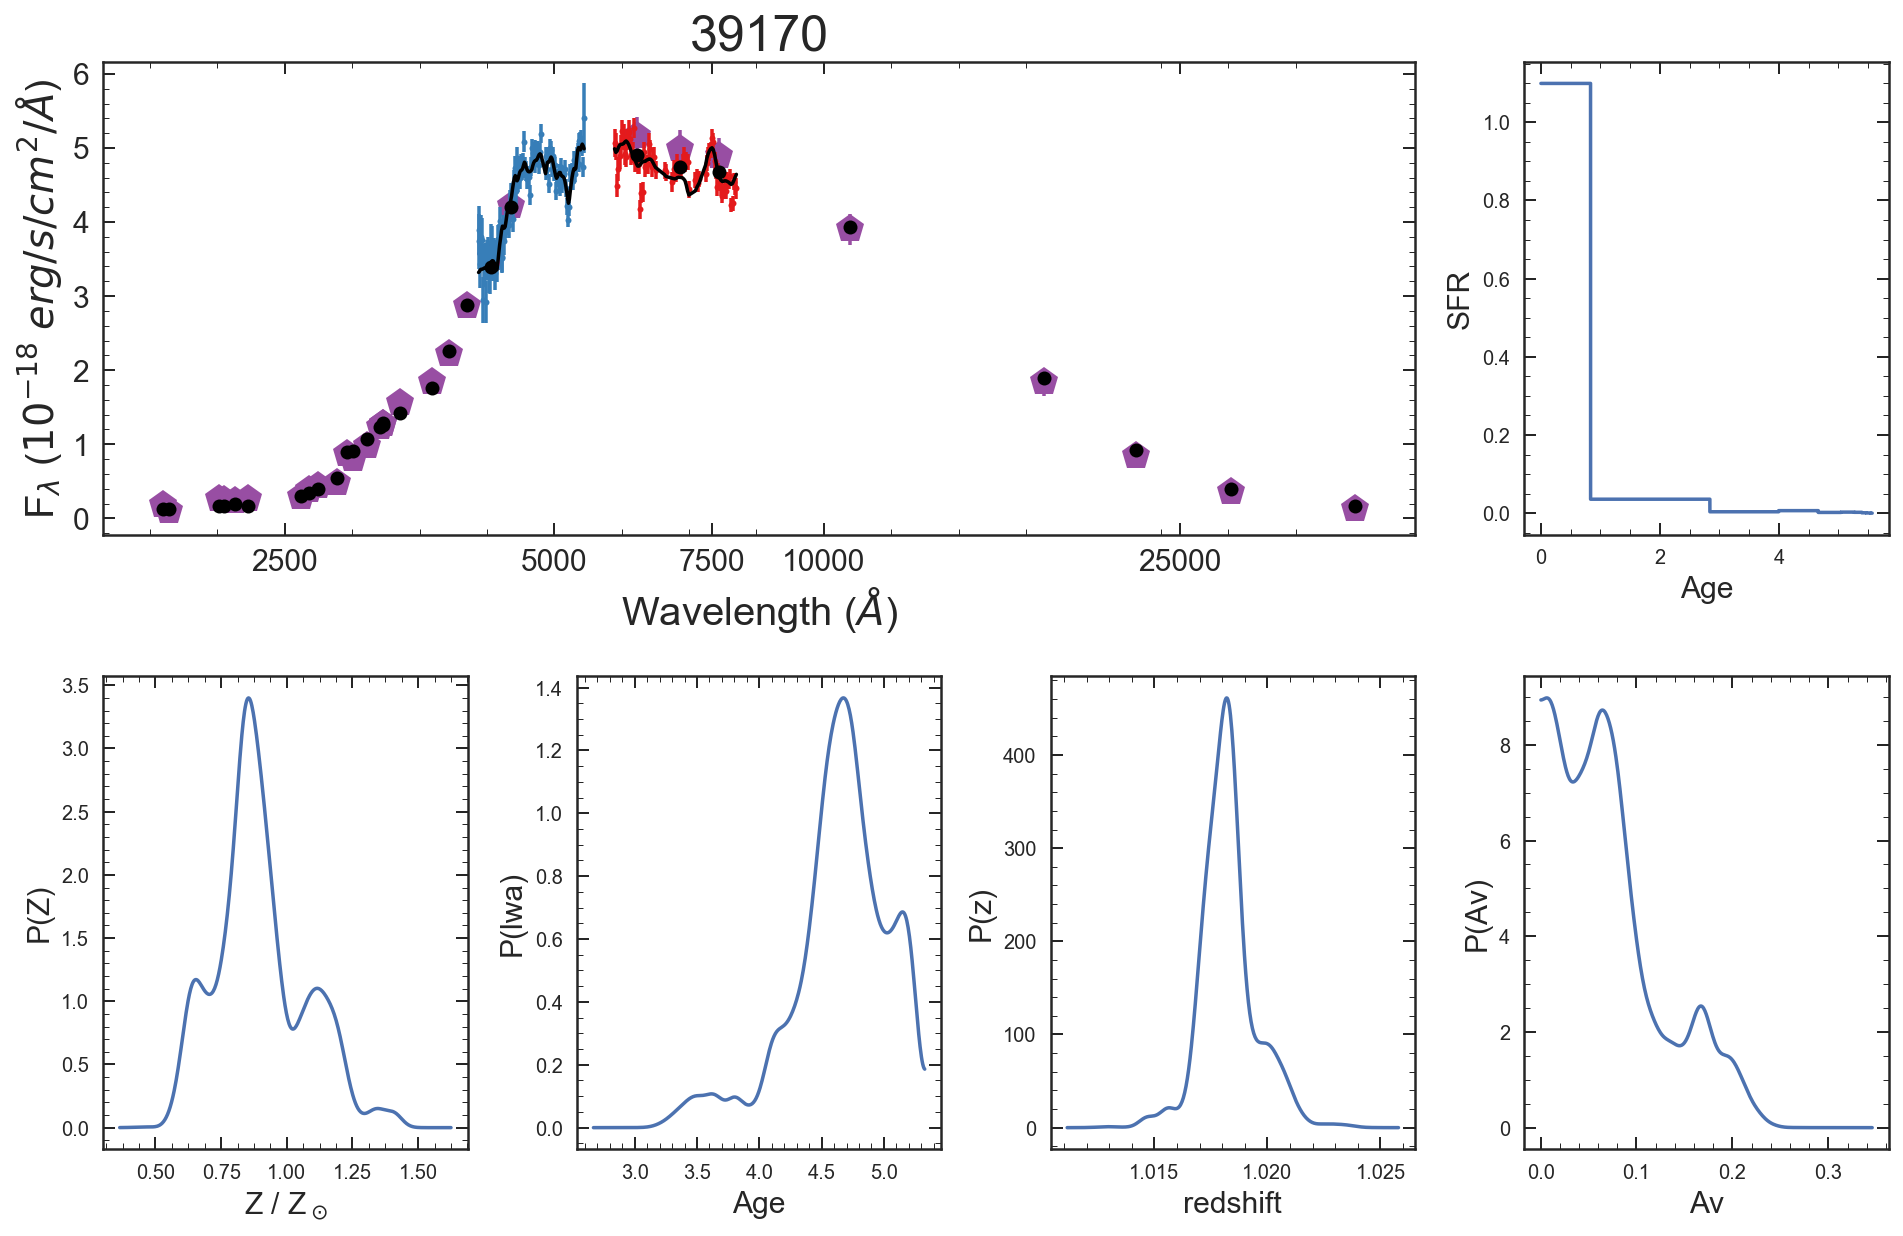

In [196]:
PLOT('GSD', 39170)

## Sample from posteriors

In [217]:
def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x)

In [218]:
ppf_dict = {}
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'z', 'd', 'bp1', 'rp1']

for i in params:
    x,px = np.load('../data/posteriors/GND_21156_tabfit_P{0}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)
    

In [237]:
x,px = np.load('../data/posteriors/GND_21156_tabfit_Pz.npy')
x[px == px.max()]

array([1.25290146])

In [239]:
Gs = Gen_spec('GND', 21156, 1.2529, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False, phot_errterm = 0.05, irac_err = 0.1, decontam = True) 


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [244]:
params[14]

'bp1'

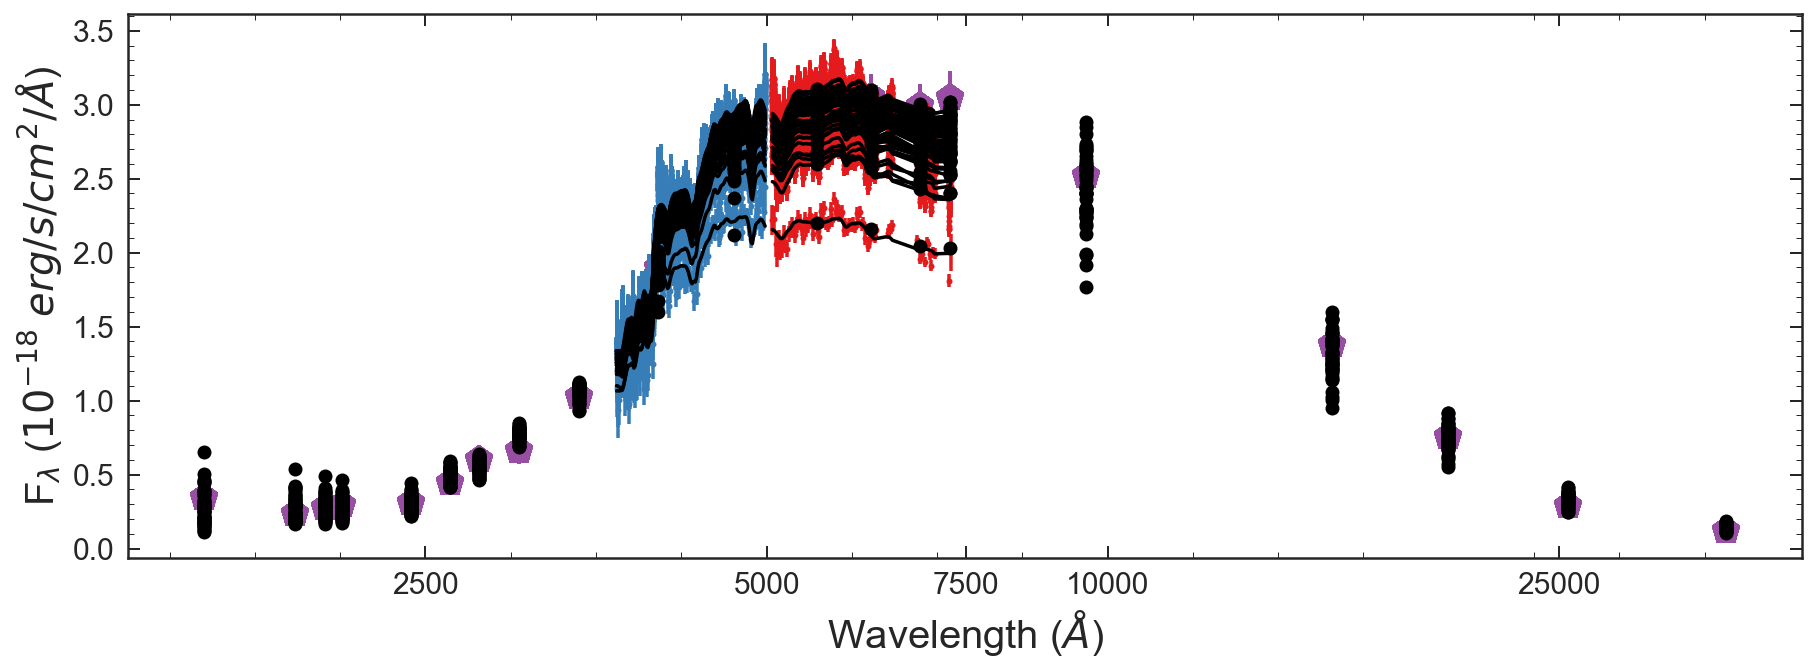

In [249]:

plt.figure(figsize=[15,5])

for u in range(50):
    draw = np.zeros(len(params))

    for i in range(len(draw)):
        draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

    sp.params['dust2'] = draw[13]
    sp.params['dust1'] = draw[13]
    sp.params['logzsol'] = np.log10(draw[0])

    time, sfr, tmax = convert_sfh(get_agebins(draw[1]), draw[2:12], maxage = draw[1]*1E9)

    sp.set_tabular_sfh(time,sfr)    

    wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)    

    Gs.Sim_all_premade(wave*( 1 + draw[12]),flux)
    
#     gcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [draw[14],draw[15]], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])
    
    gs = GridSpec(2,4, hspace=0.3, wspace = 0.3)   

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 ,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

## examine different errrates

In [ ]:
ls ../data/bestfits/GND_21156_tabfit_1_bfit.npy

In [260]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

def PLOT(version, errterm, savefig = False):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/GND_21156_tabfit_{0}_bfit.npy'.format(version))
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    
    
    Gs = Gen_spec('GND', 21156, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = errterm, irac_err = 2*errterm, decontam = True) 

    Gs.Sim_all_premade(wave*(1+z),flux)
    
    gcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [bp1,rp1], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])
    
    gs = GridSpec(2,4, hspace=0.3, wspace = 0.3)   

    plt.figure(figsize=[16,10])
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / gcal[0],Gs.Ber*1E18 / gcal[0],
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  gcal[1],Gs.Rer*1E18 / gcal[1],
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(errterm, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)
    
    plt.subplot(gs[0,3])
    plt.plot(time,sfr)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(Z)################
    z,pz = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pm.npy'.format(version))
    
    plt.subplot(gs[1,0])
    plt.plot(z,pz)
    plt.xlabel('Z / Z$_\odot$', fontsize=15)
    plt.ylabel('P(Z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(lwa)################
    z,pz = np.load('../data/posteriors/GND_21156_tabfit_{0}_Plwa.npy'.format(version))

    plt.subplot(gs[1,1])
    plt.plot(z,pz)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('P(lwa)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(z)################
    z,pz = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pz.npy'.format(version))
    
    plt.subplot(gs[1,2])
    plt.plot(z,pz)
    plt.xlabel('redshift', fontsize=15)
    plt.ylabel('P(z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(d)################
    z,pz = np.load('../data/posteriors/GND_21156_tabfit_{0}_Pd.npy'.format(version))
    
    plt.subplot(gs[1,3])
    plt.plot(z,pz)
    plt.xlabel('Av', fontsize=15)
    plt.ylabel('P(Av)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    
    if savefig:
        plt.savefig('../plots/err_test/v{0}_e{1}.png'.format(version,errterm),bbox_inches = 'tight')

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


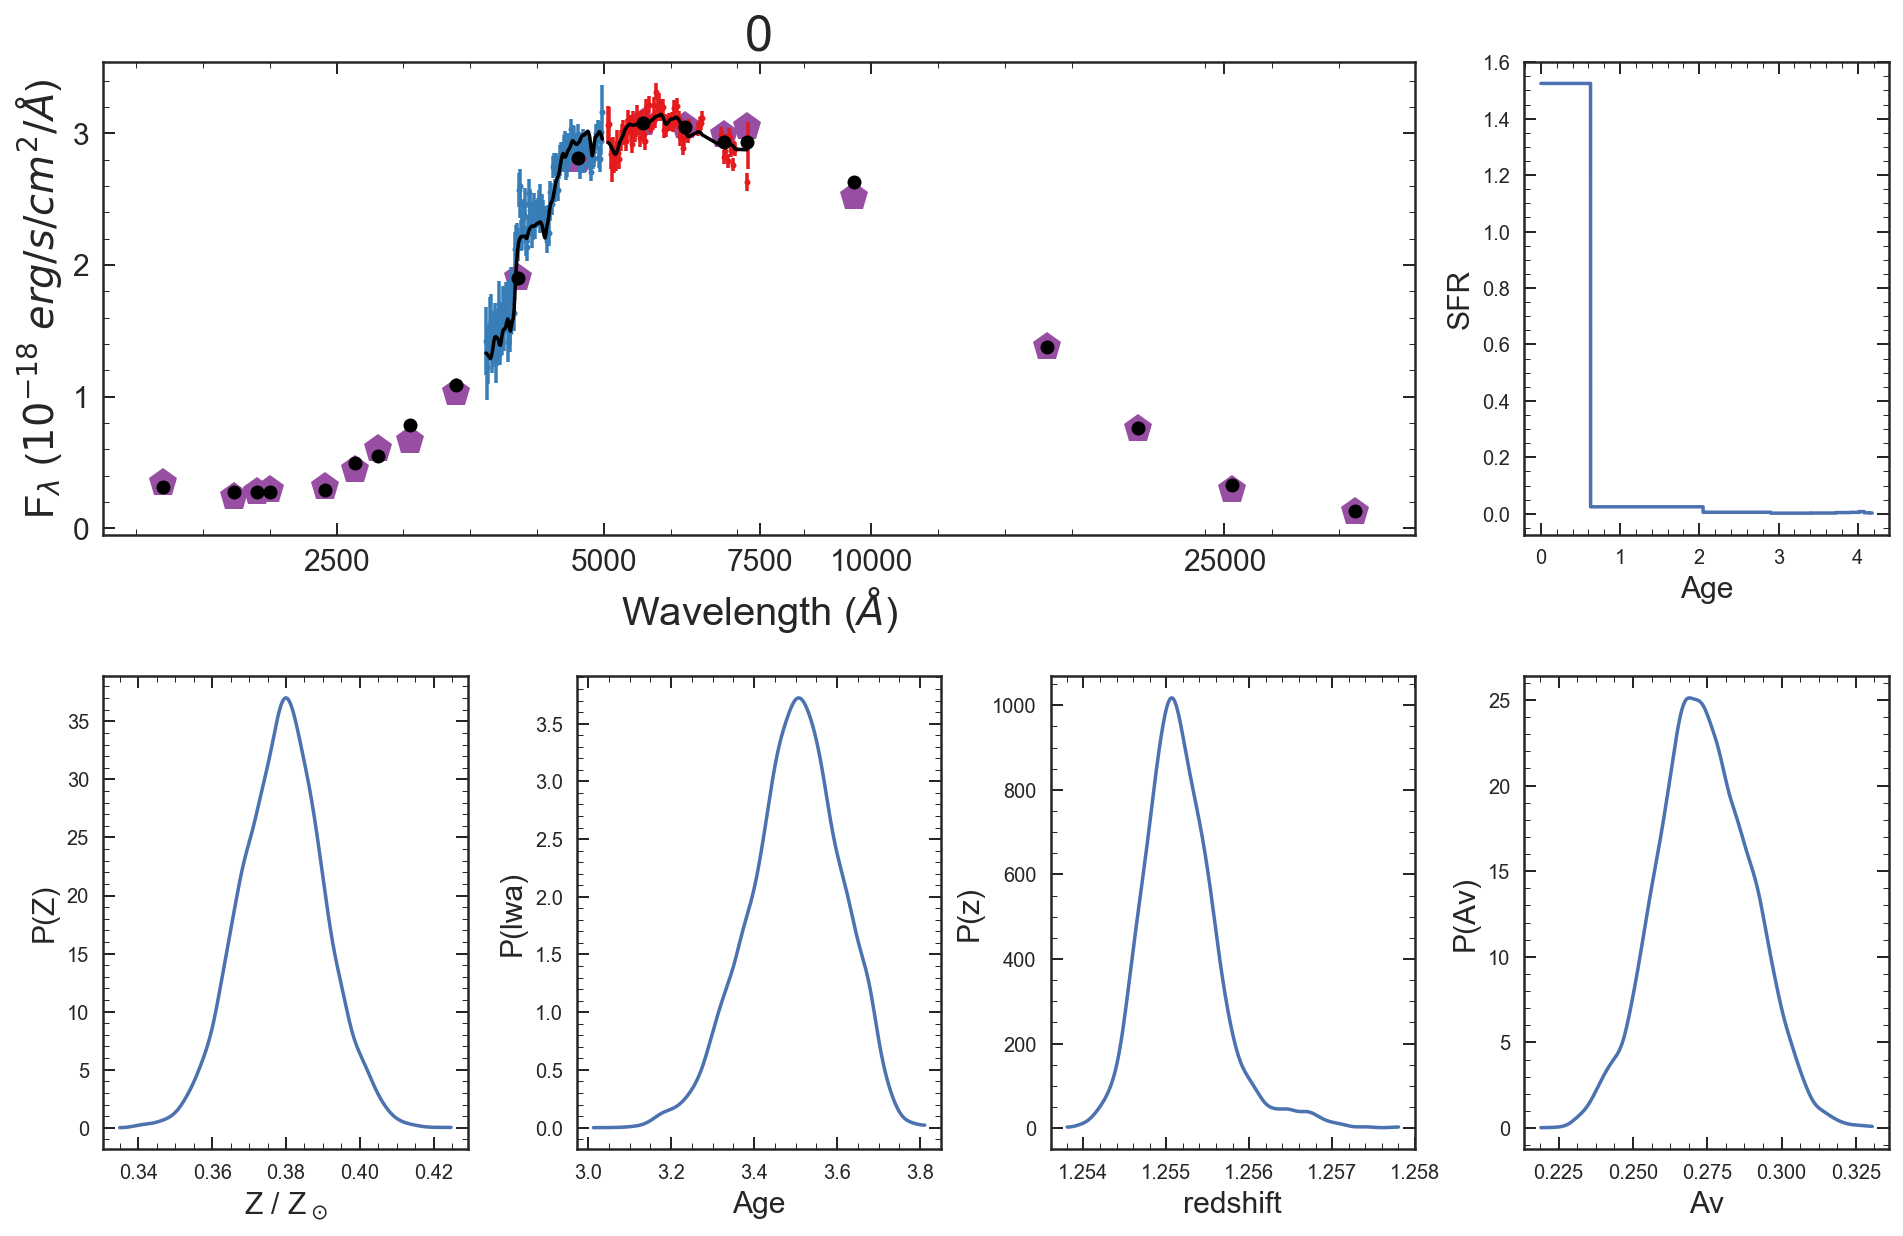

In [253]:
PLOT(1,0)

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


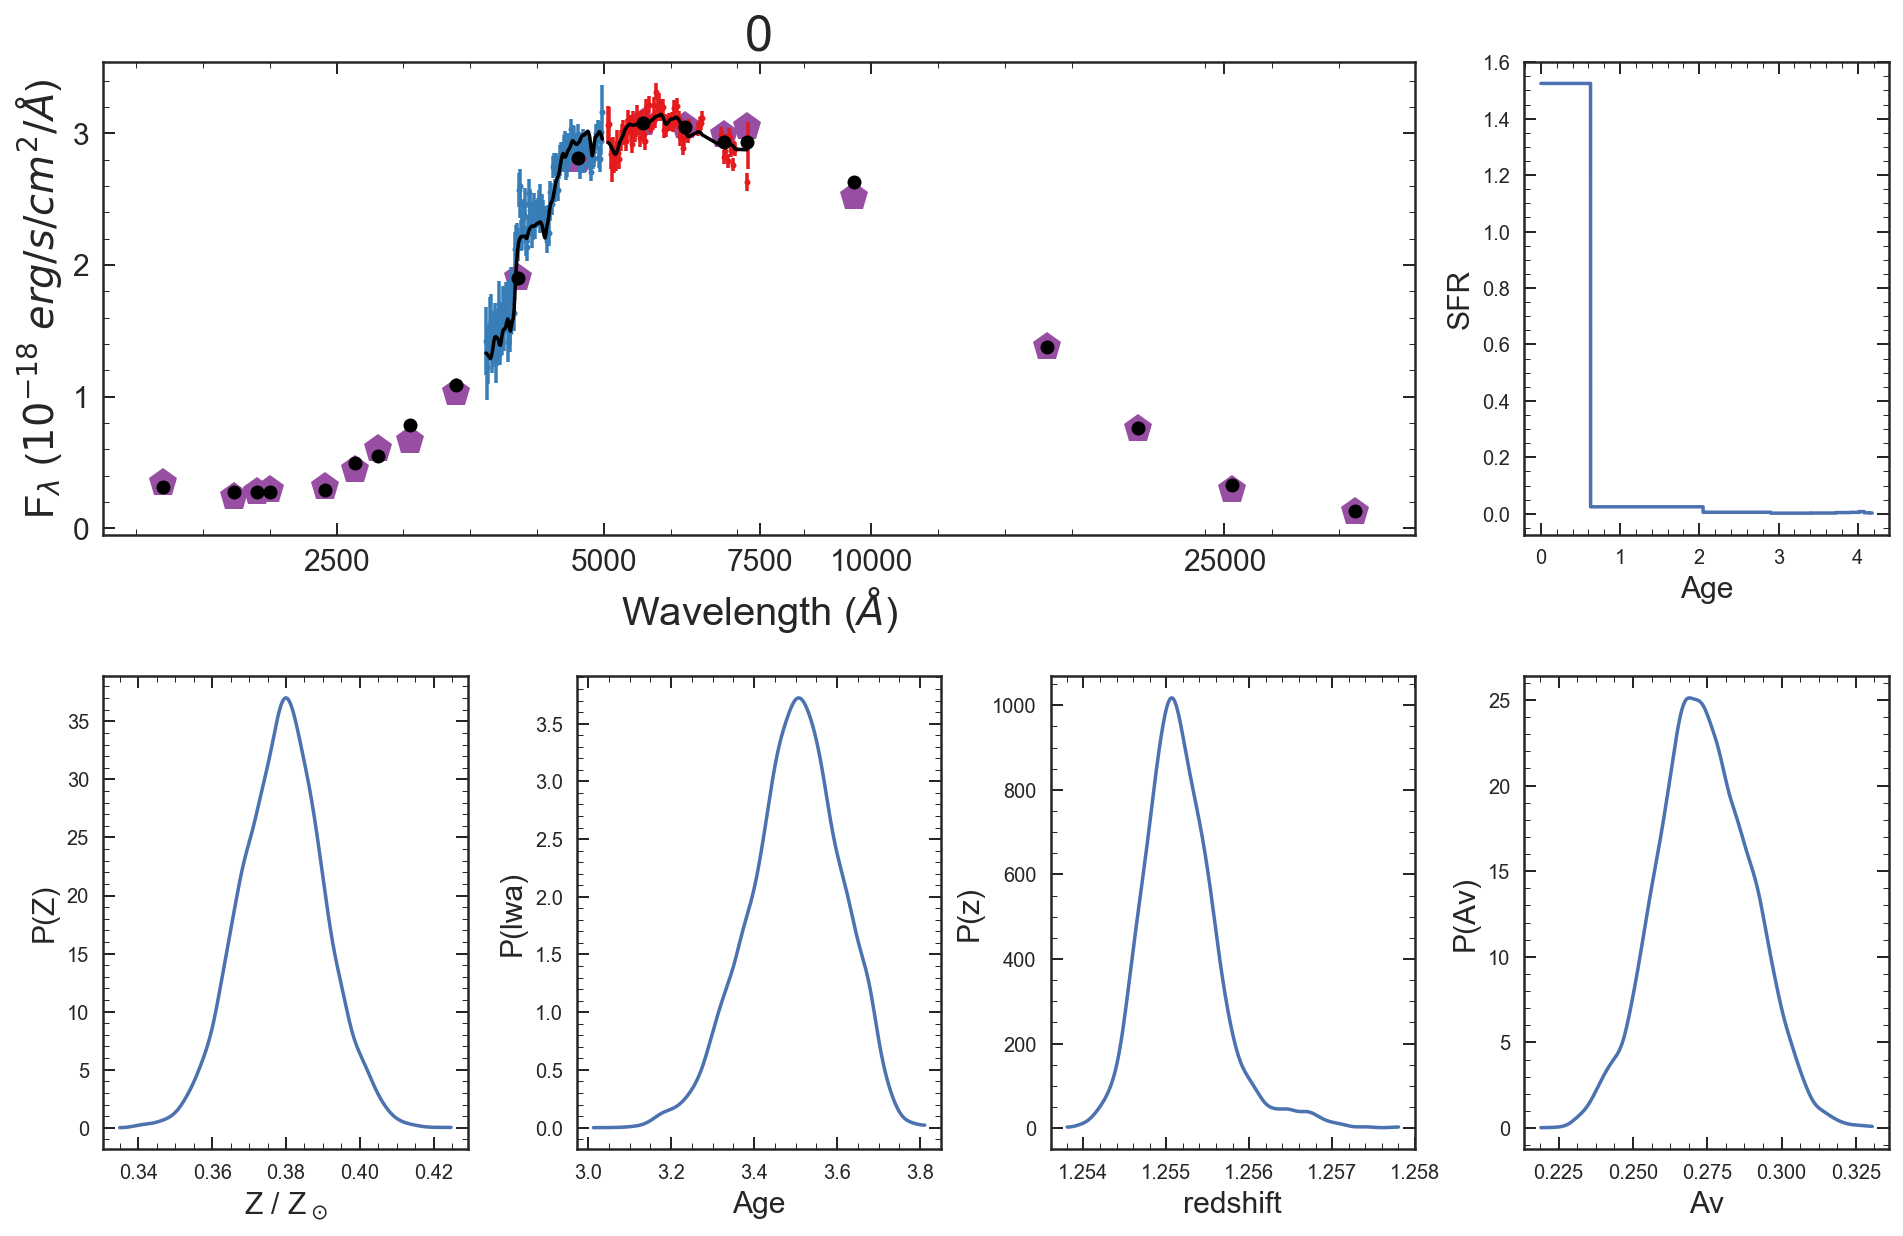

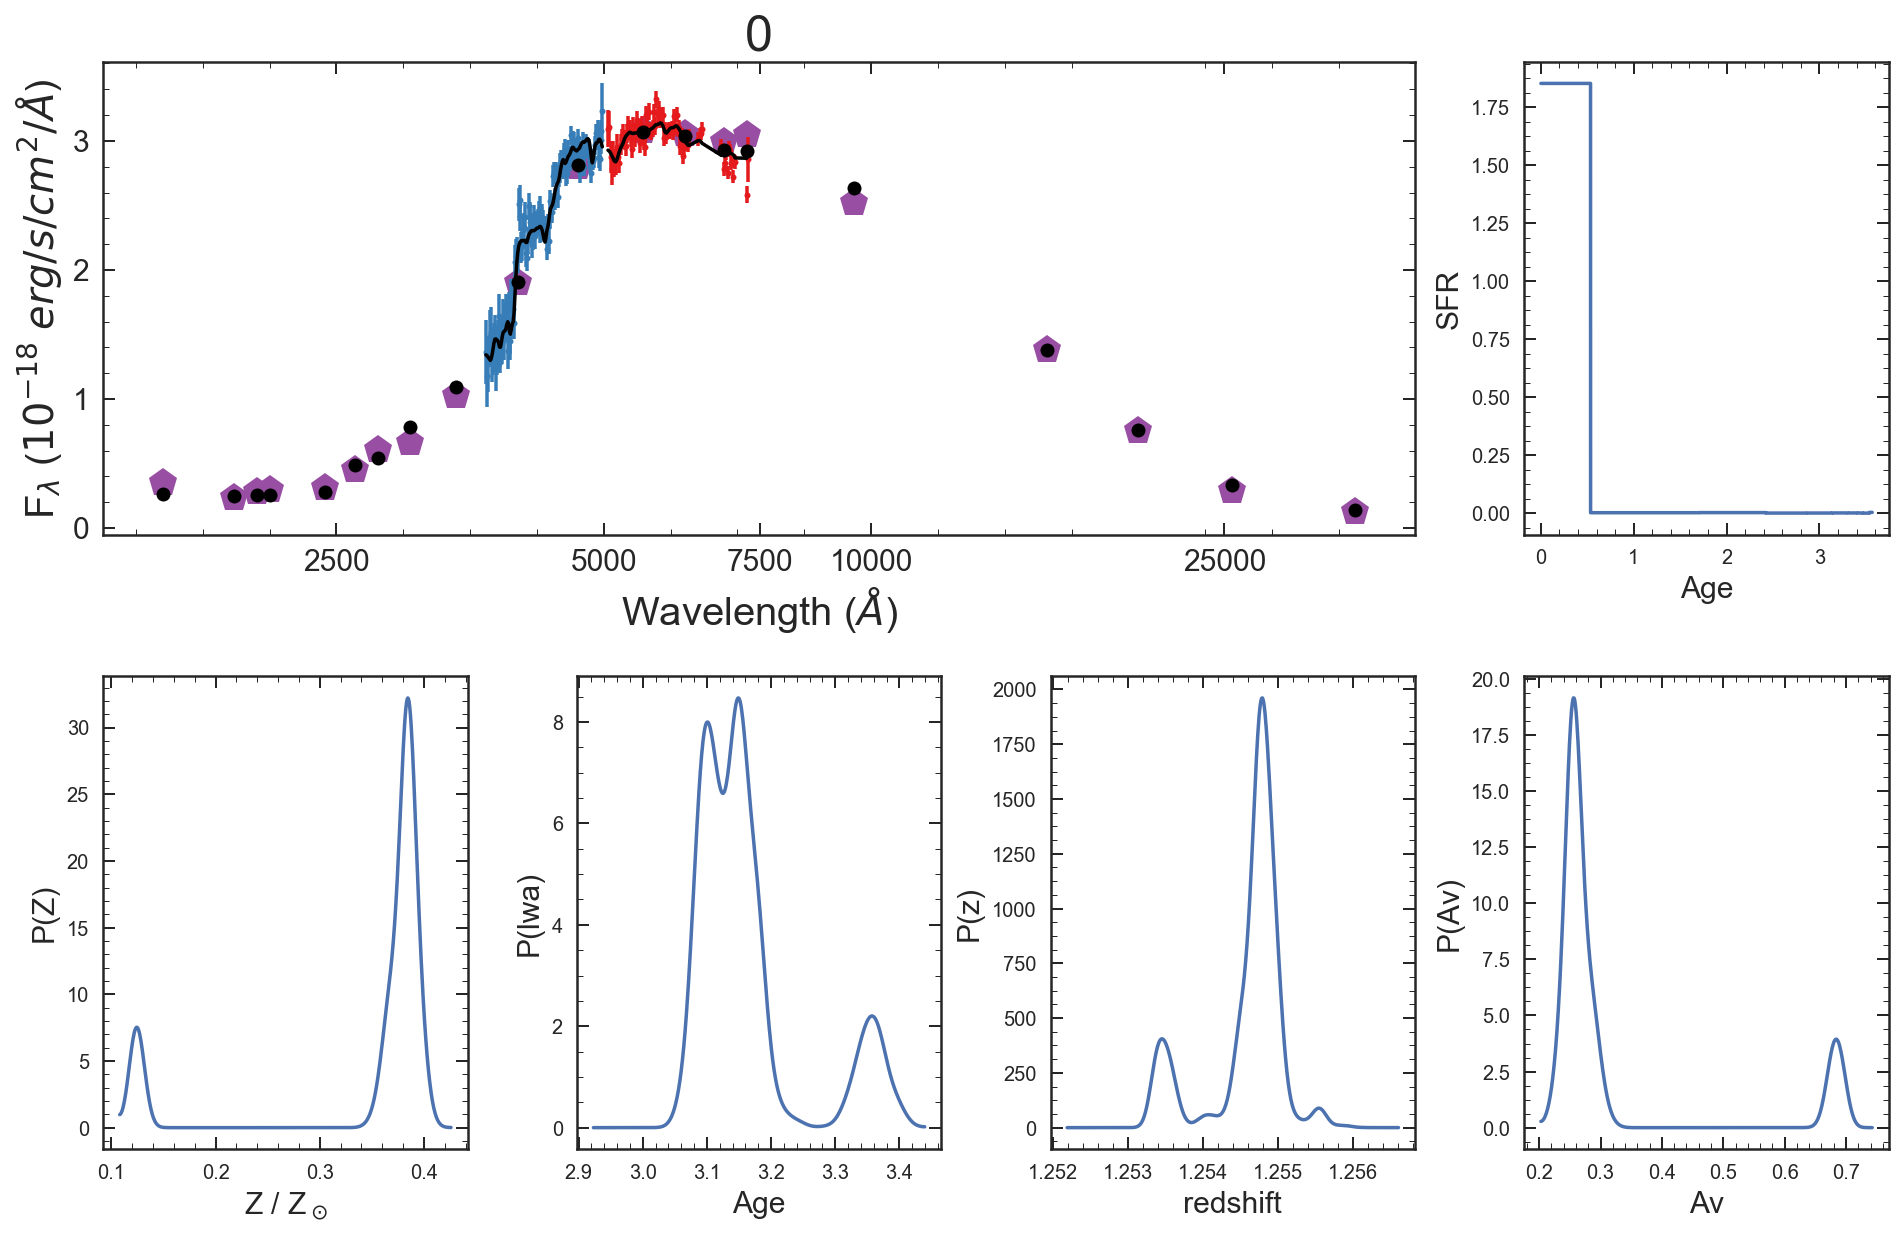

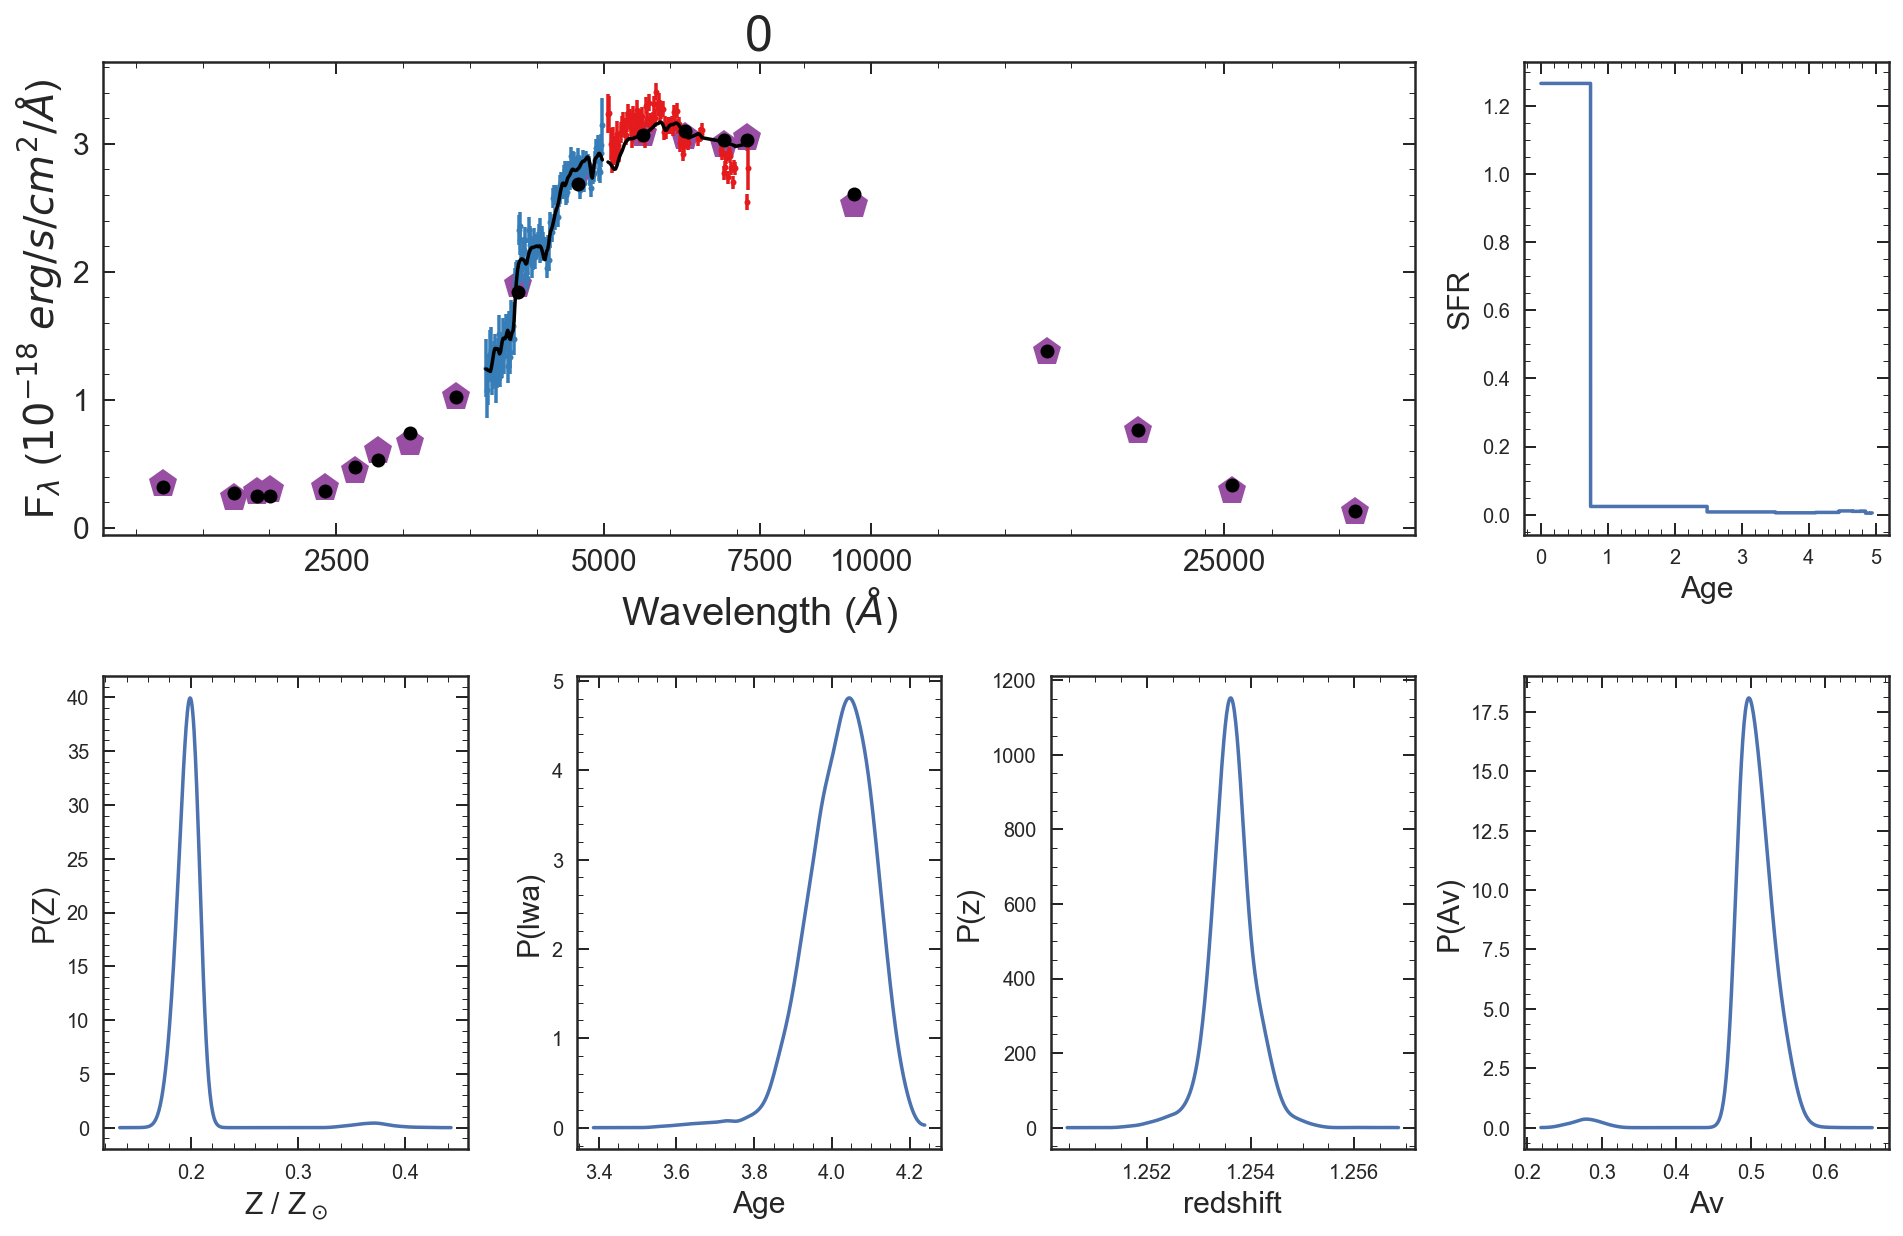

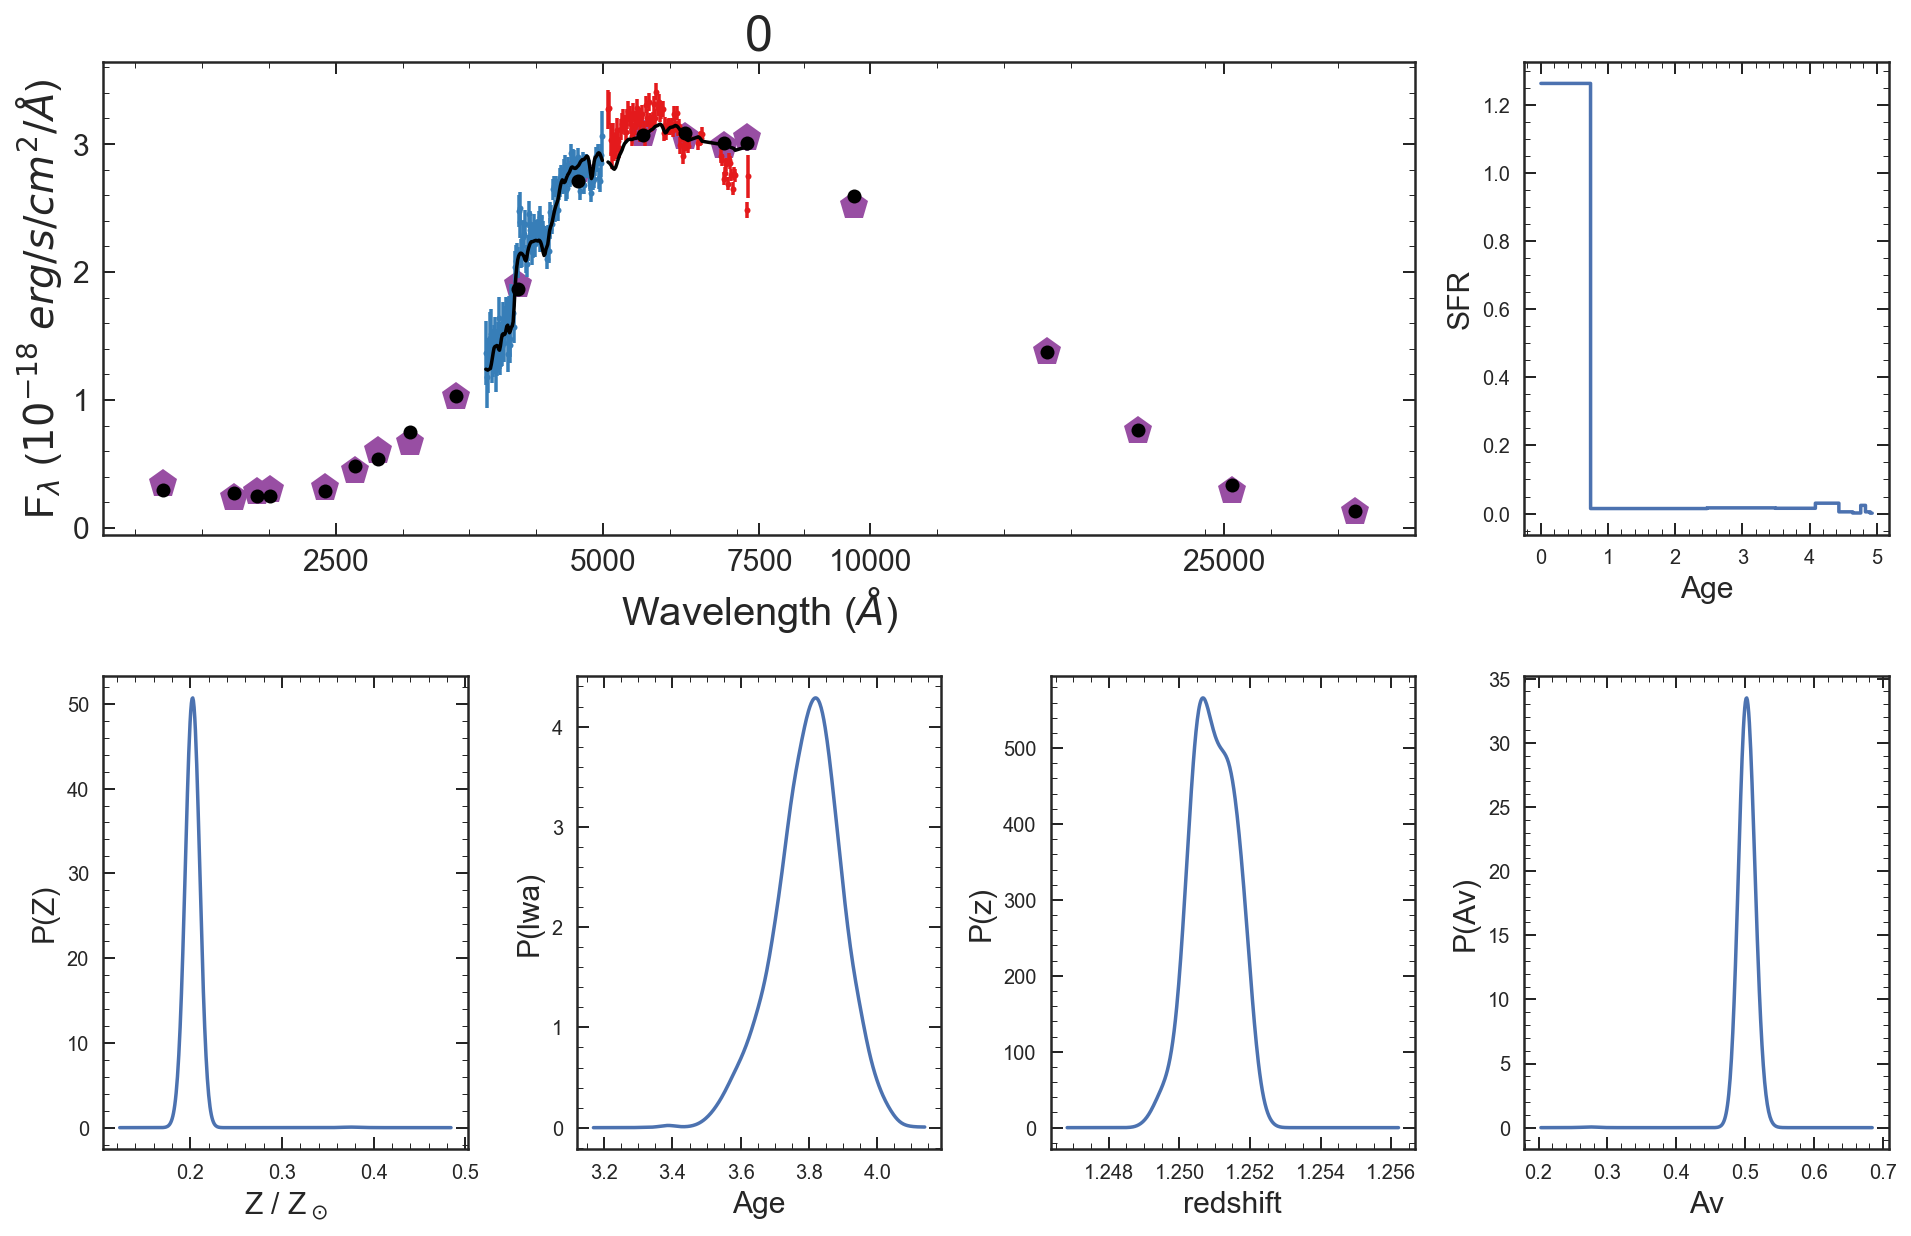

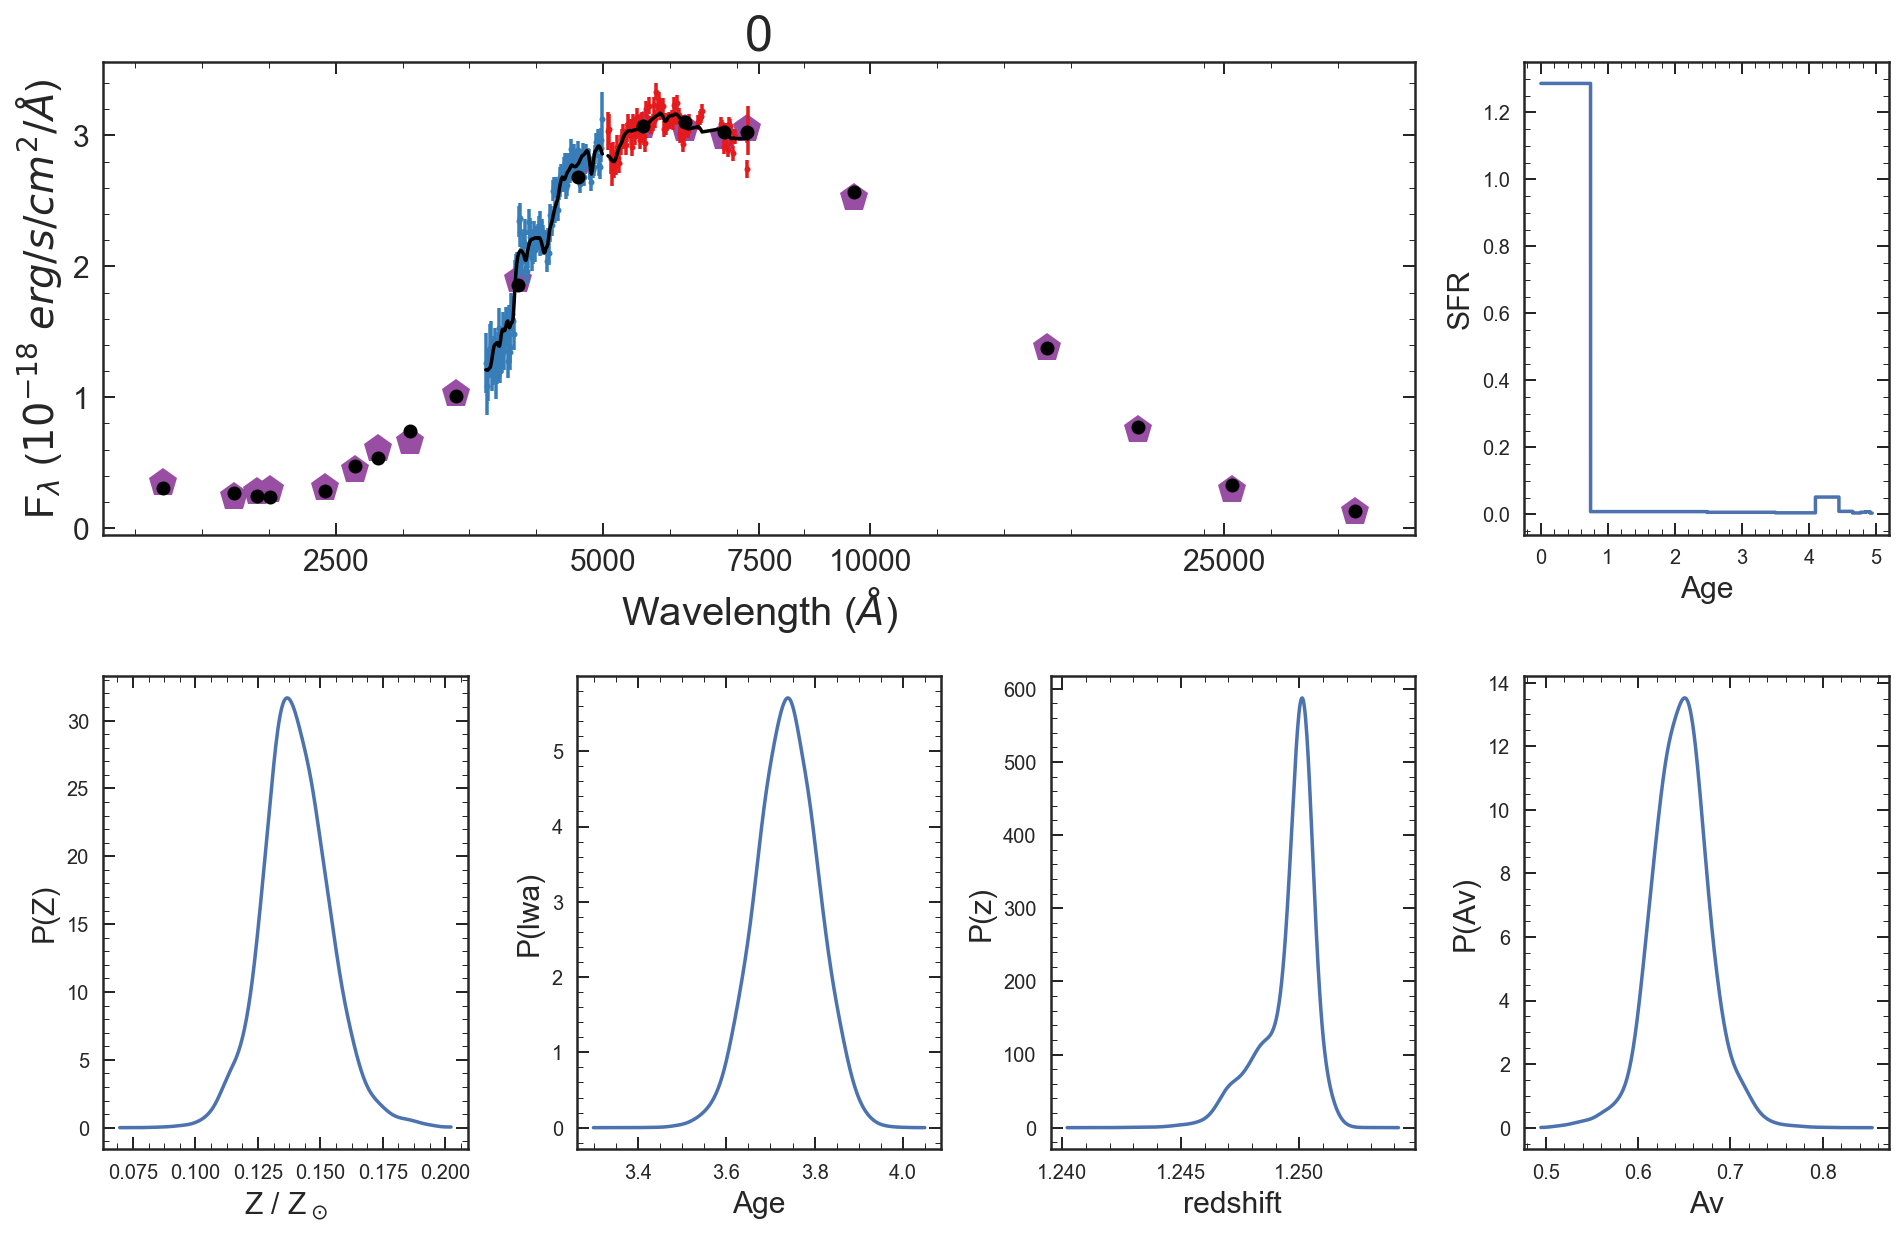

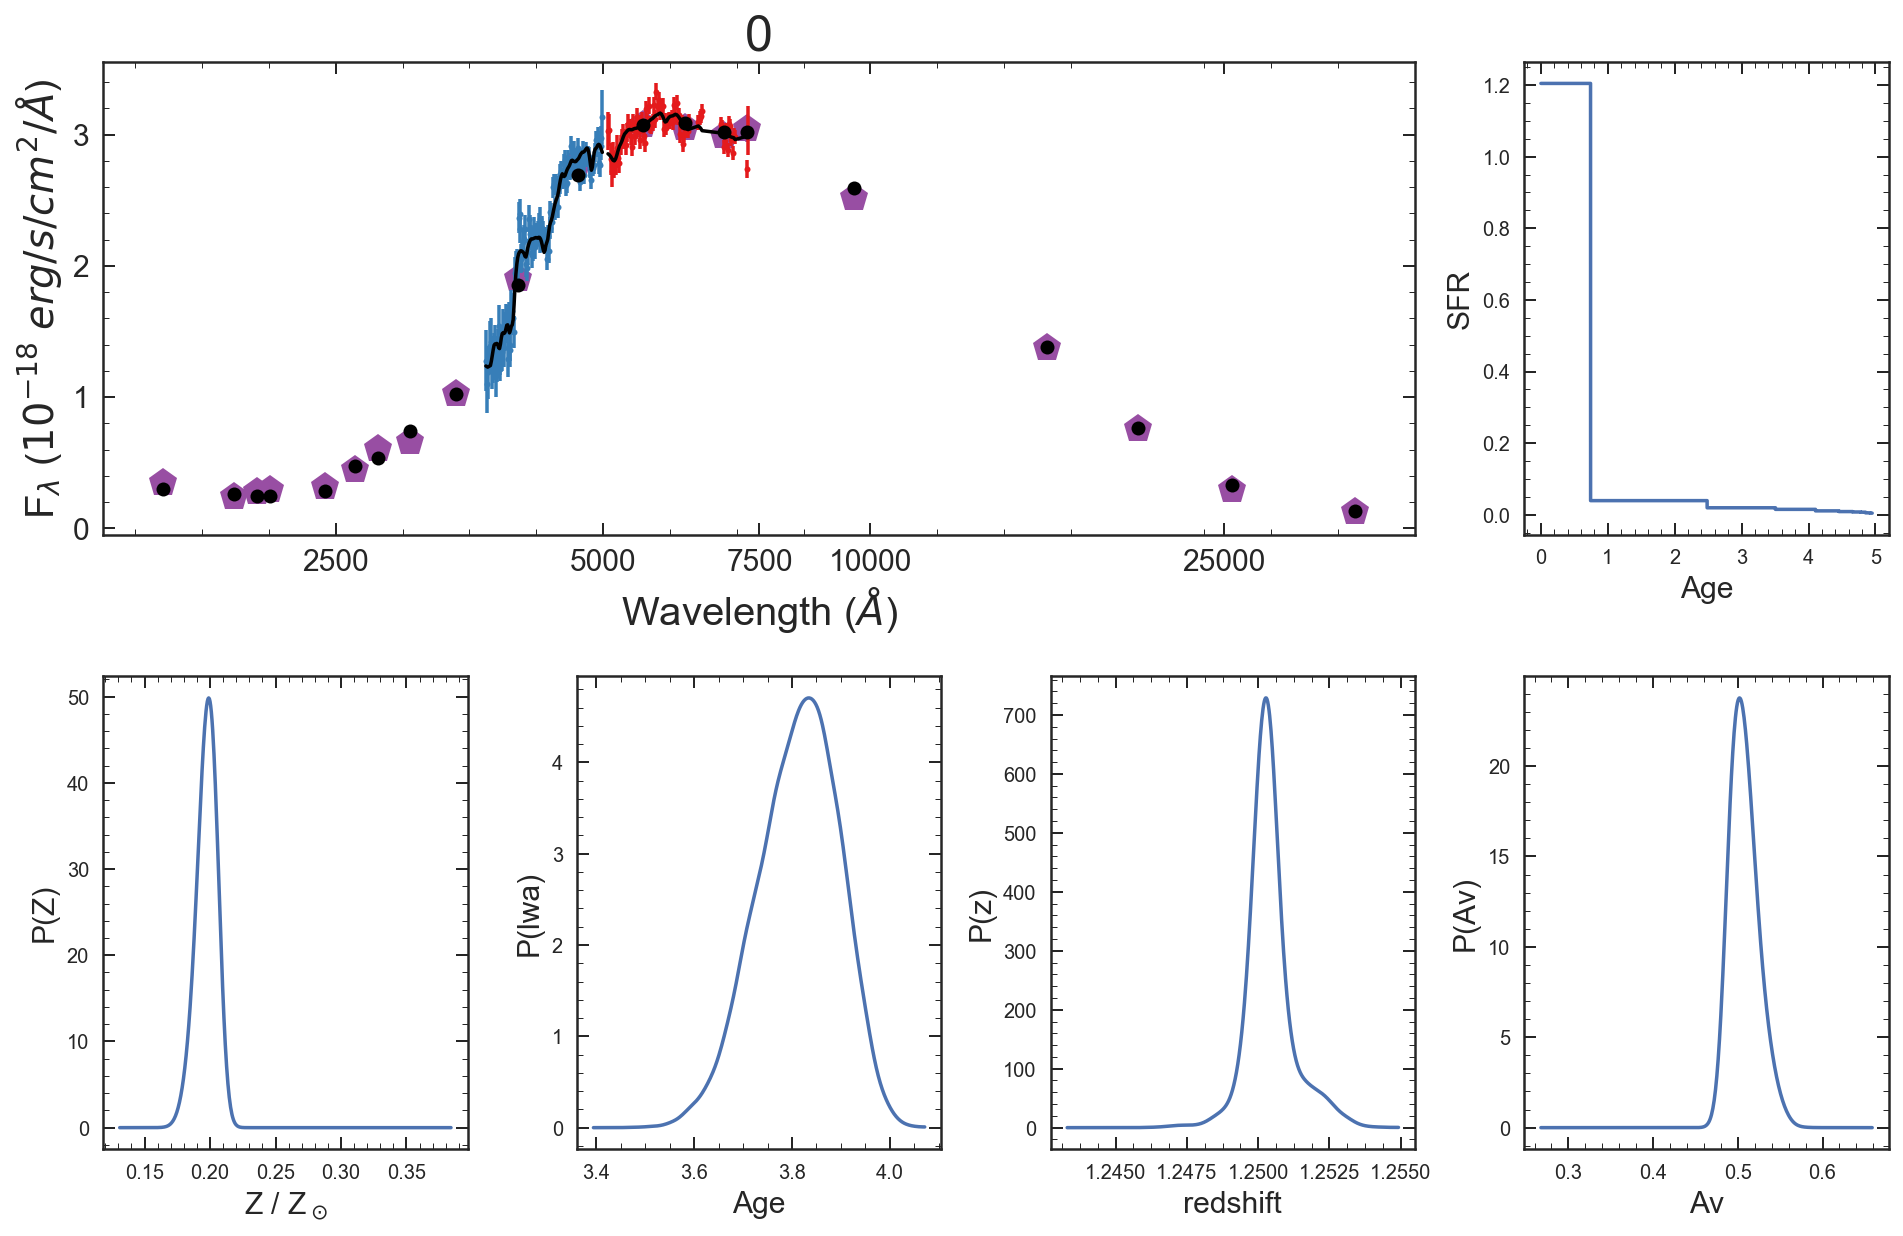

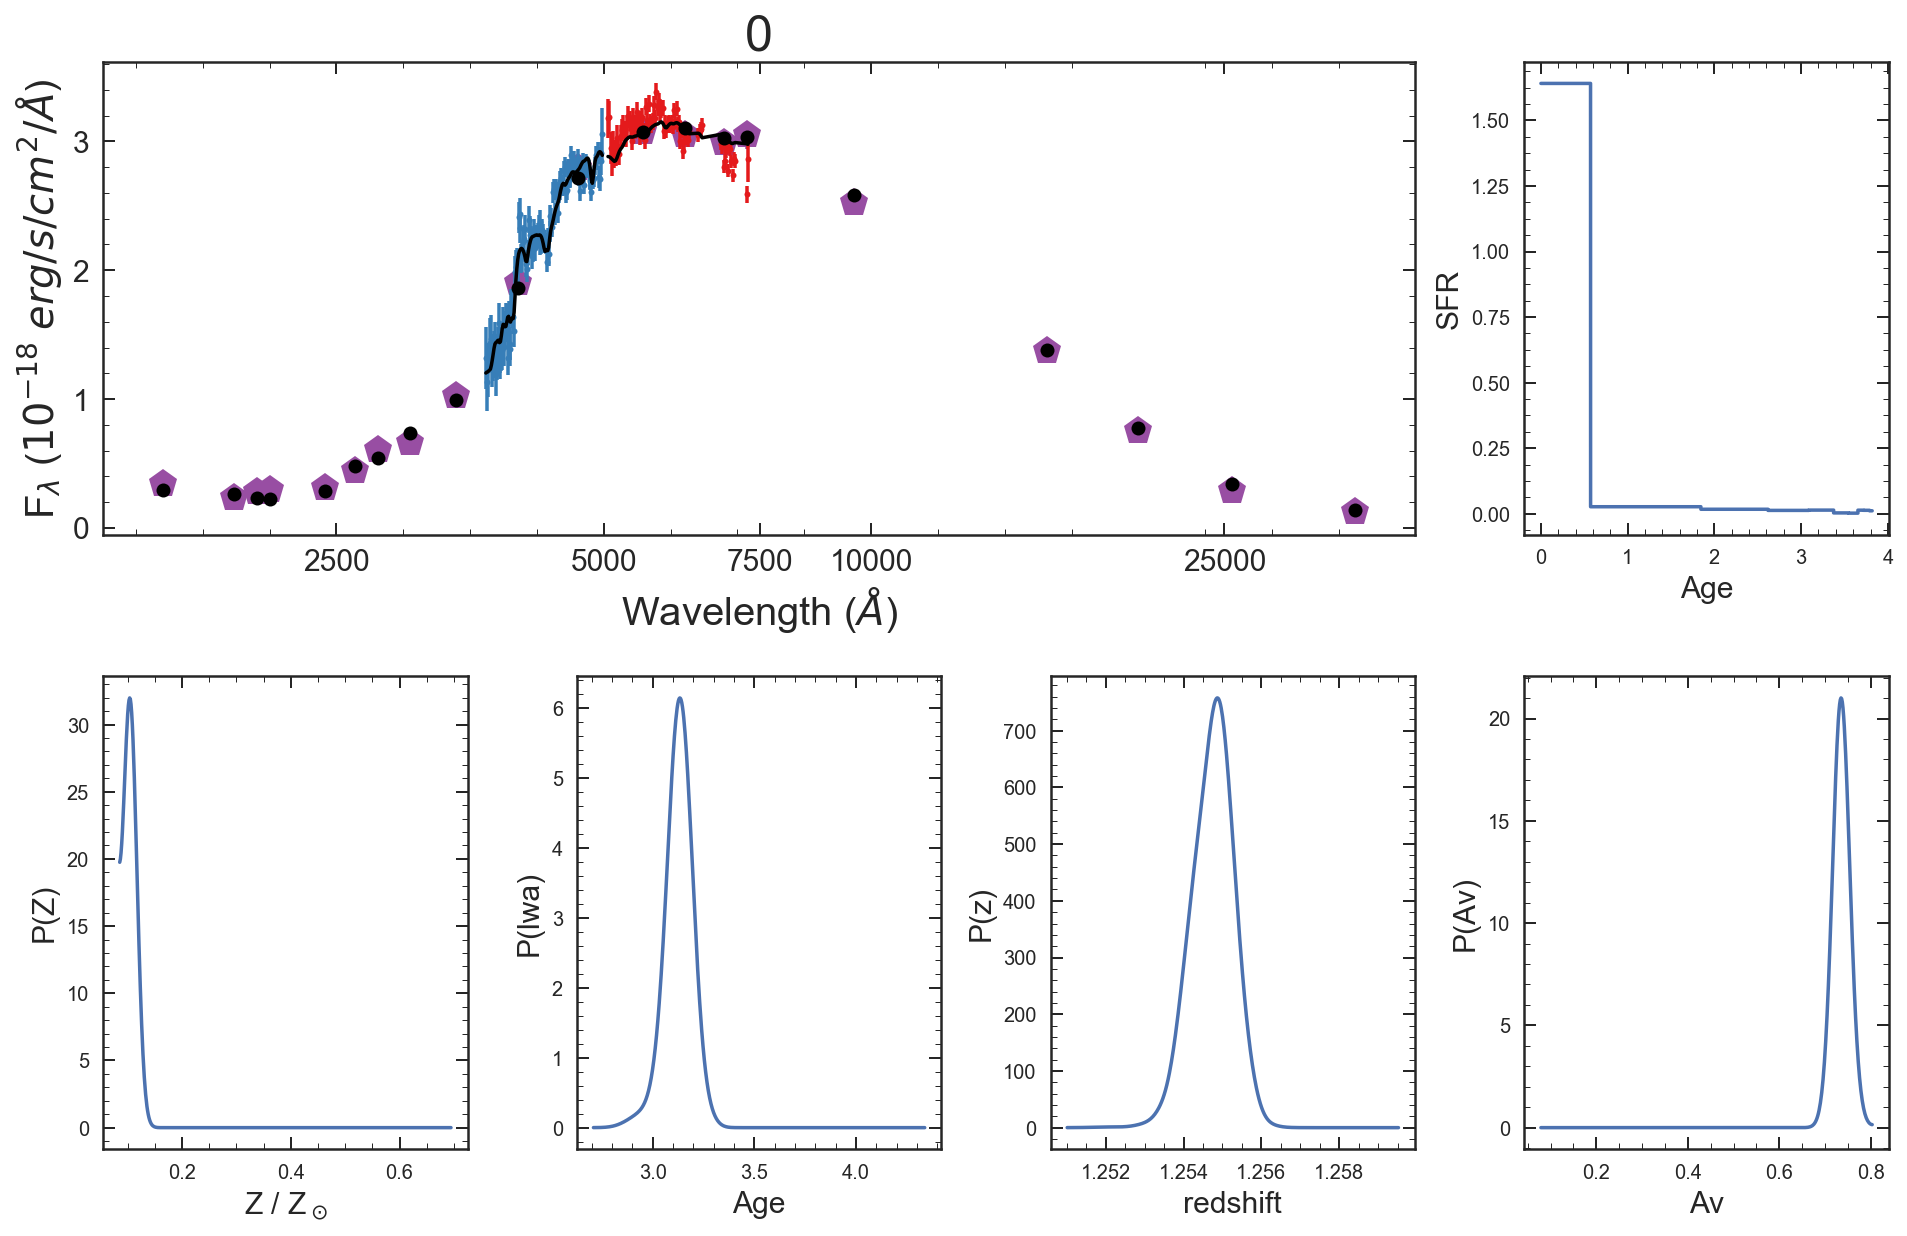

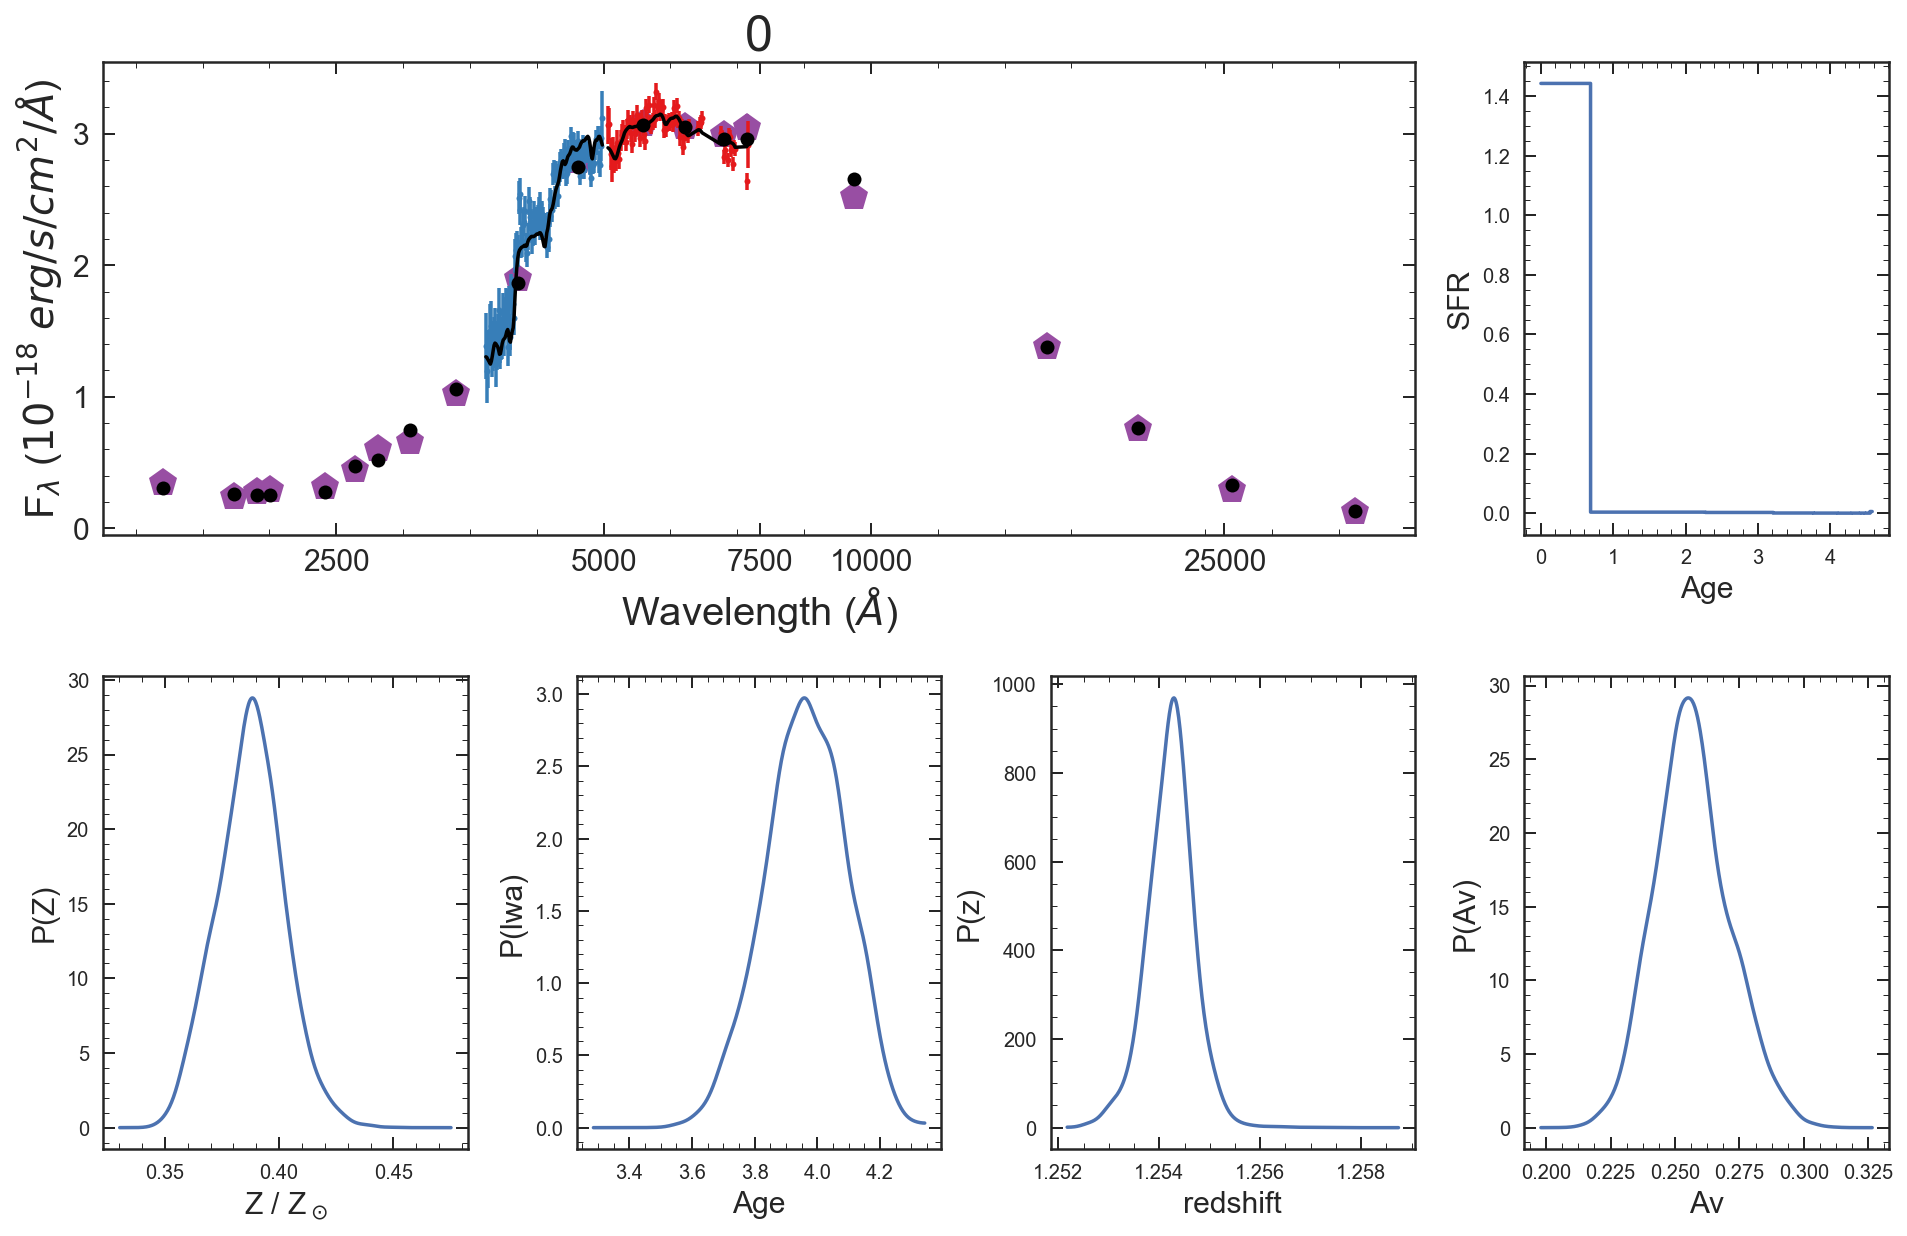

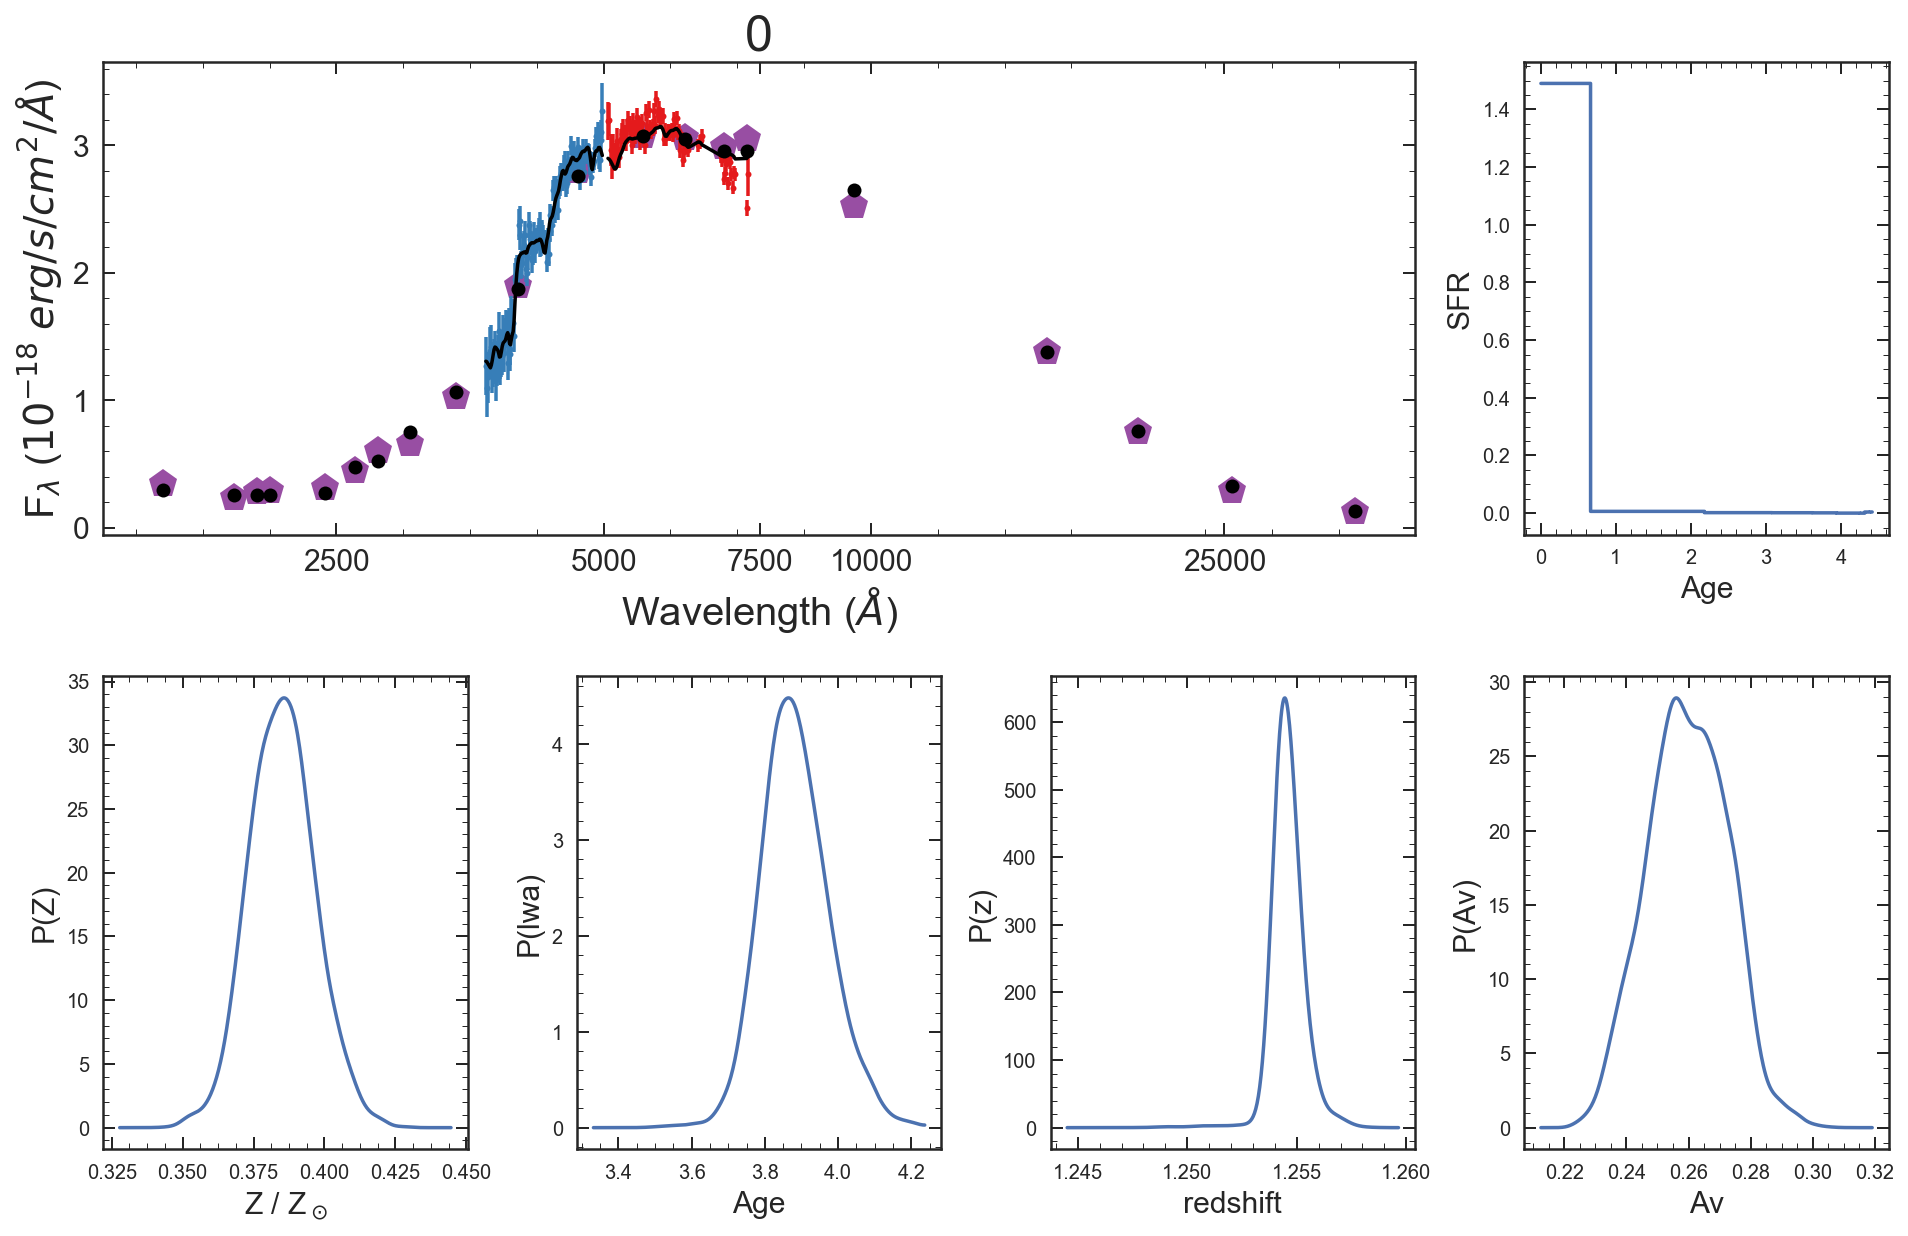

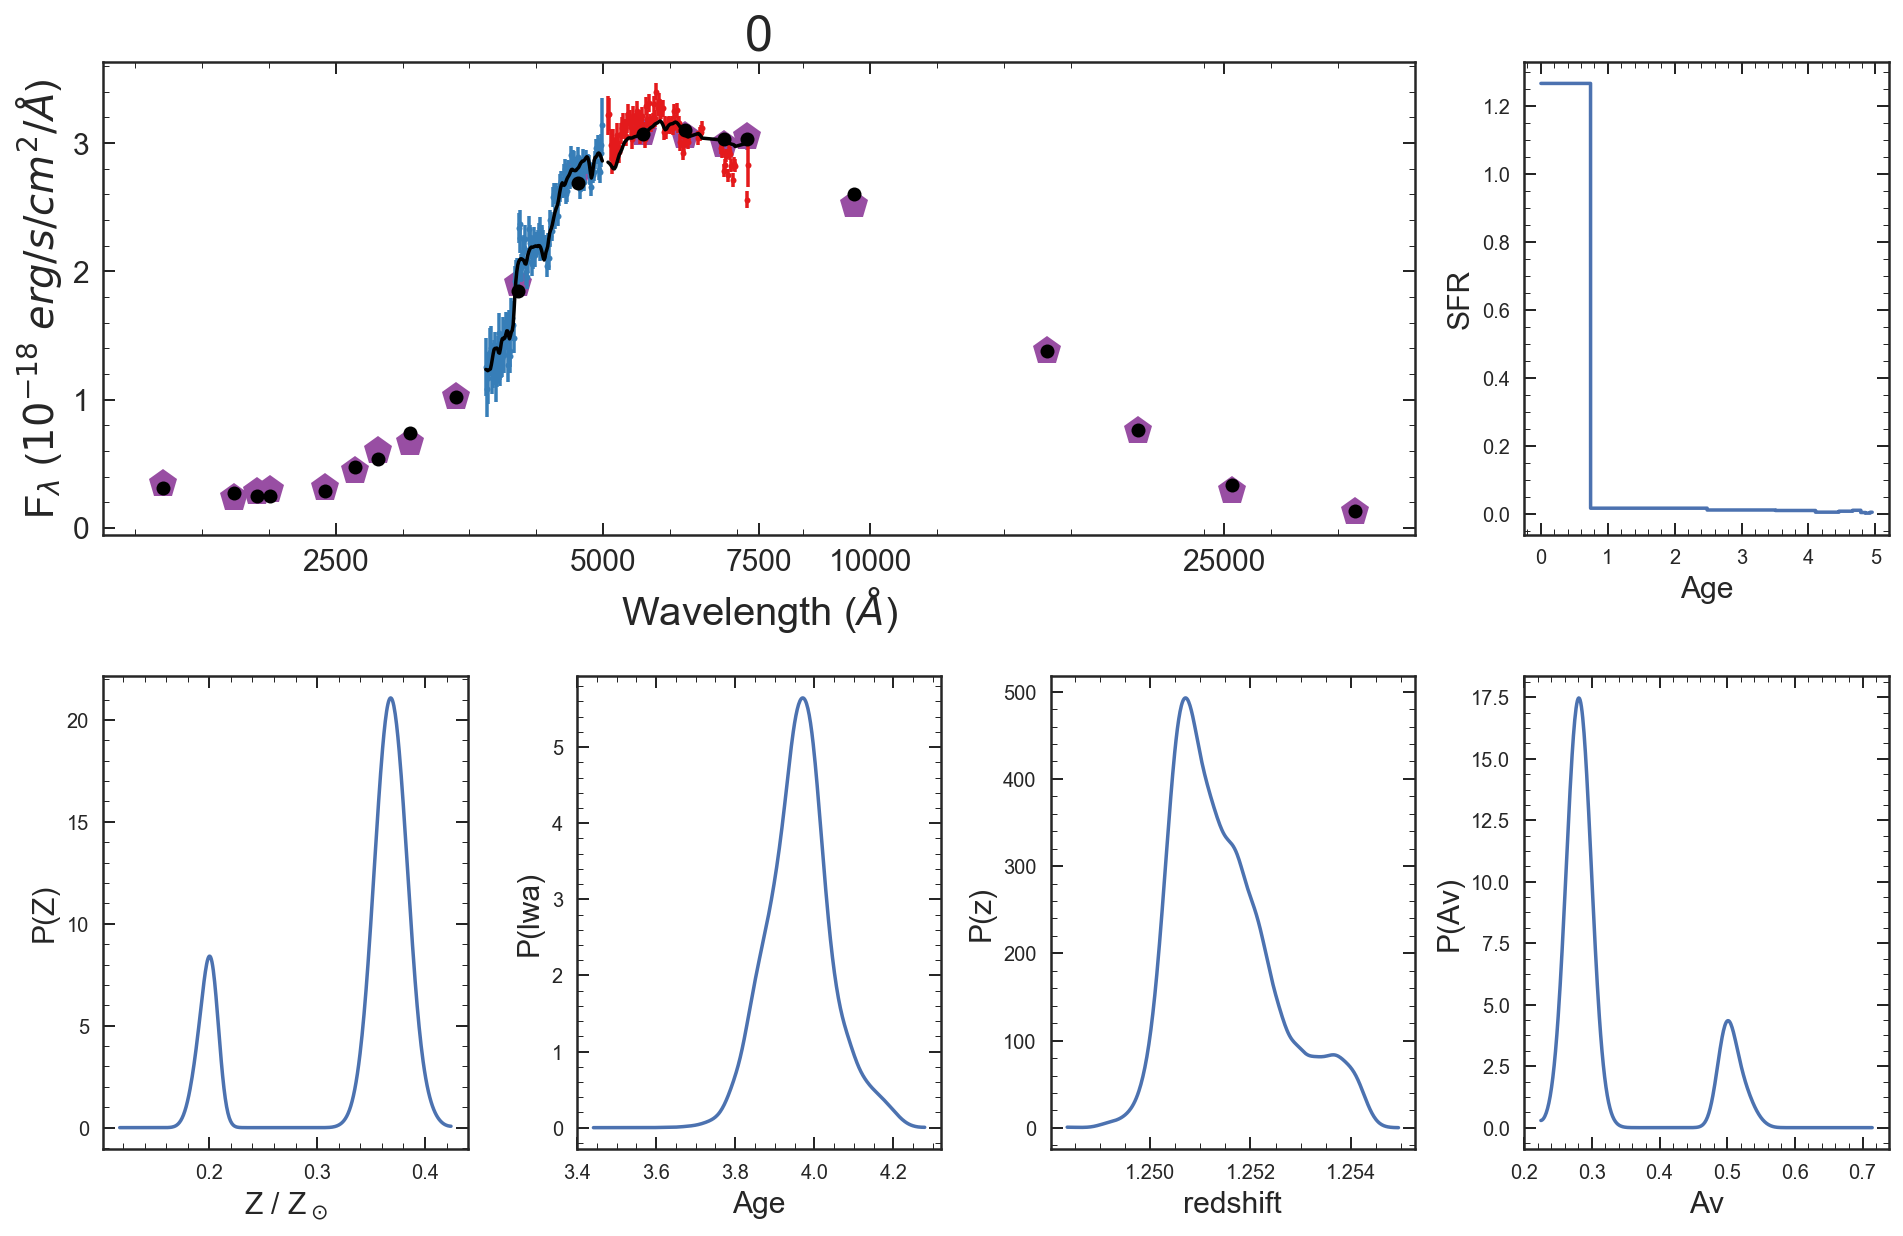

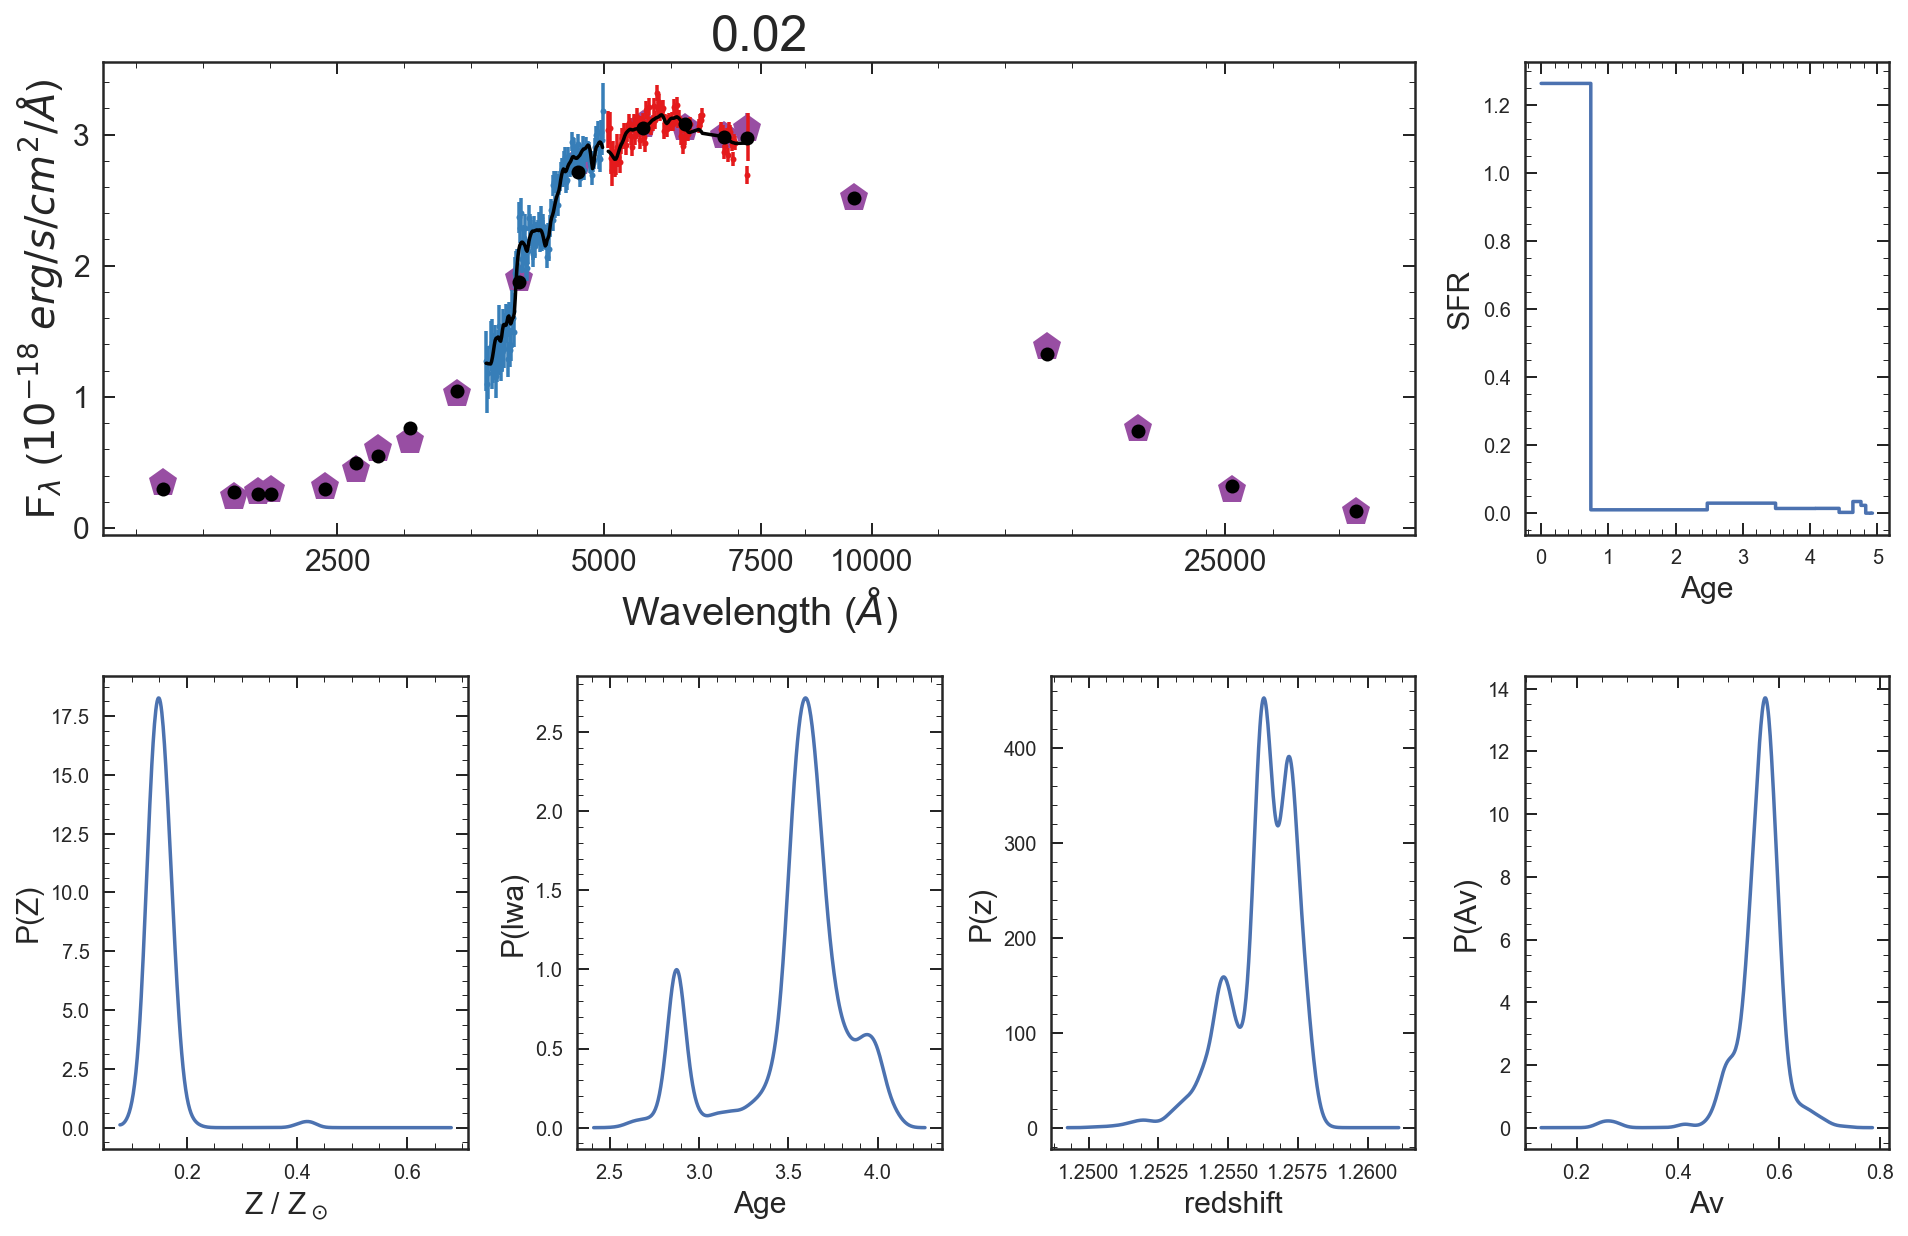

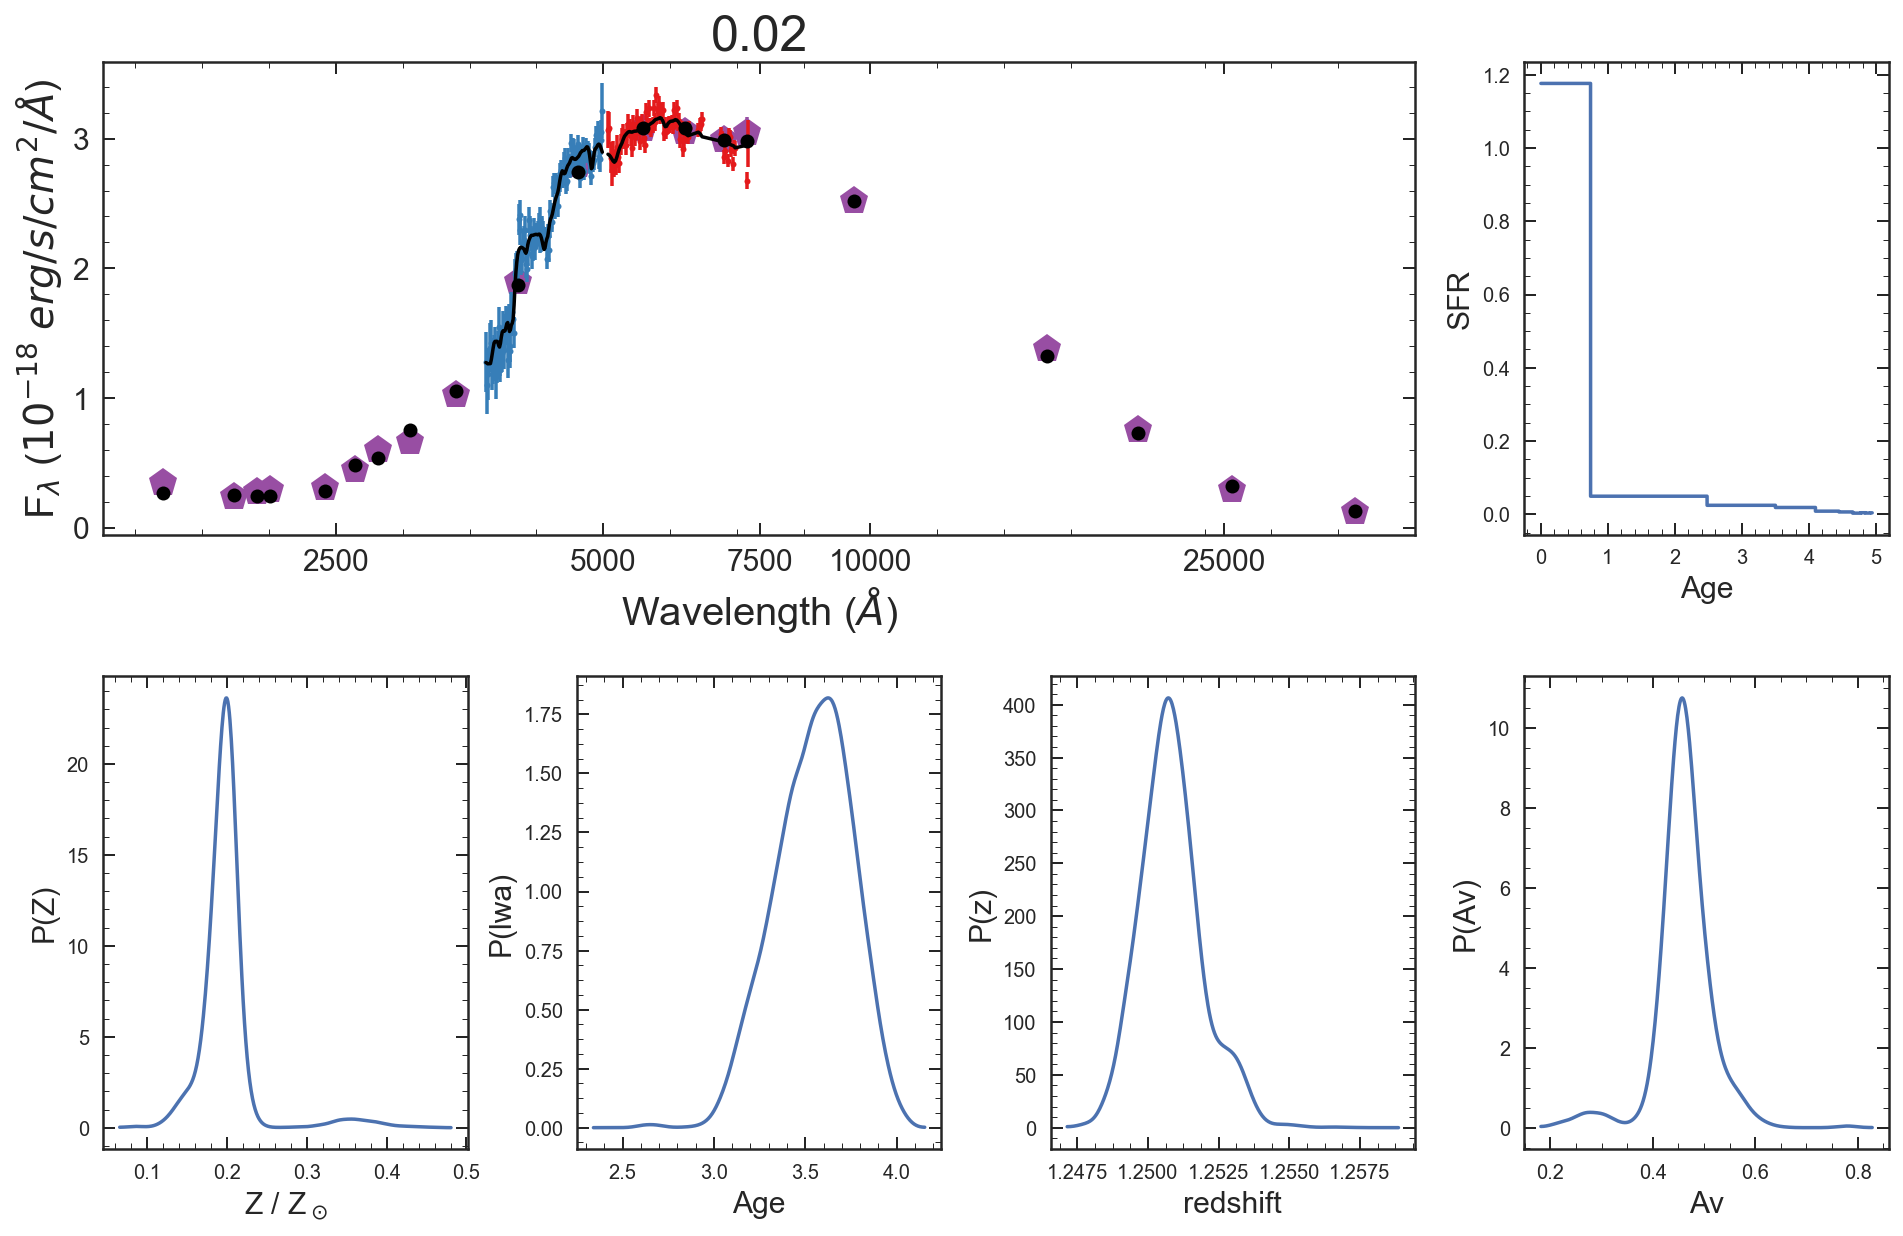

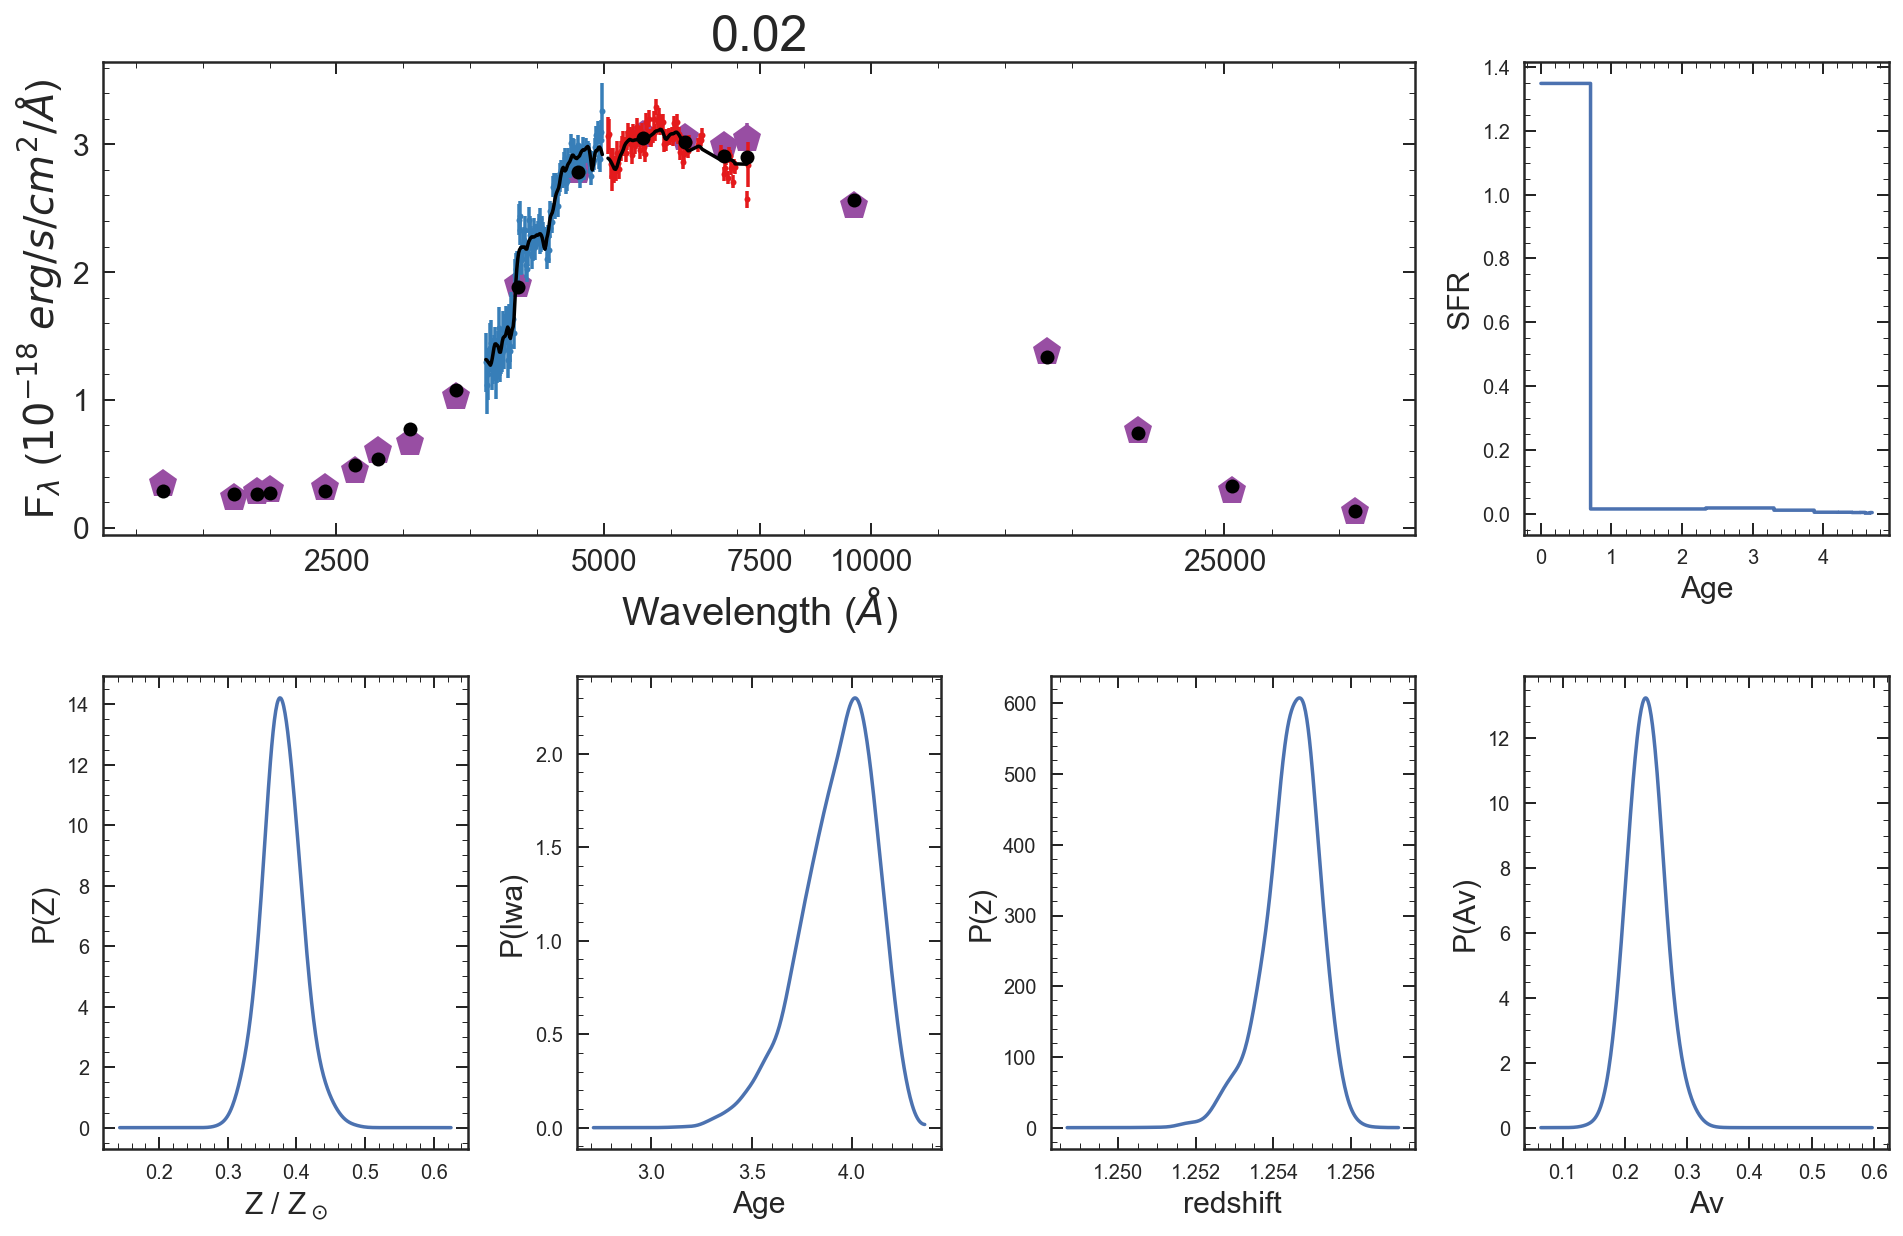

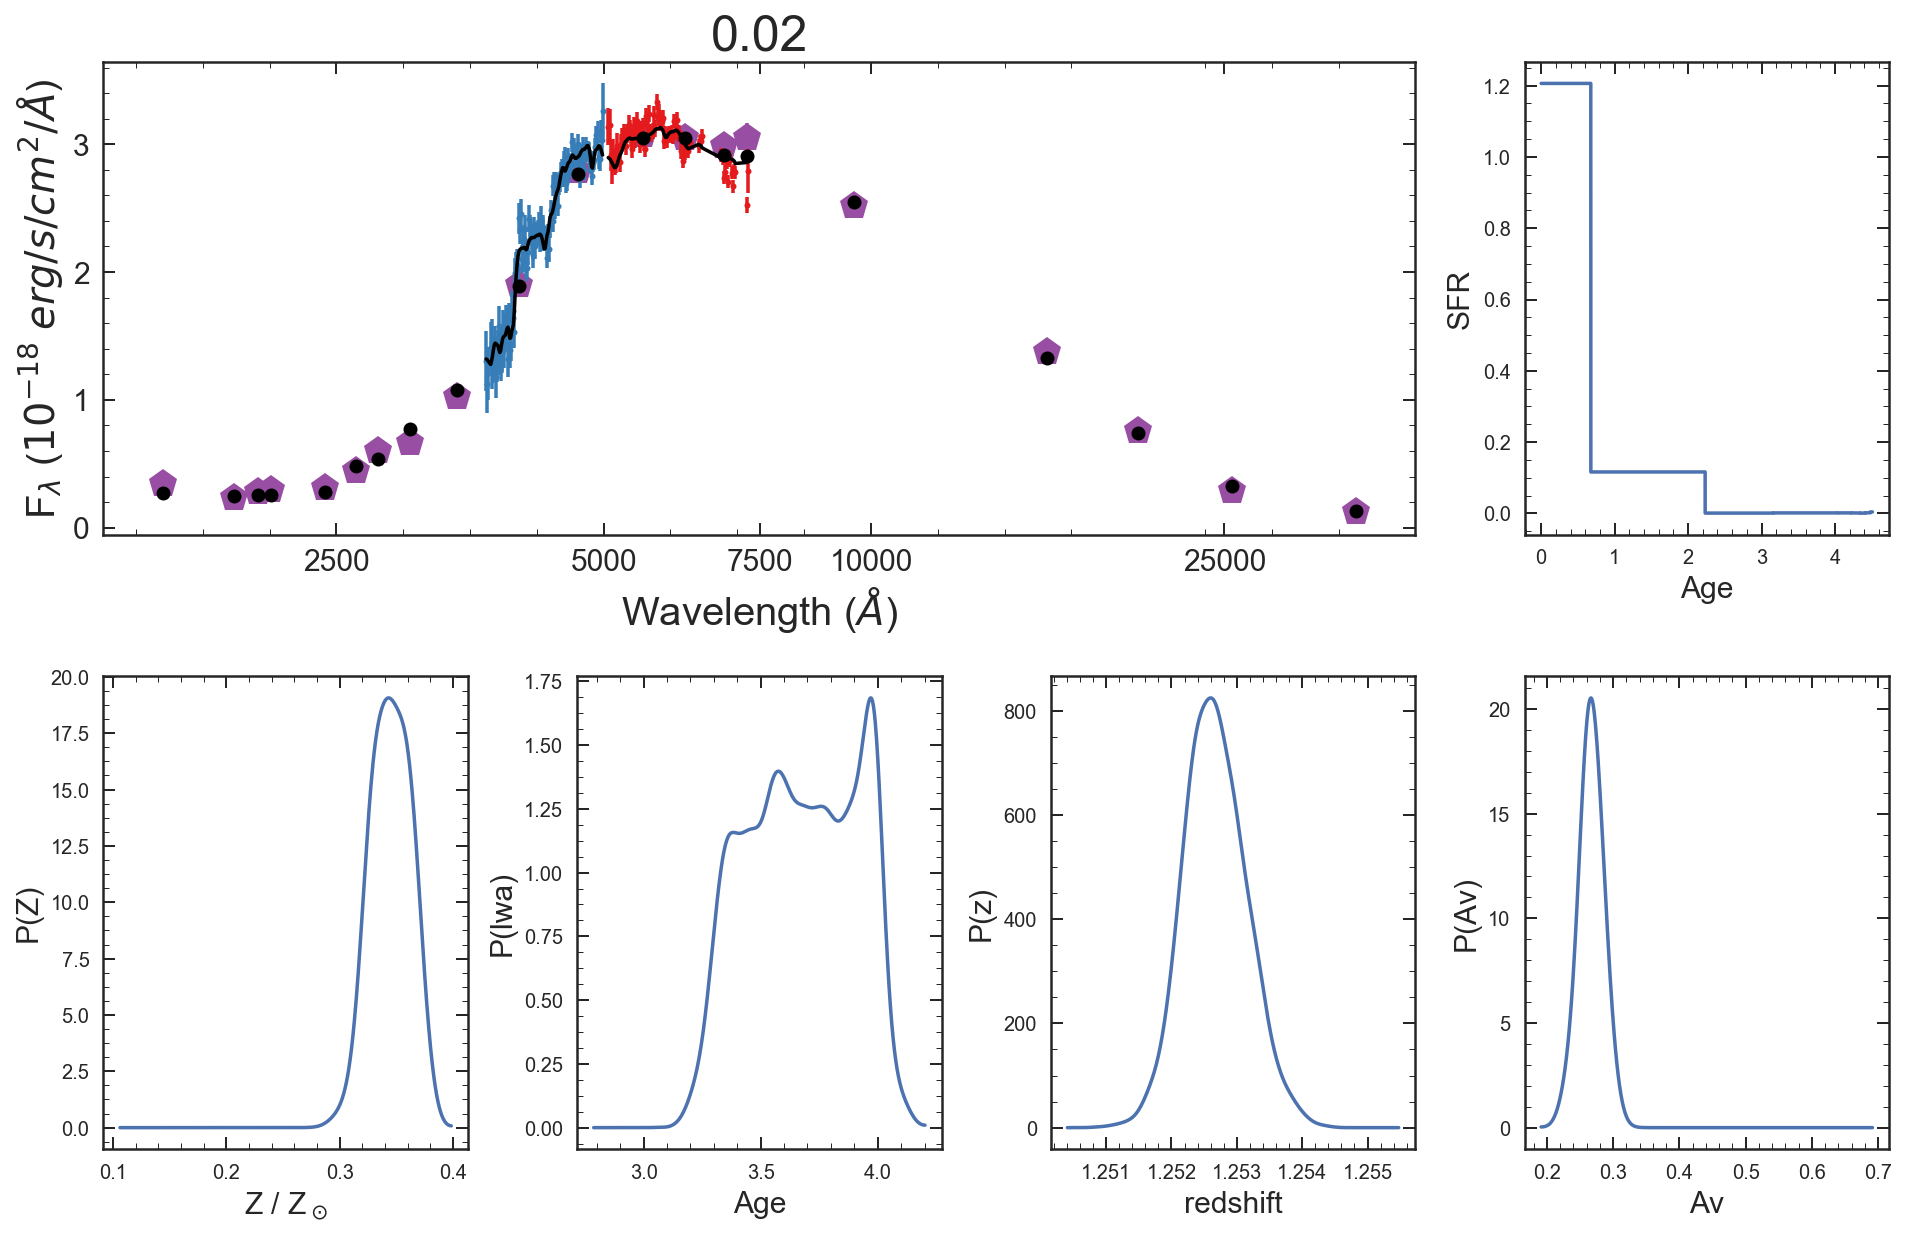

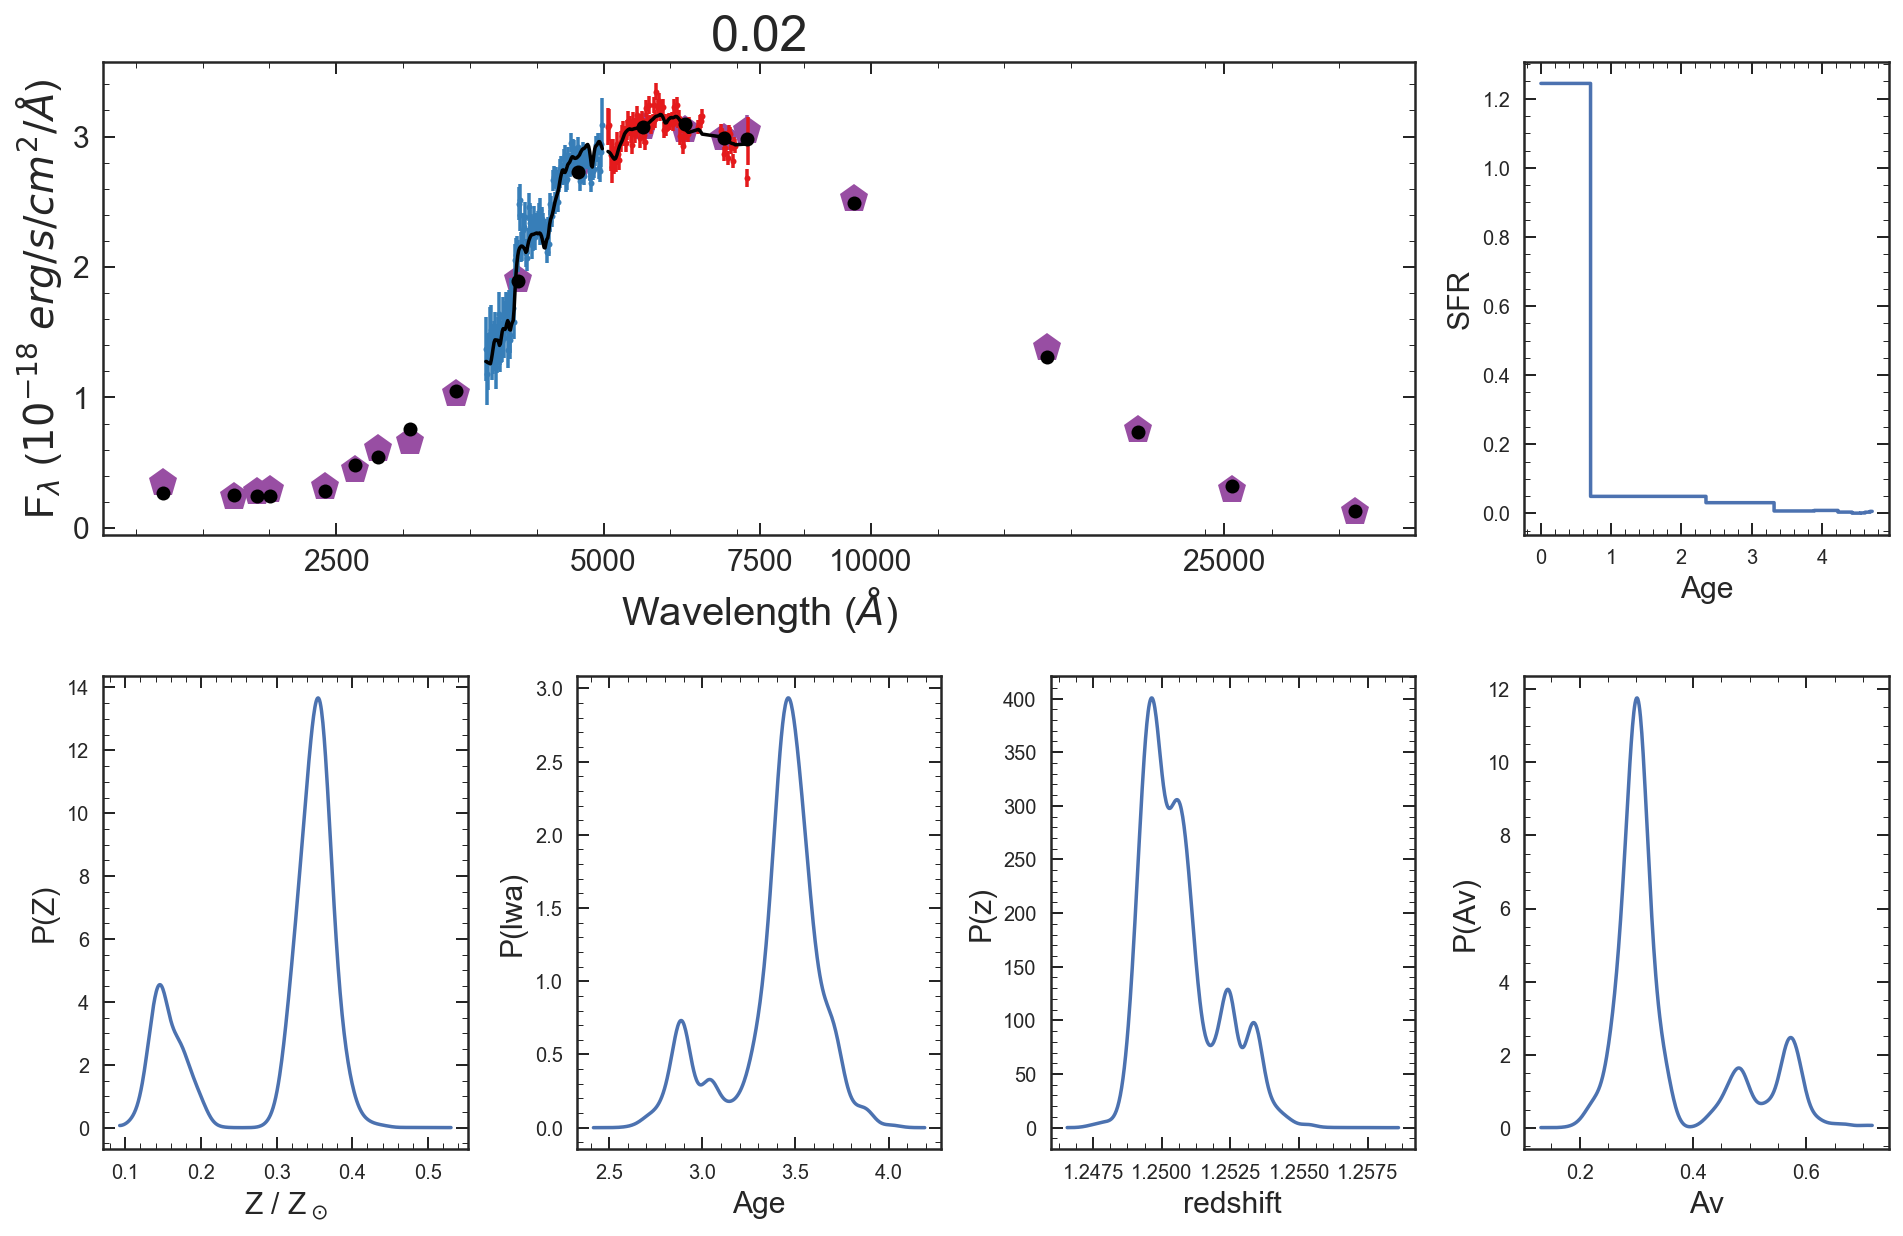

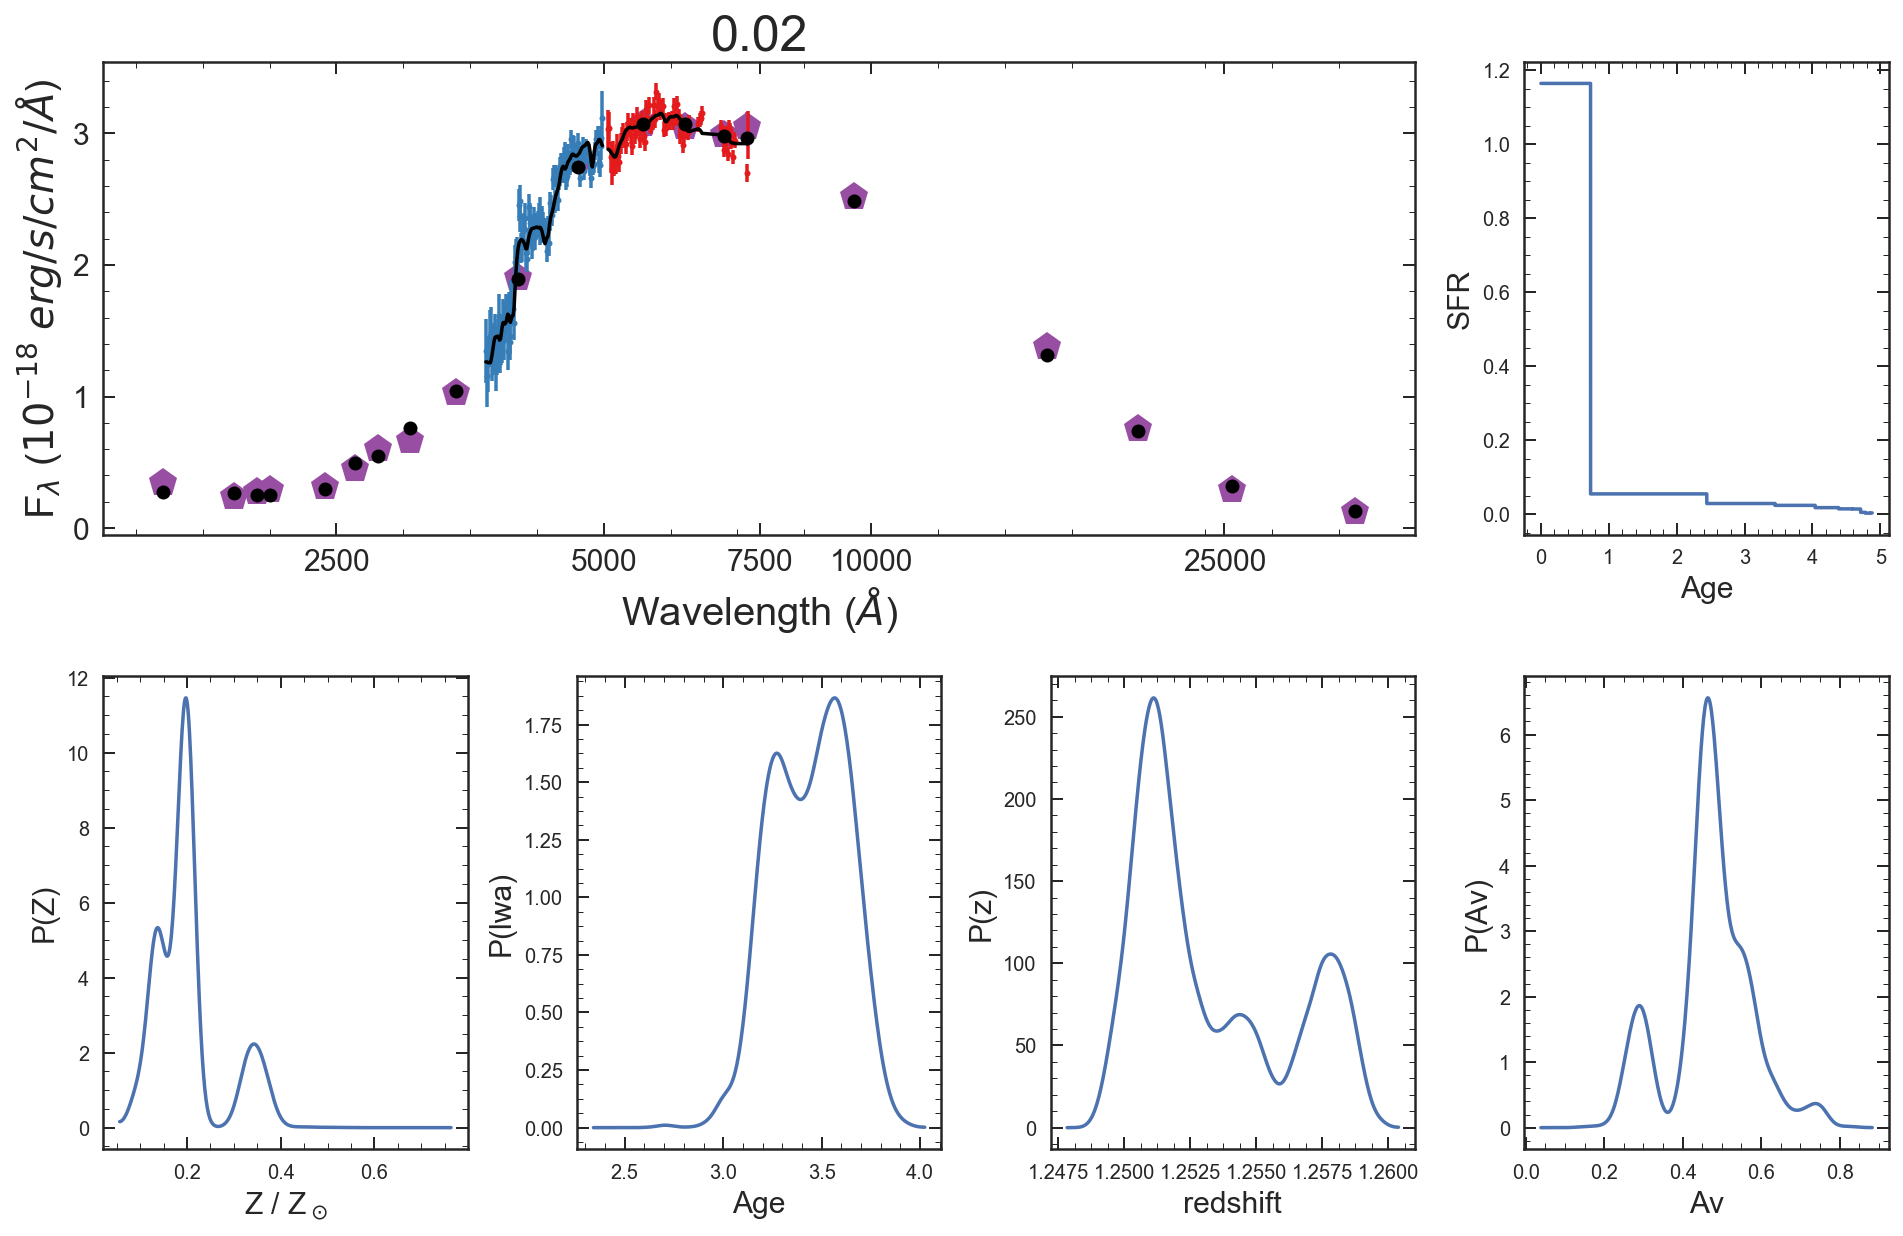

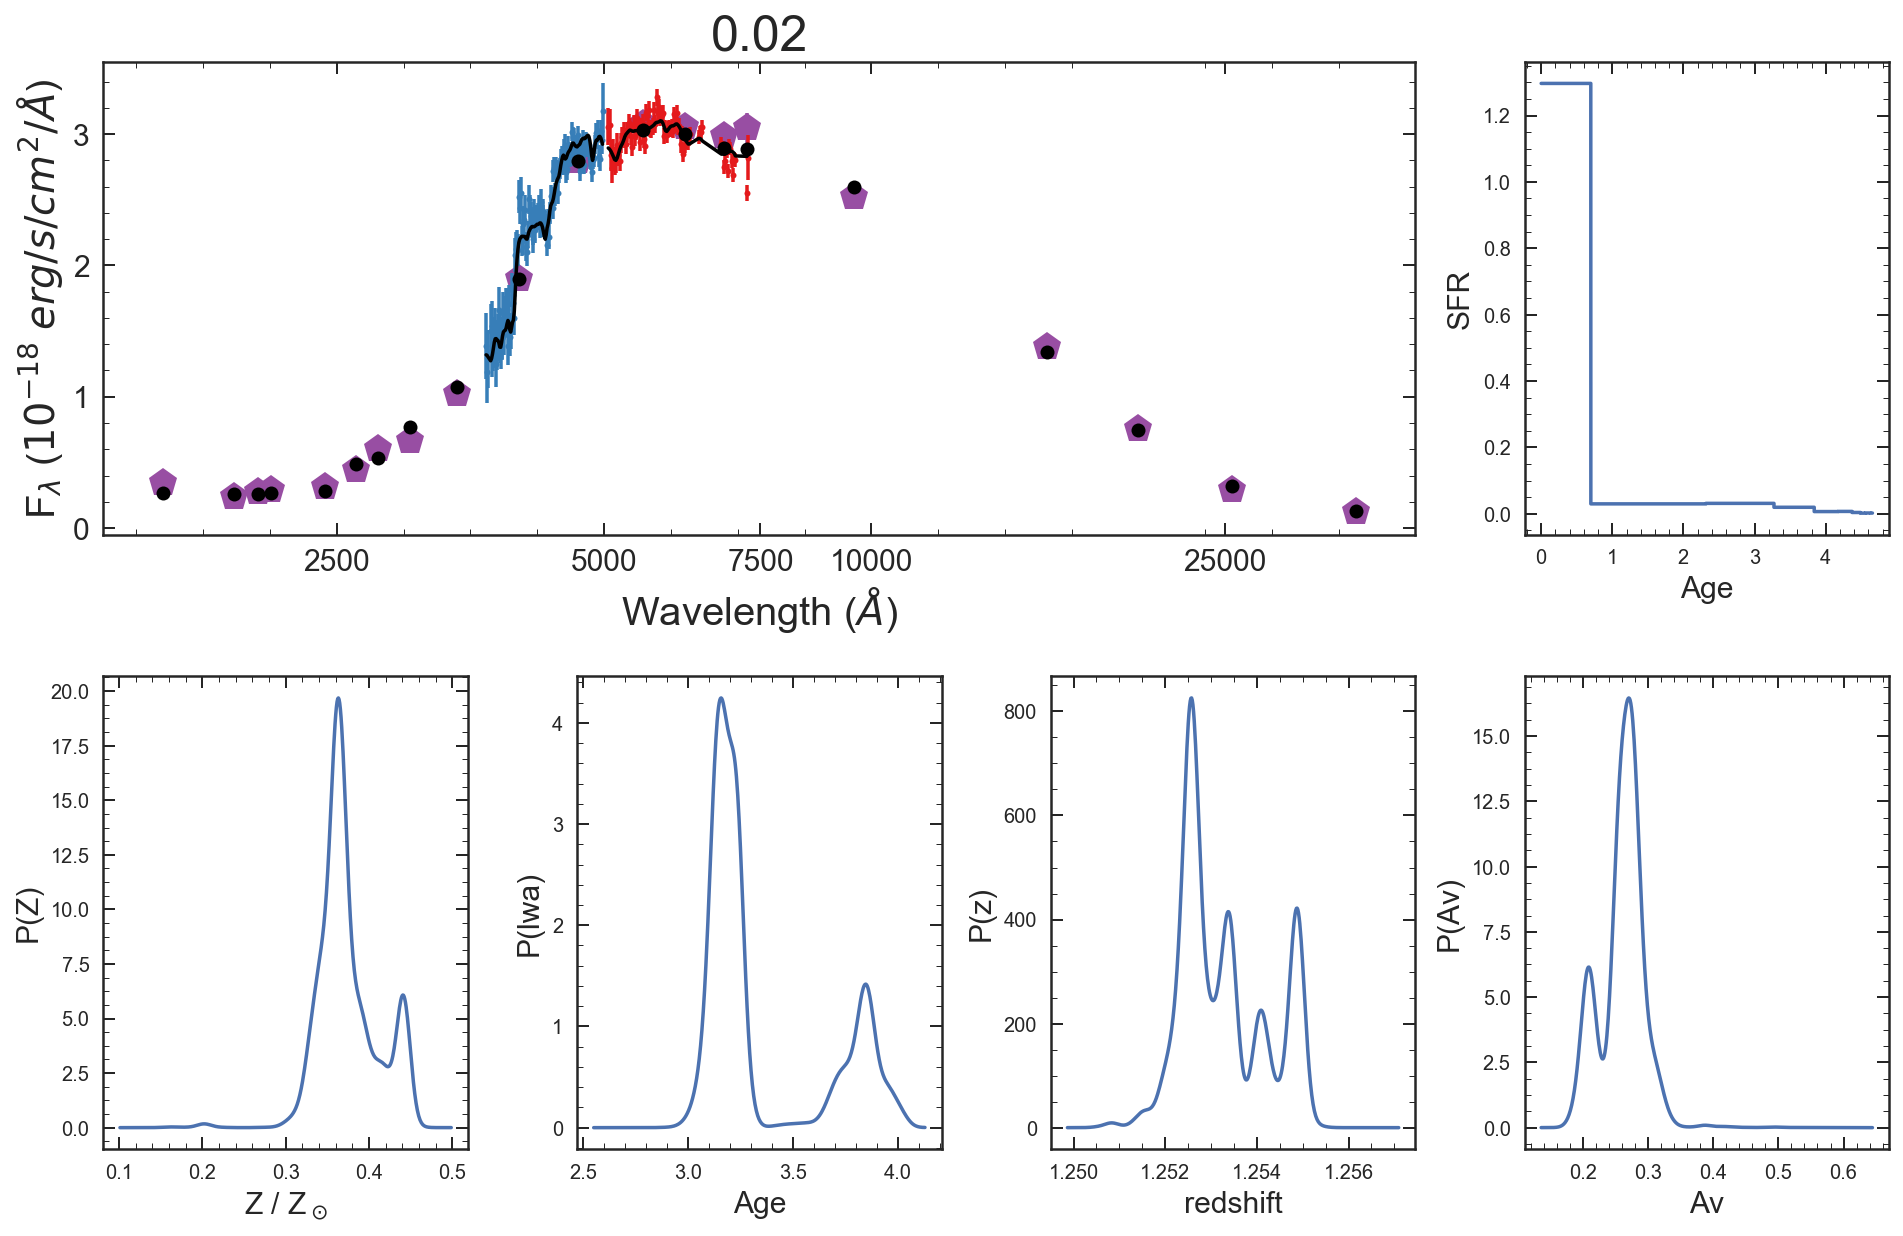

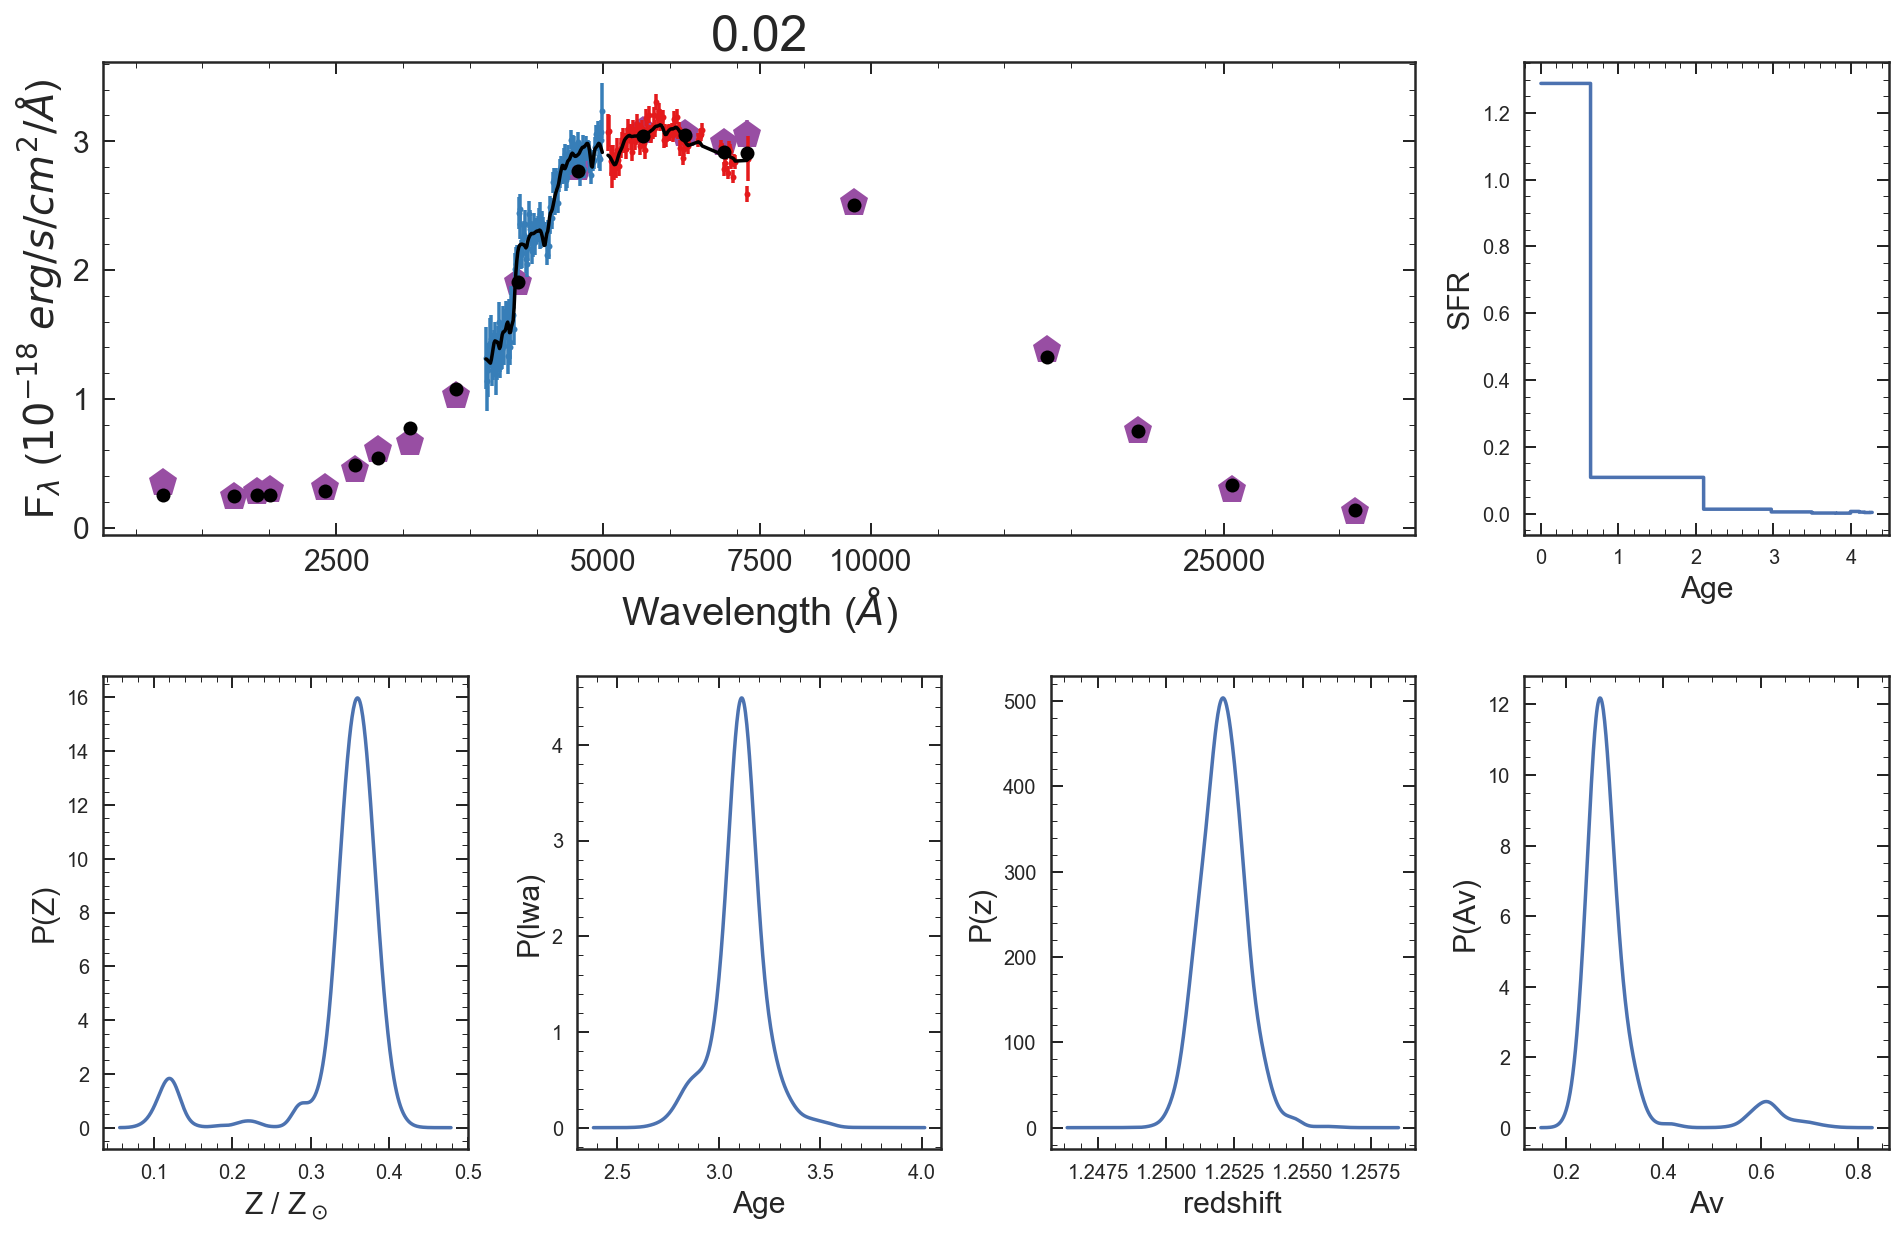

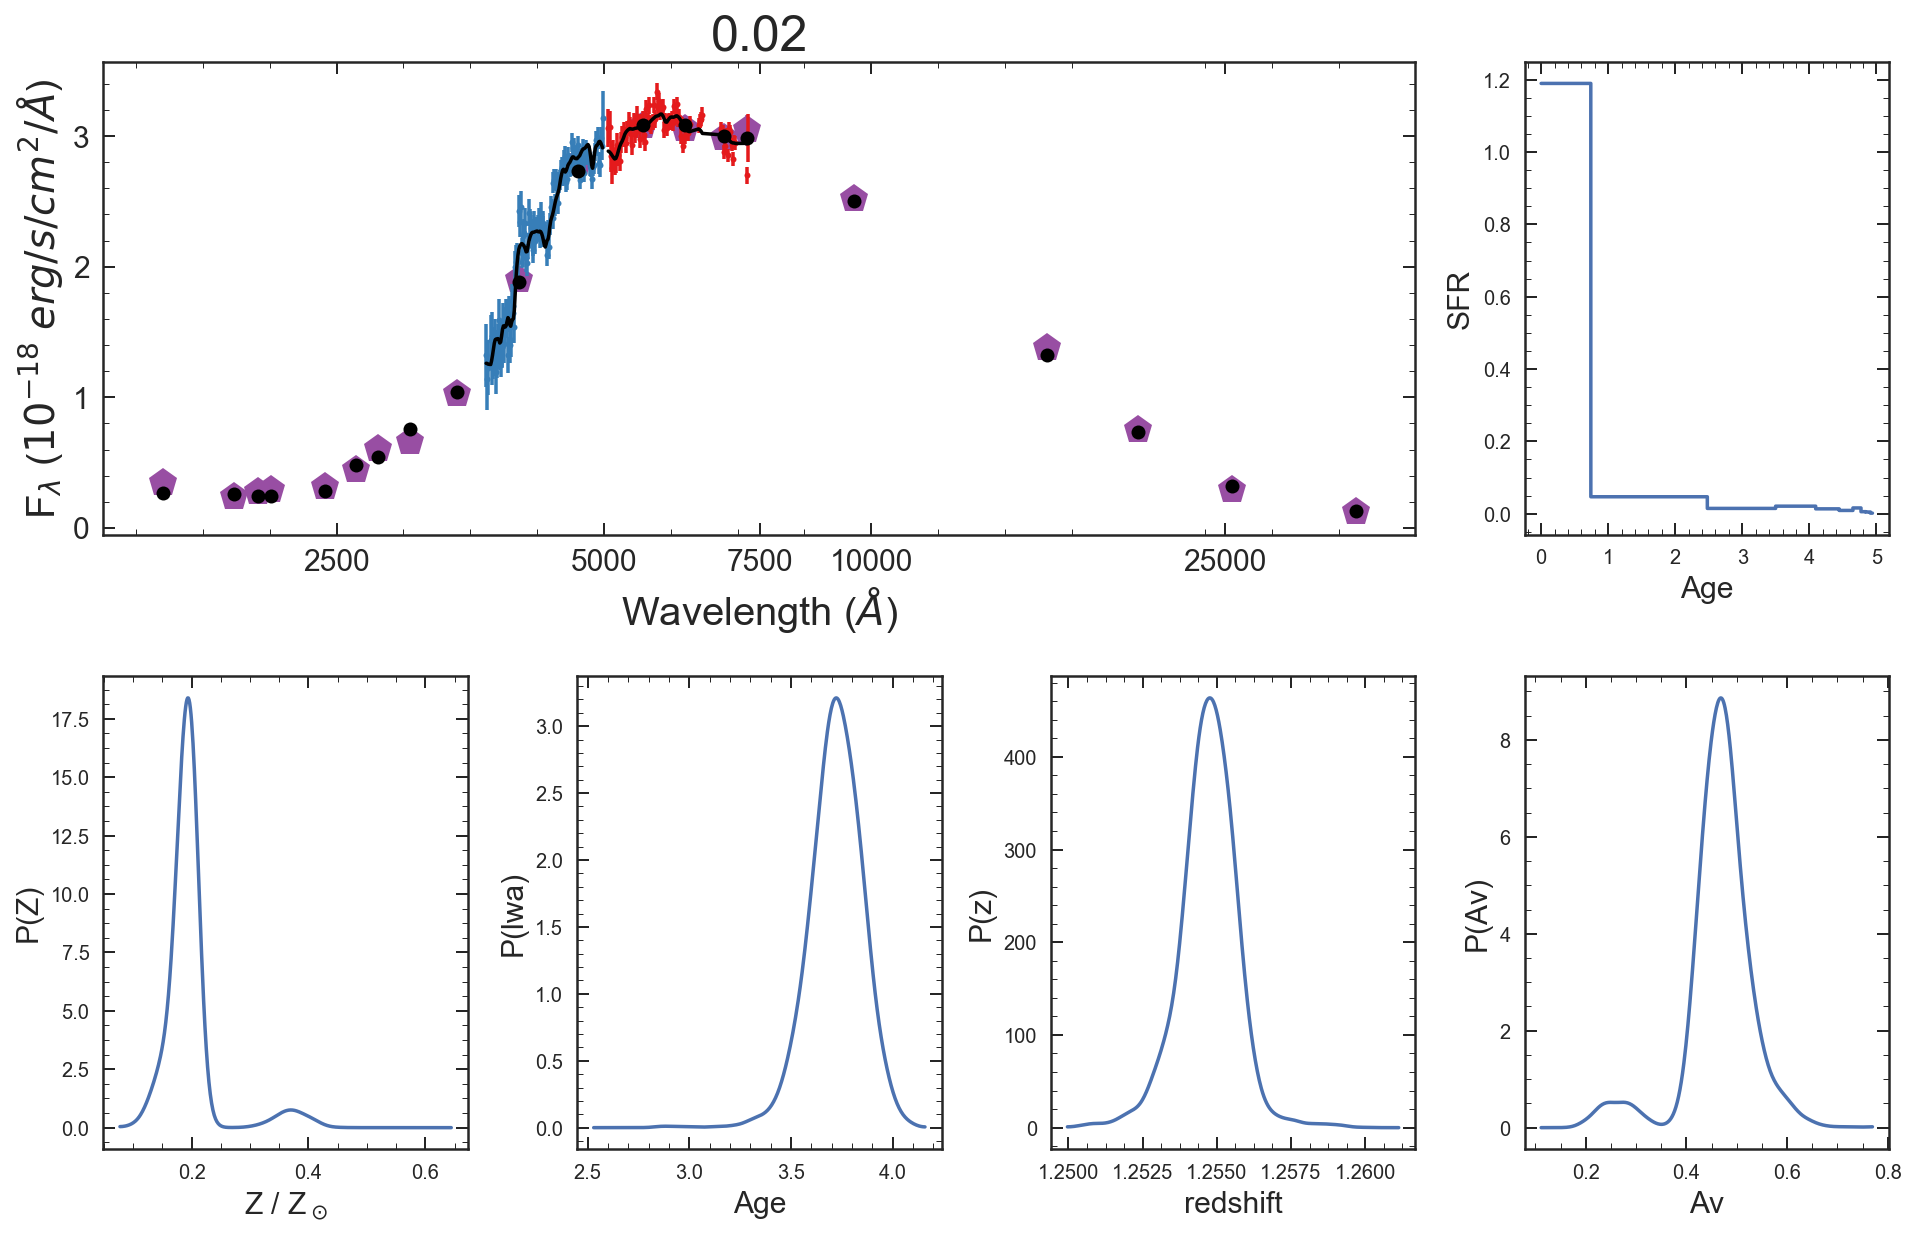

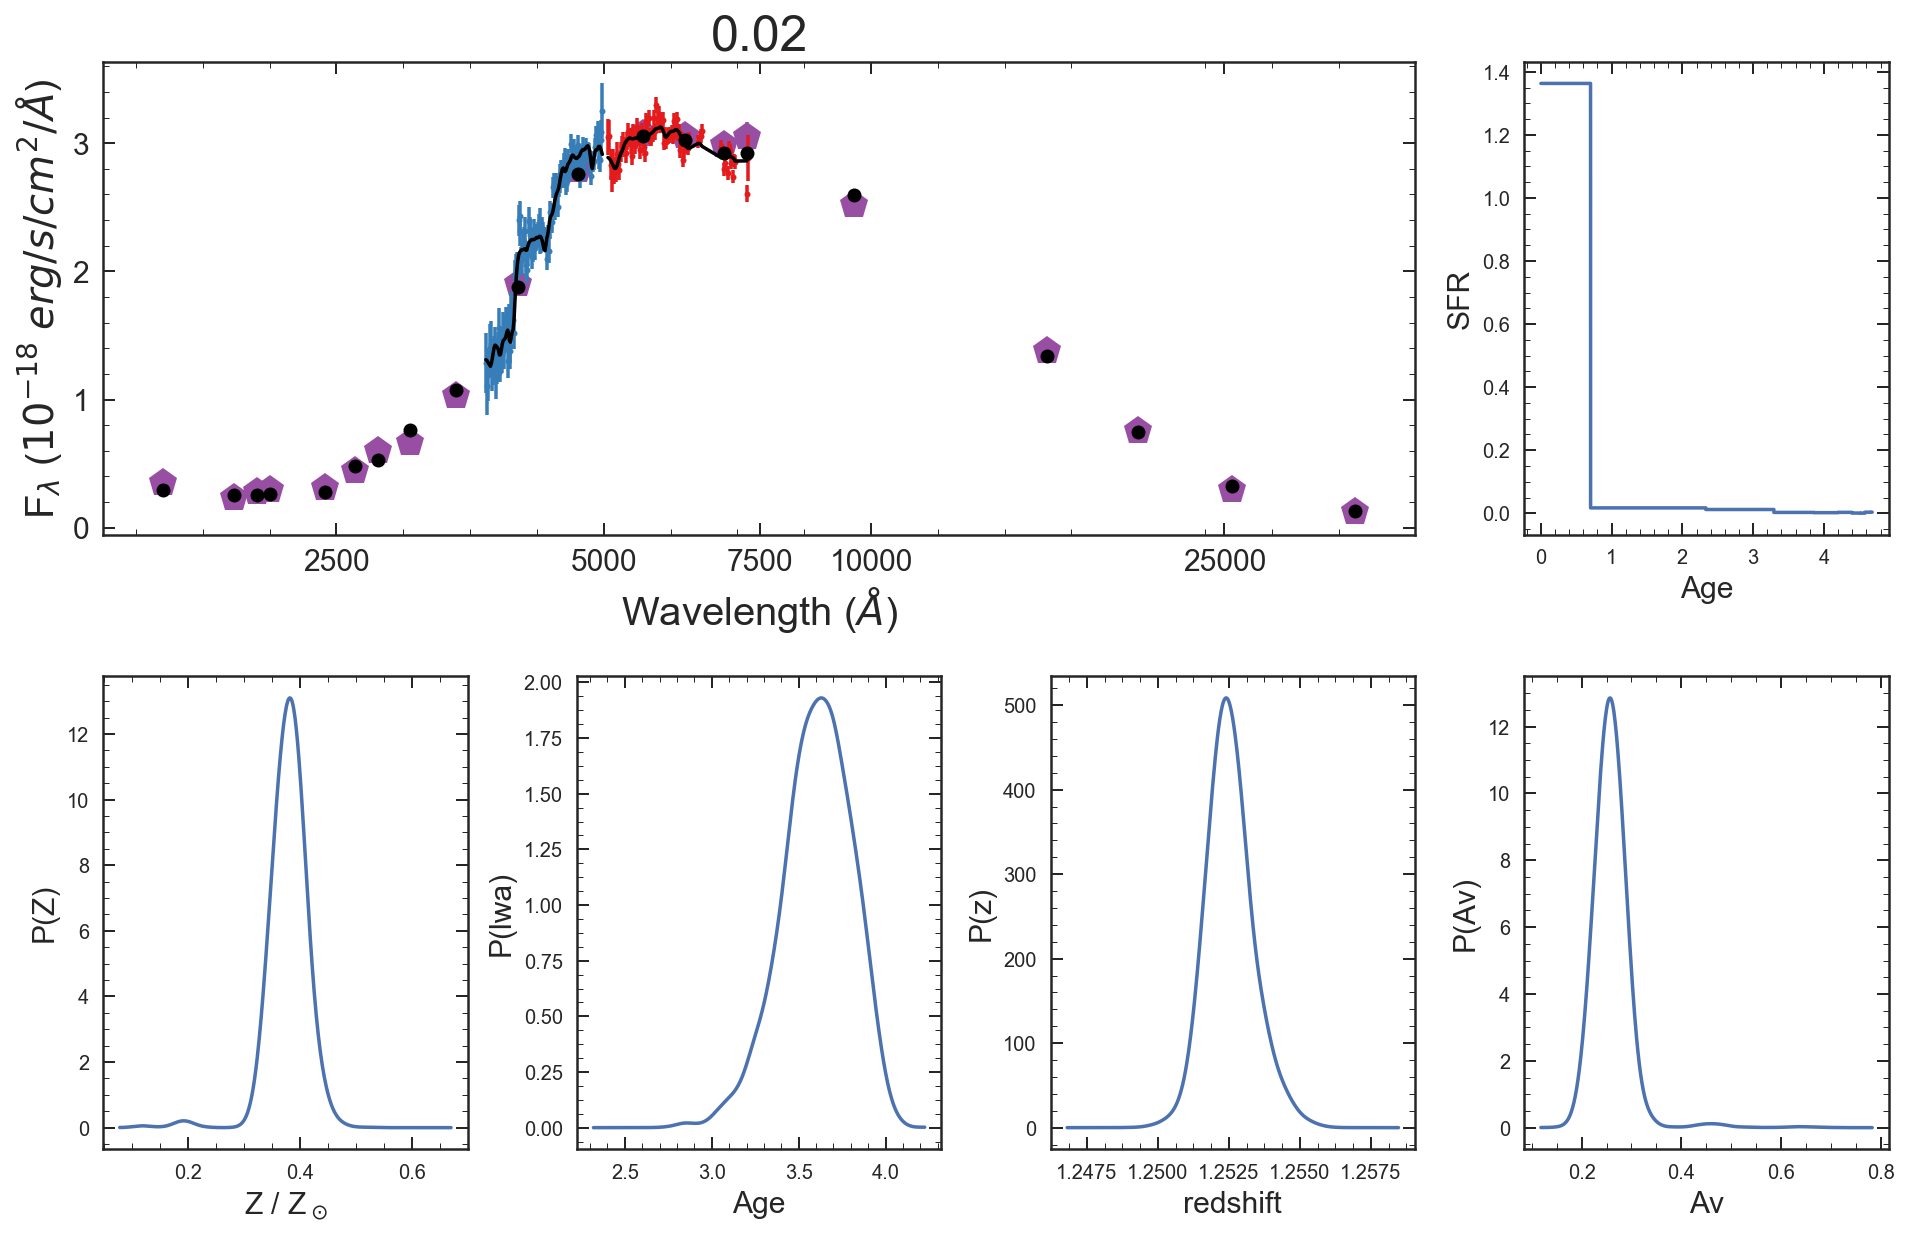

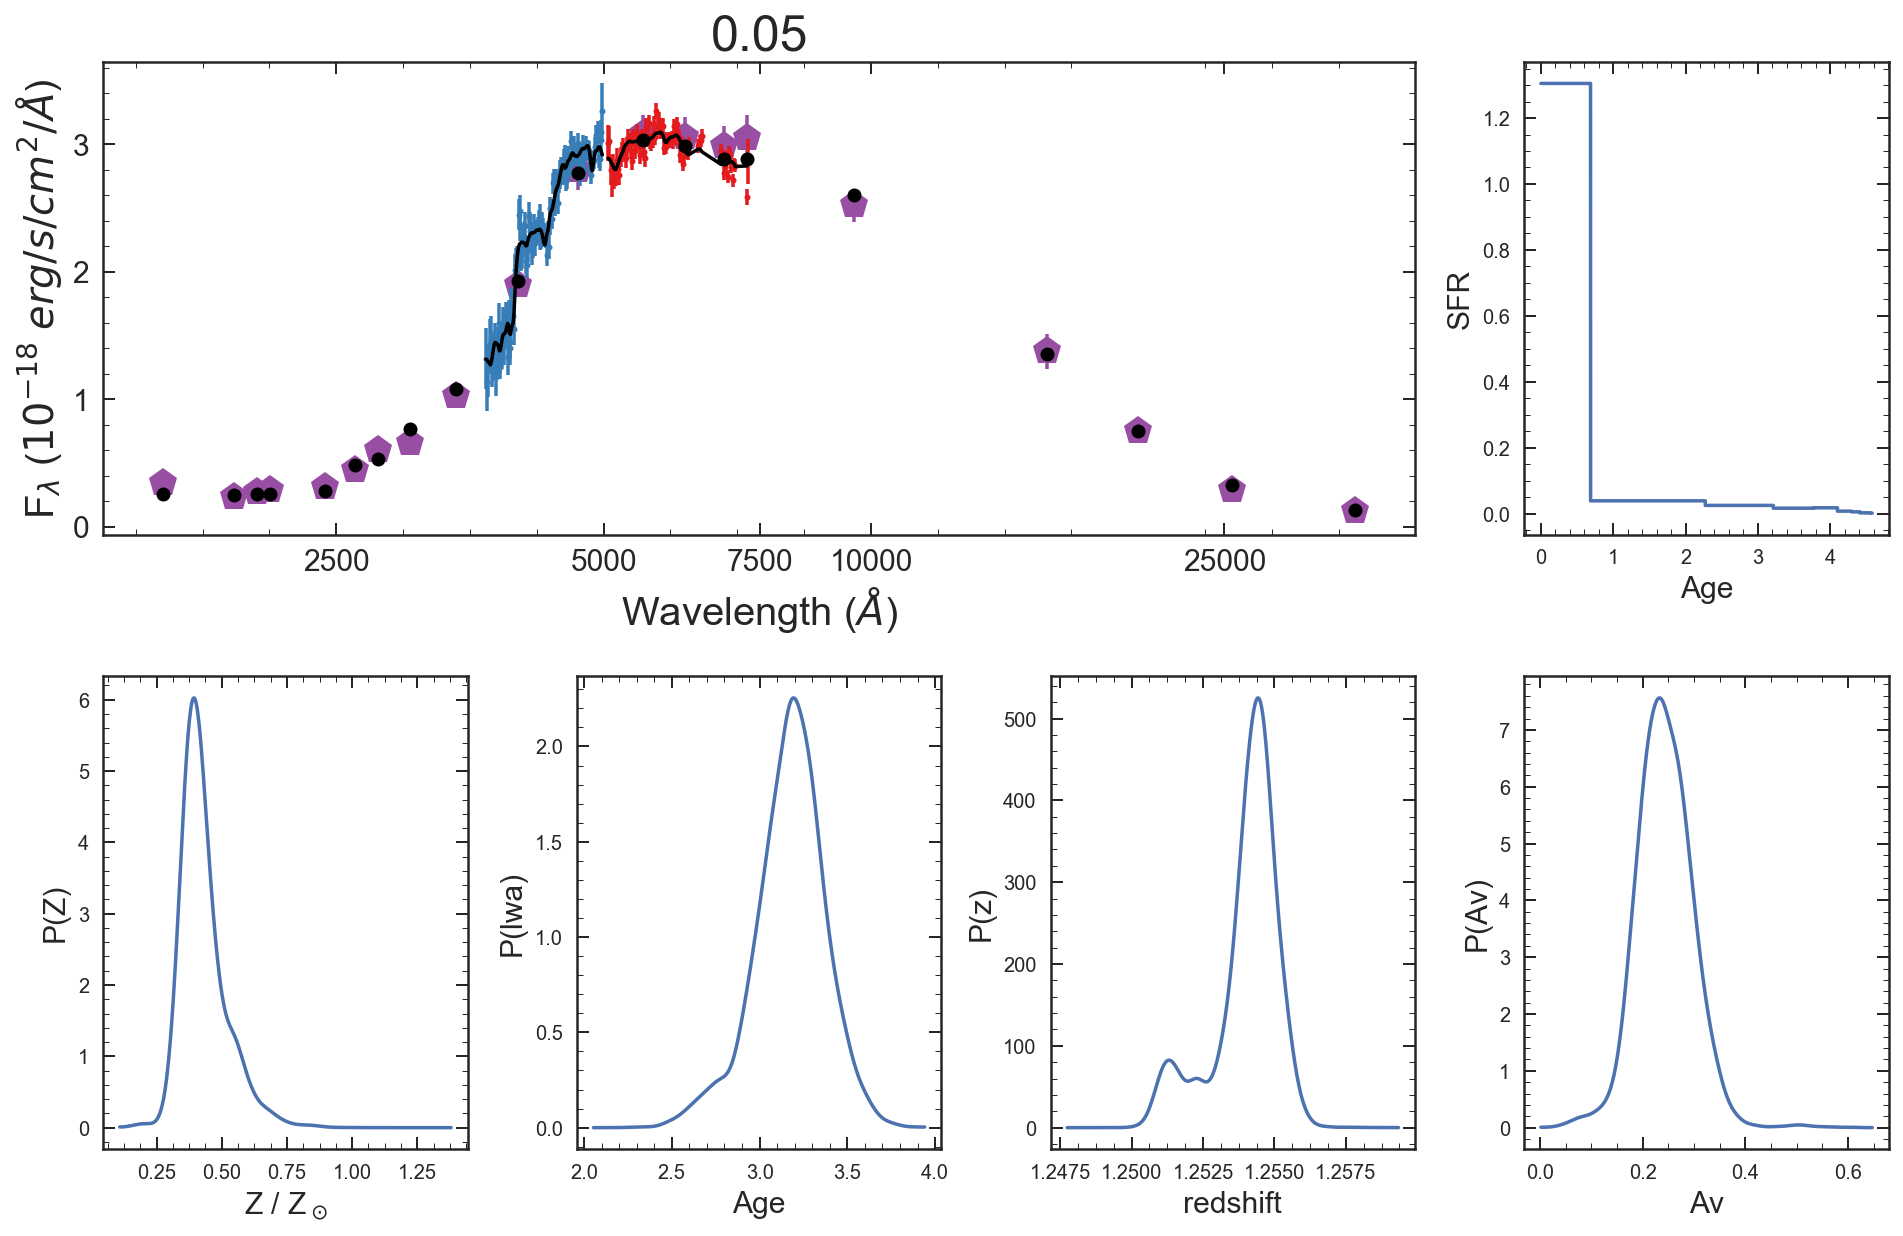

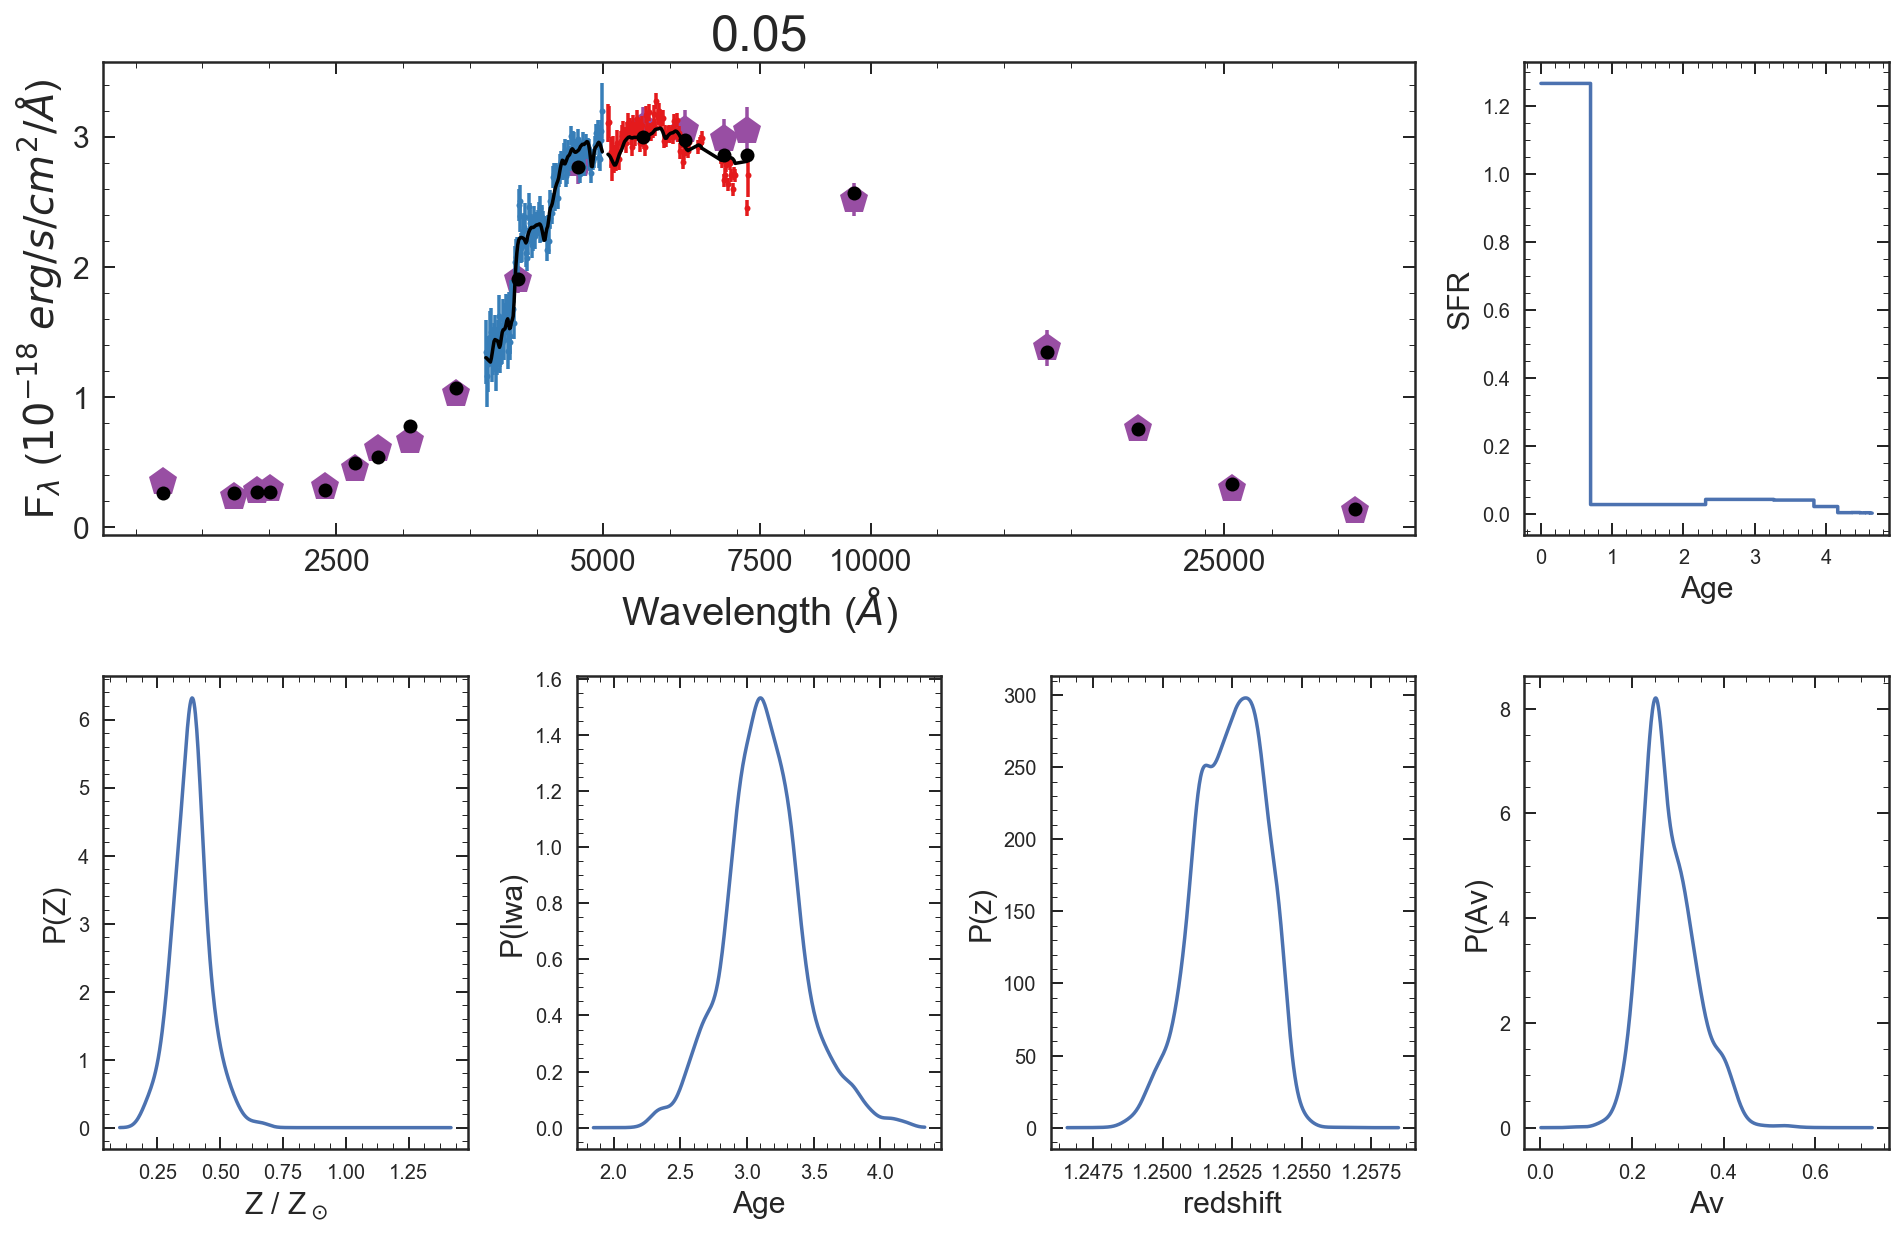

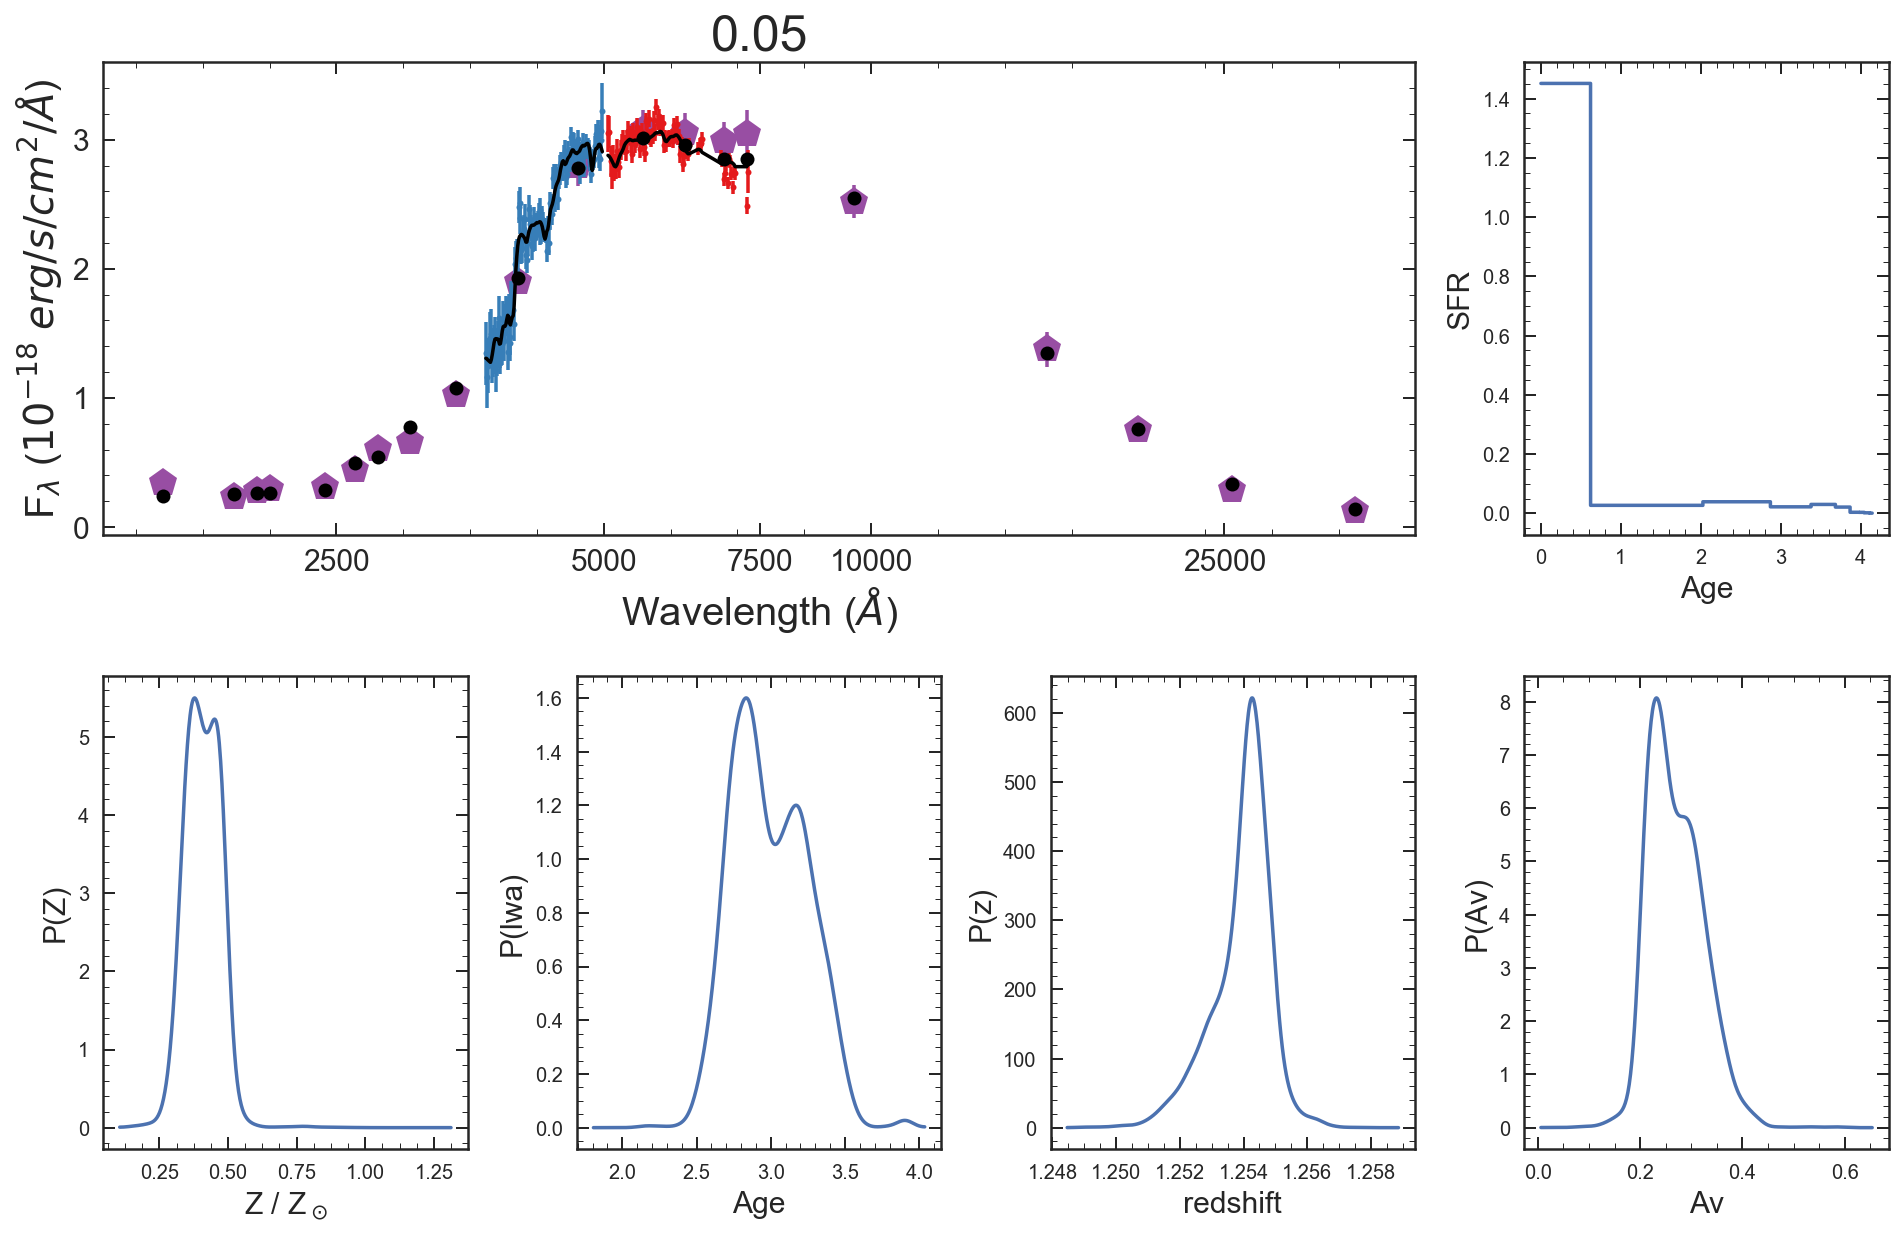

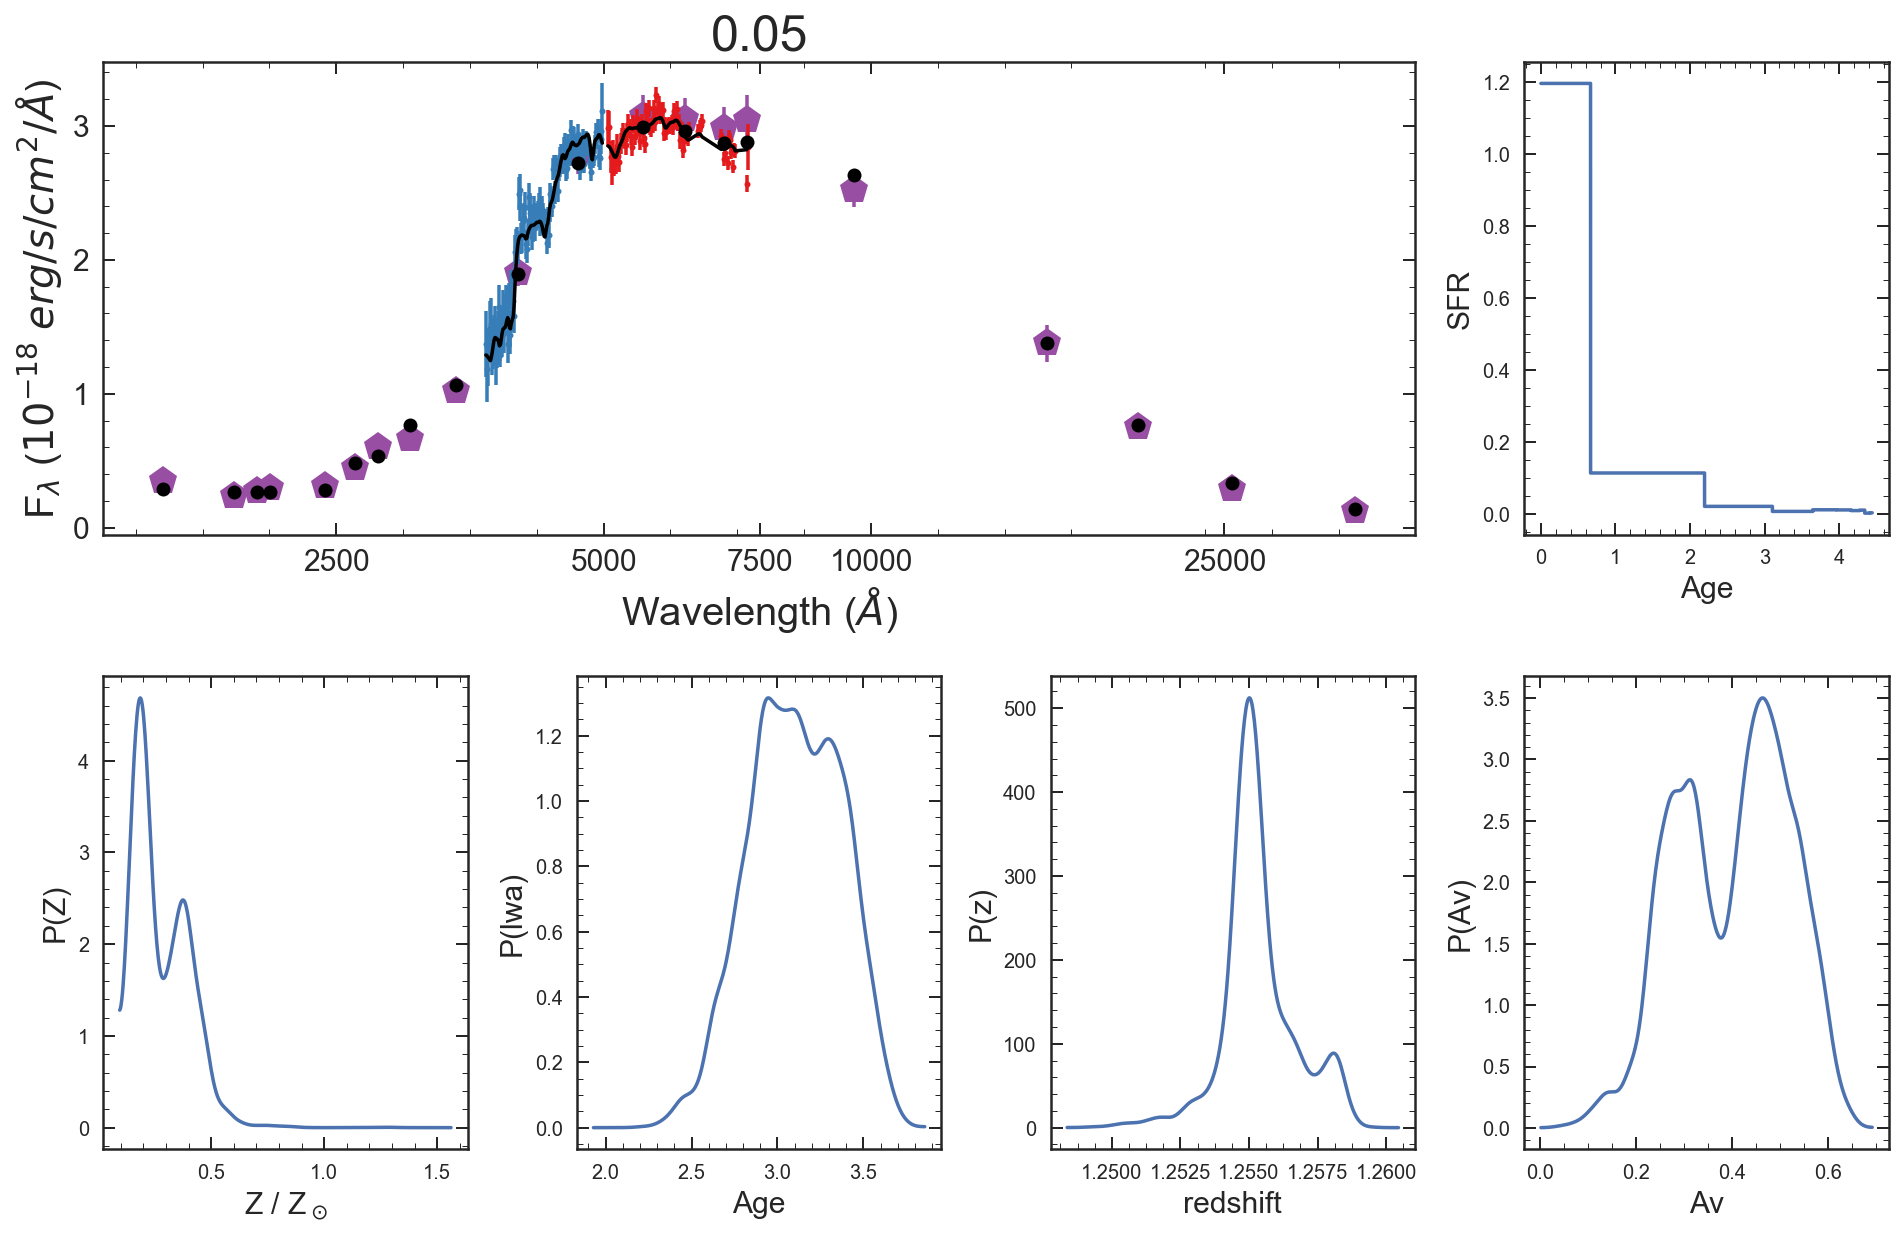

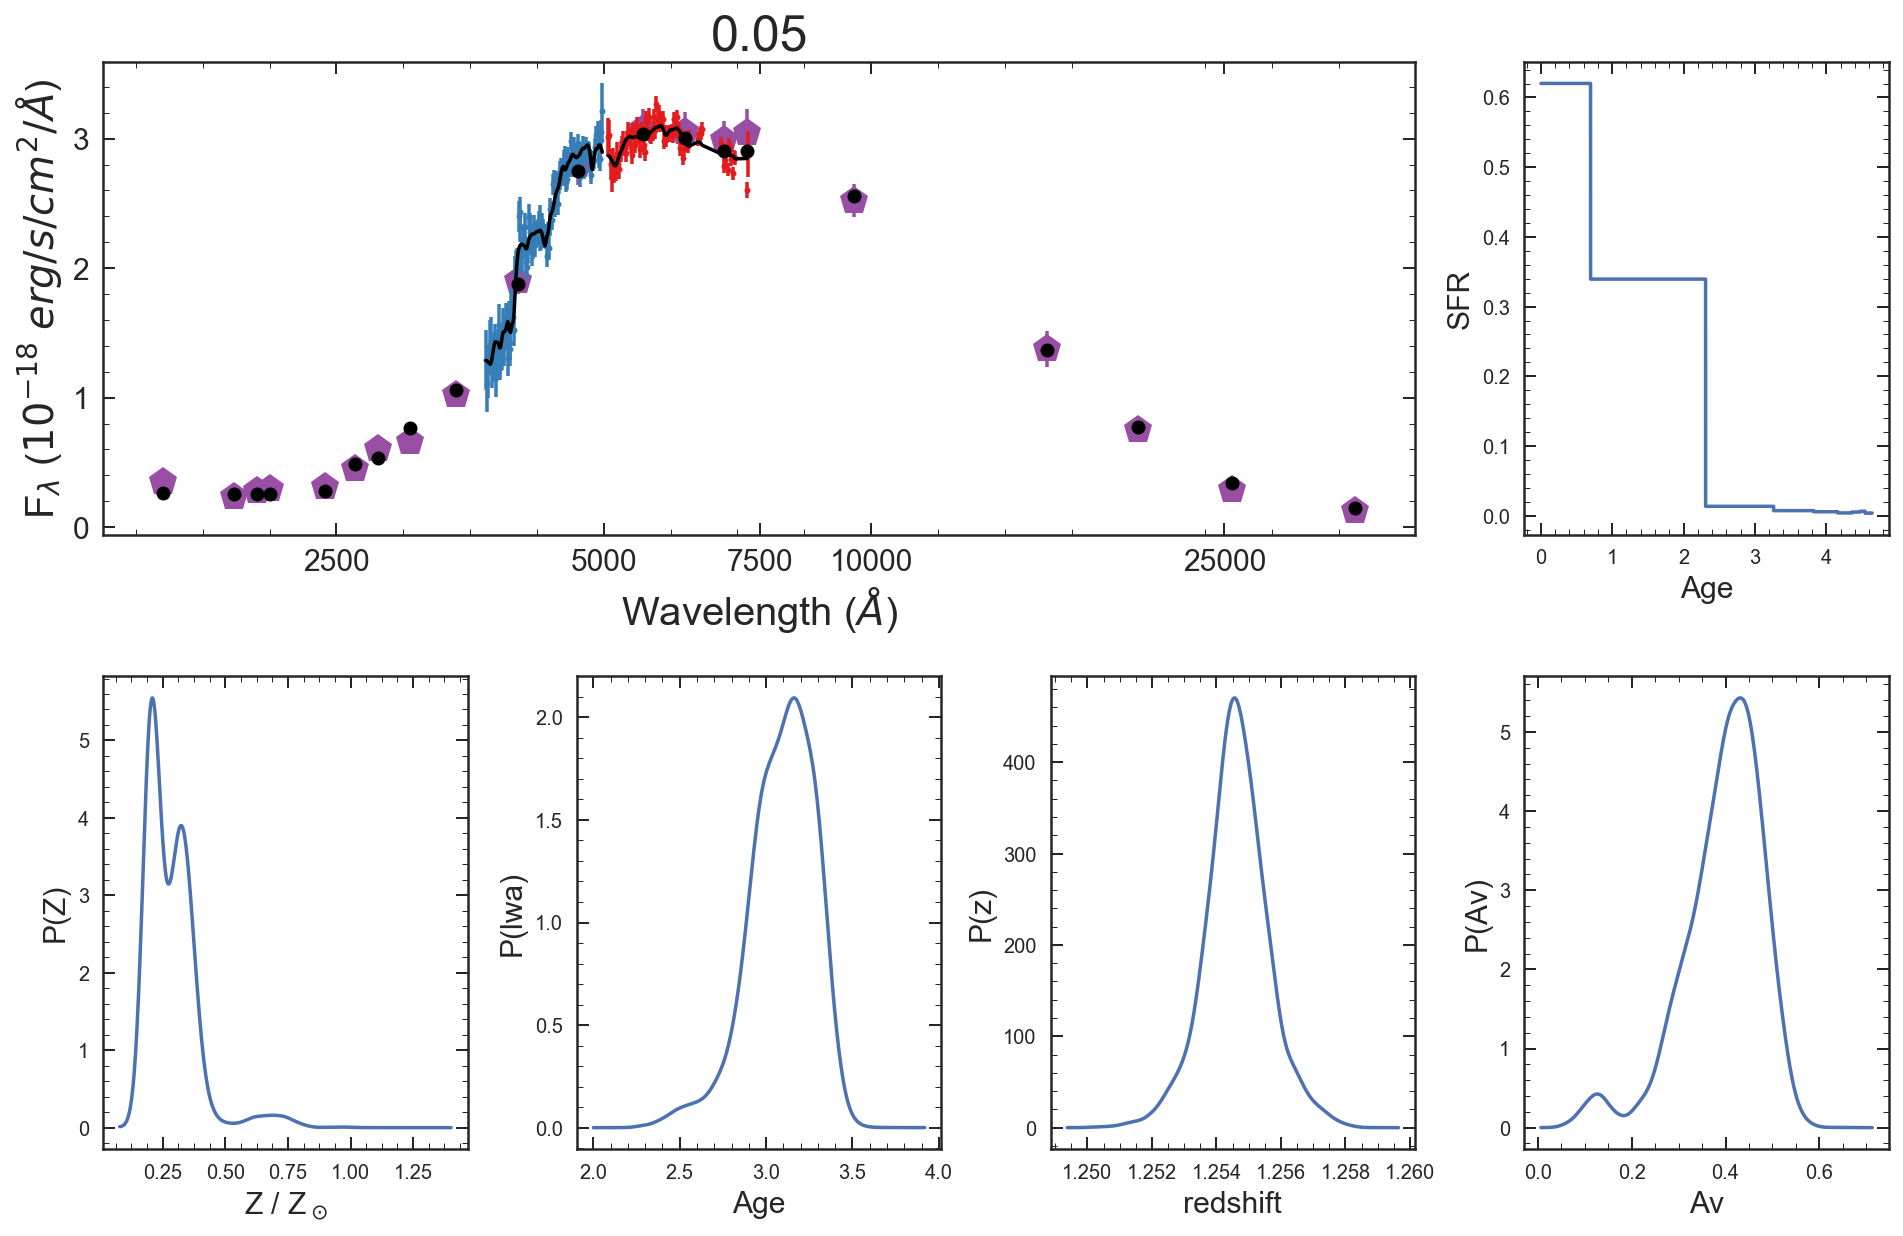

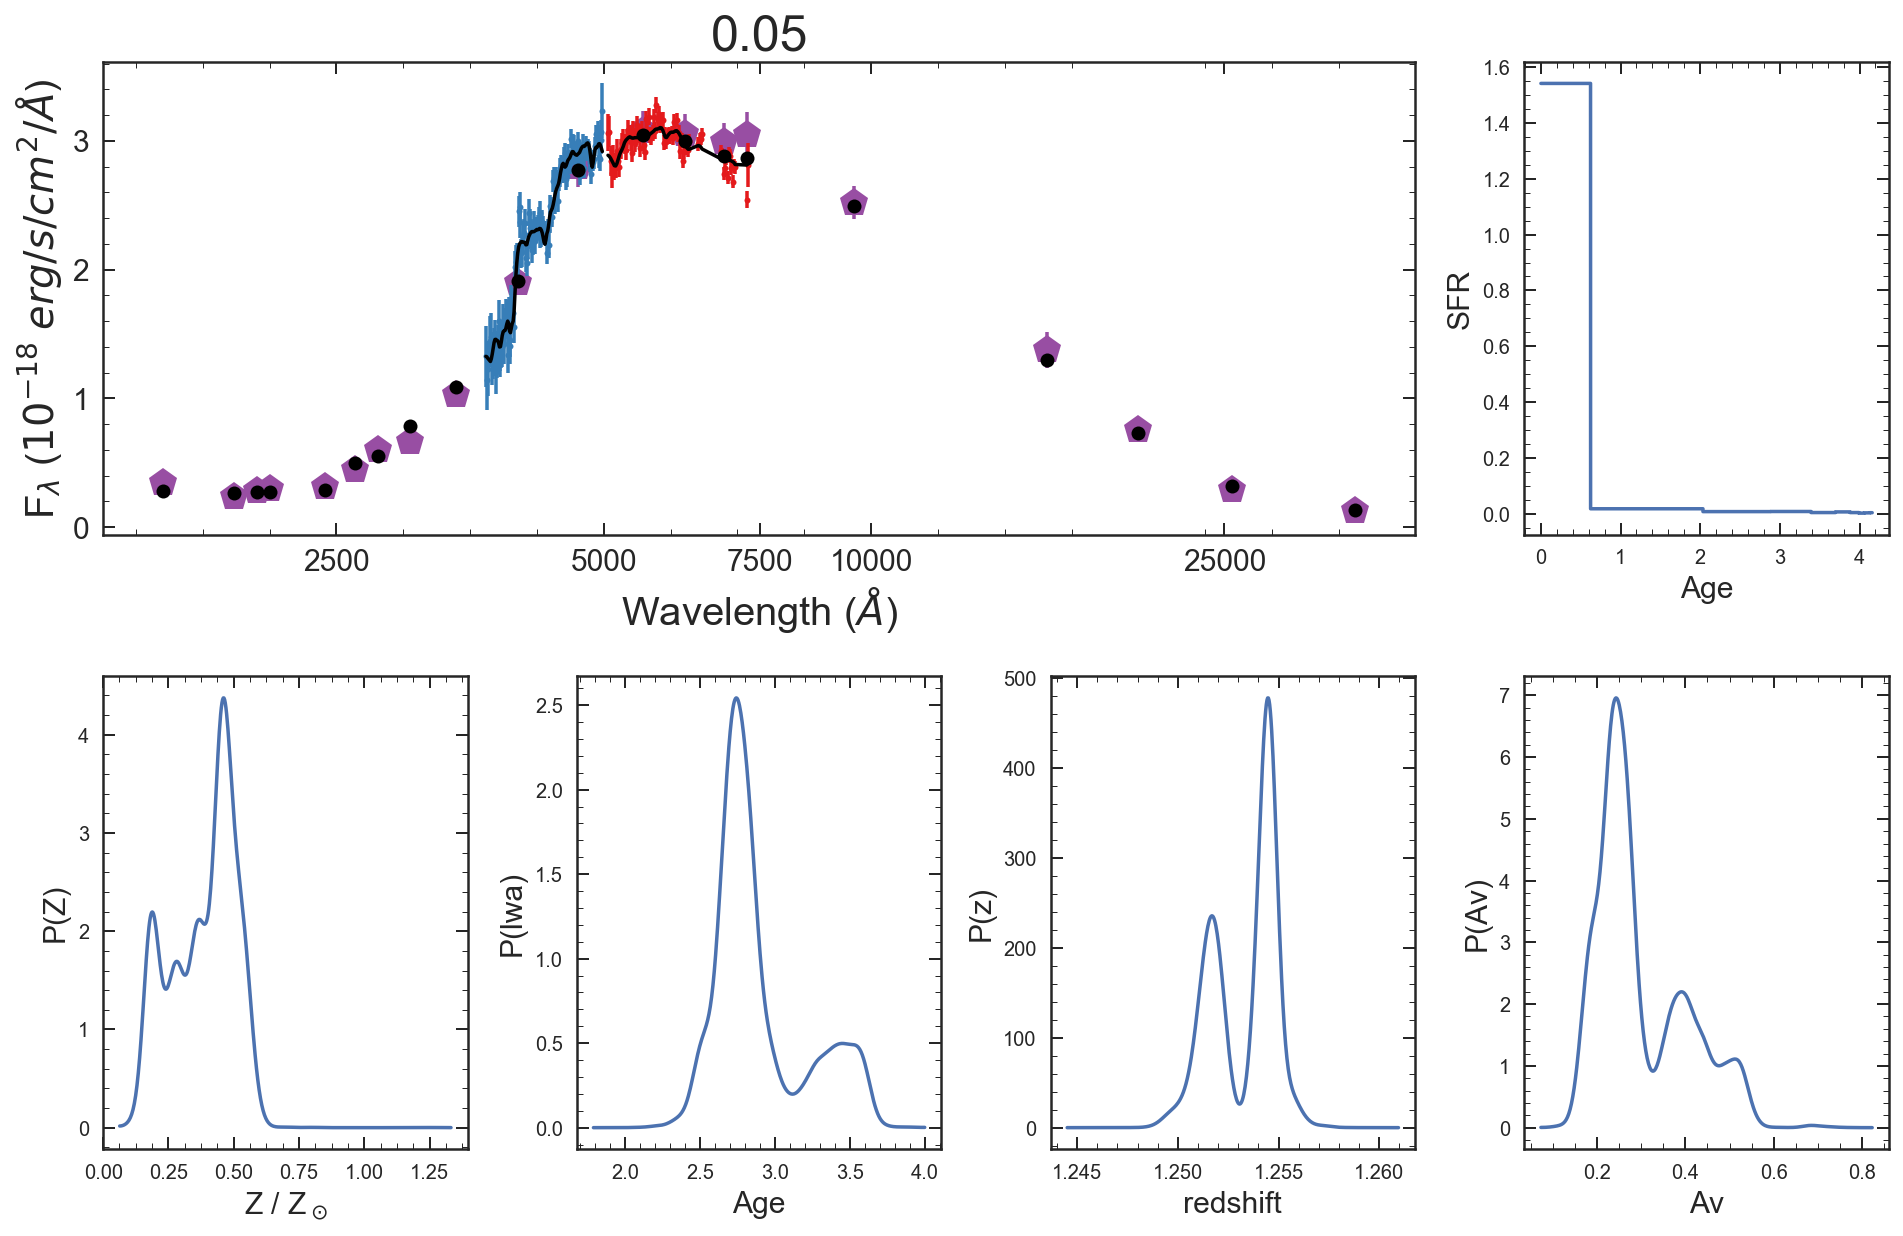

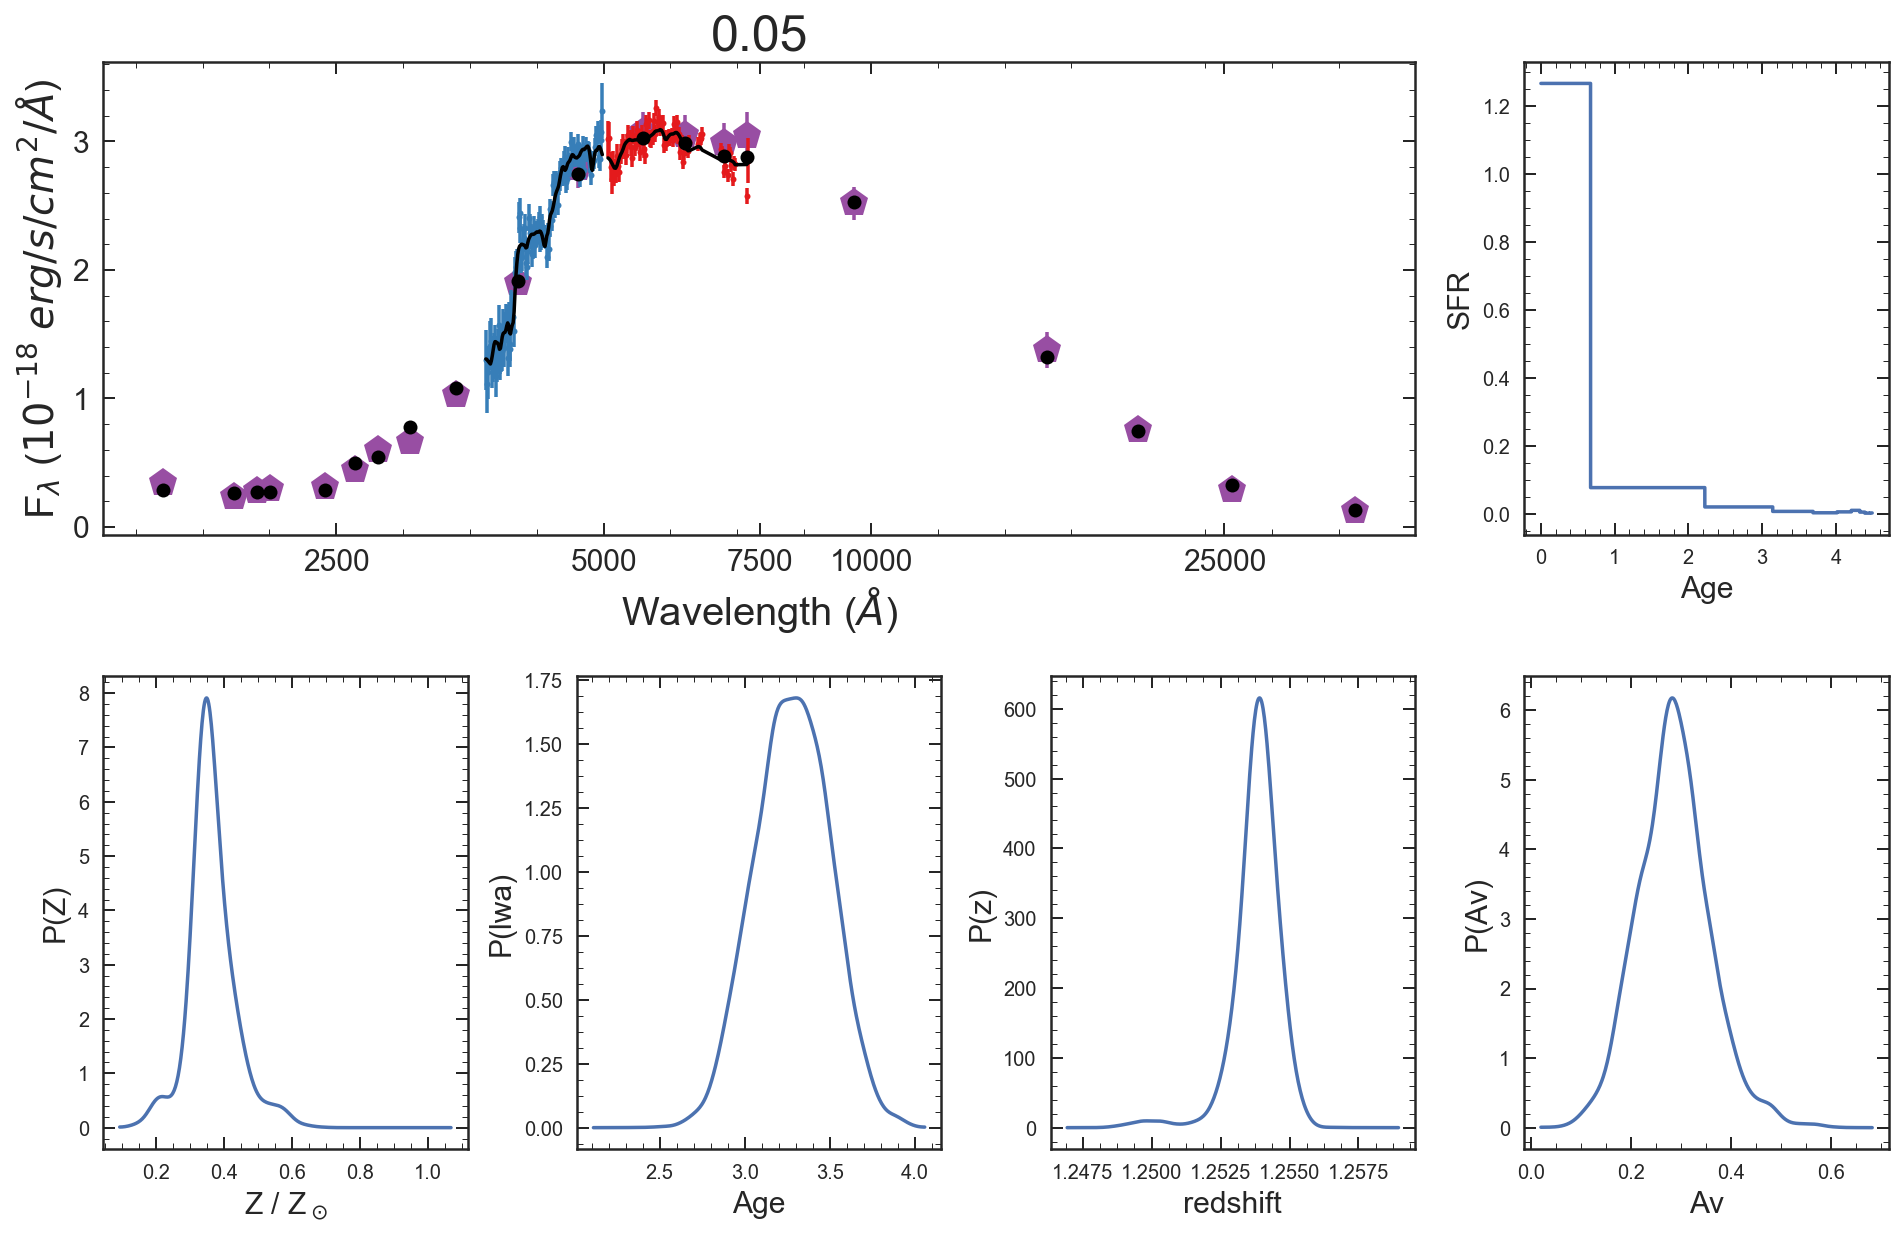

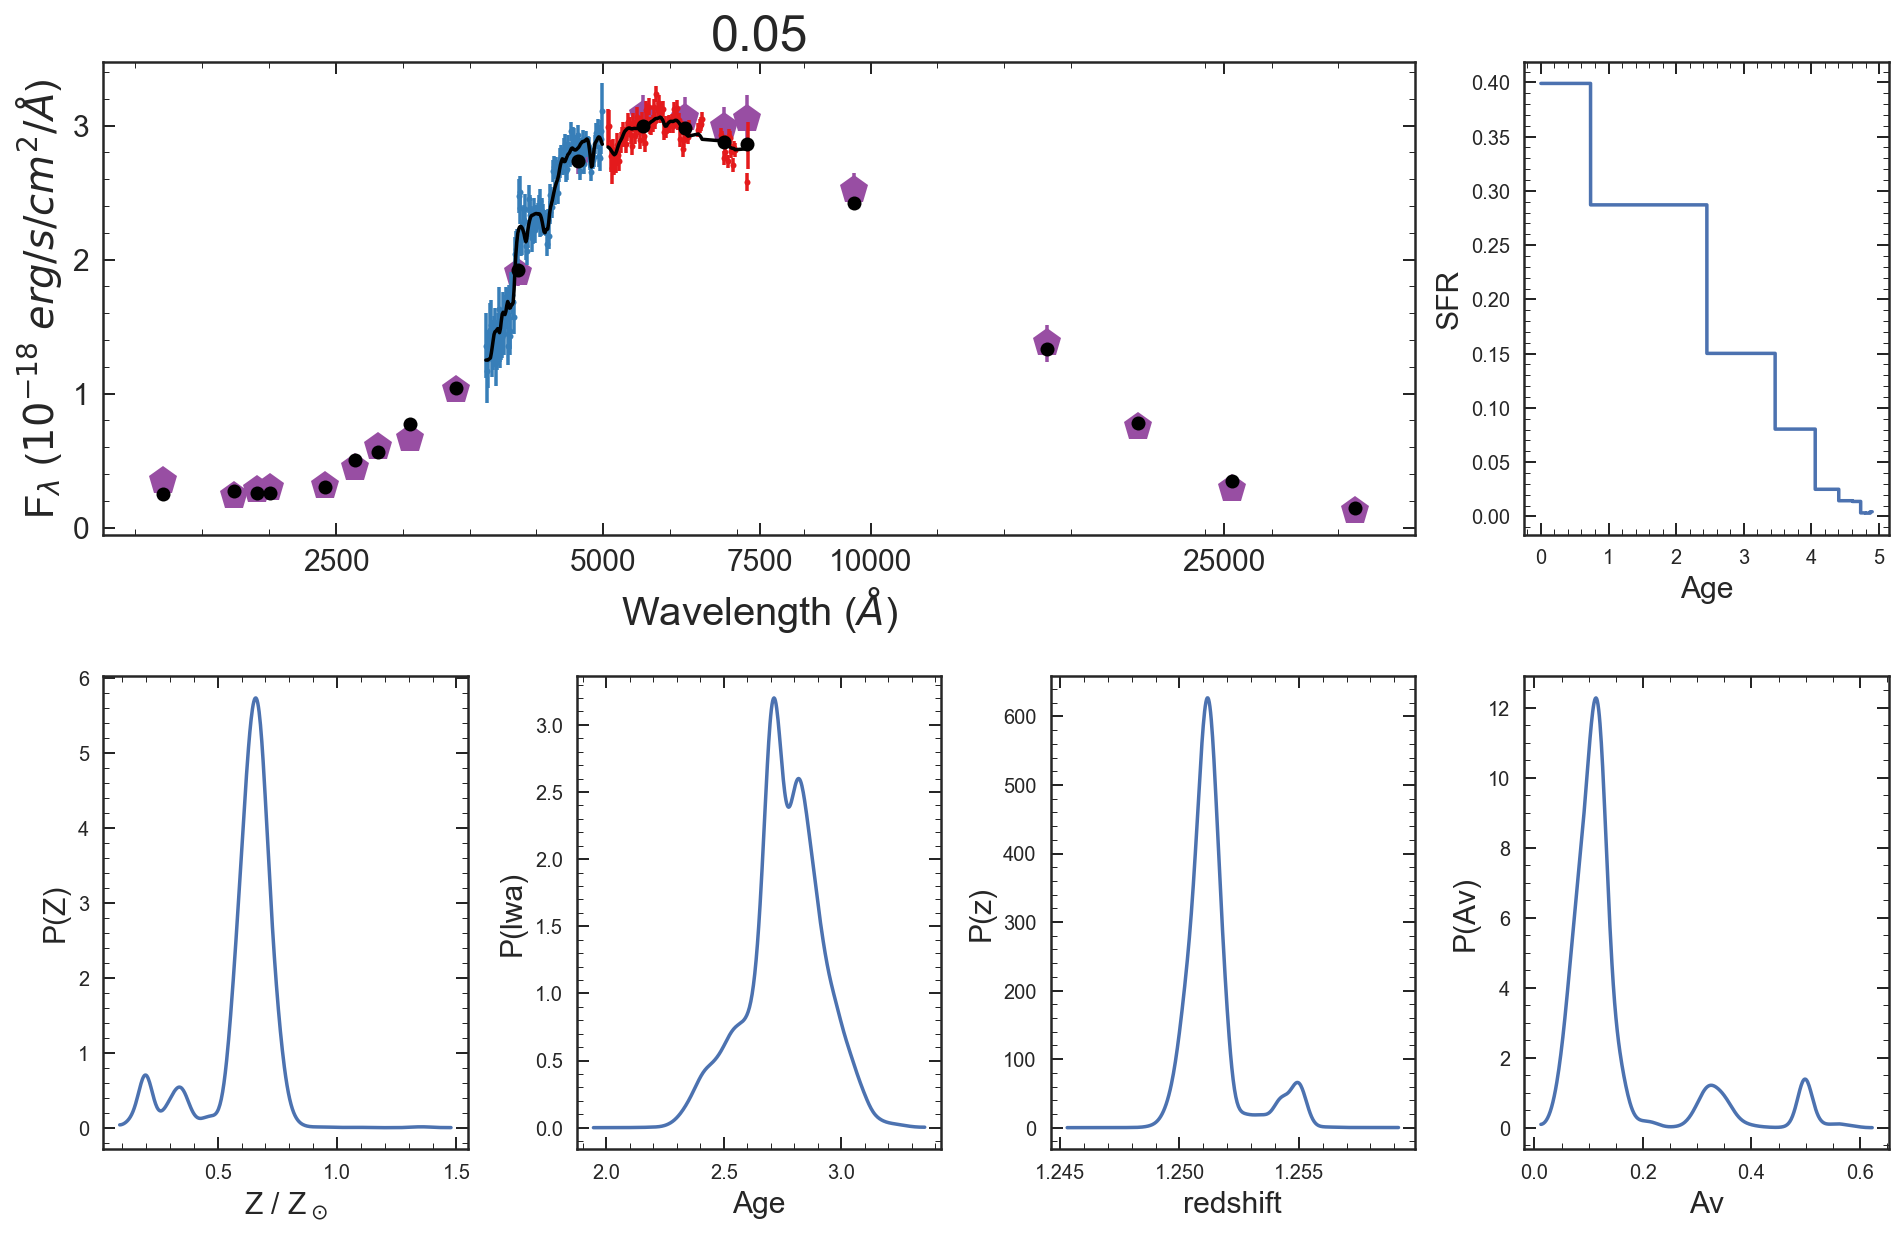

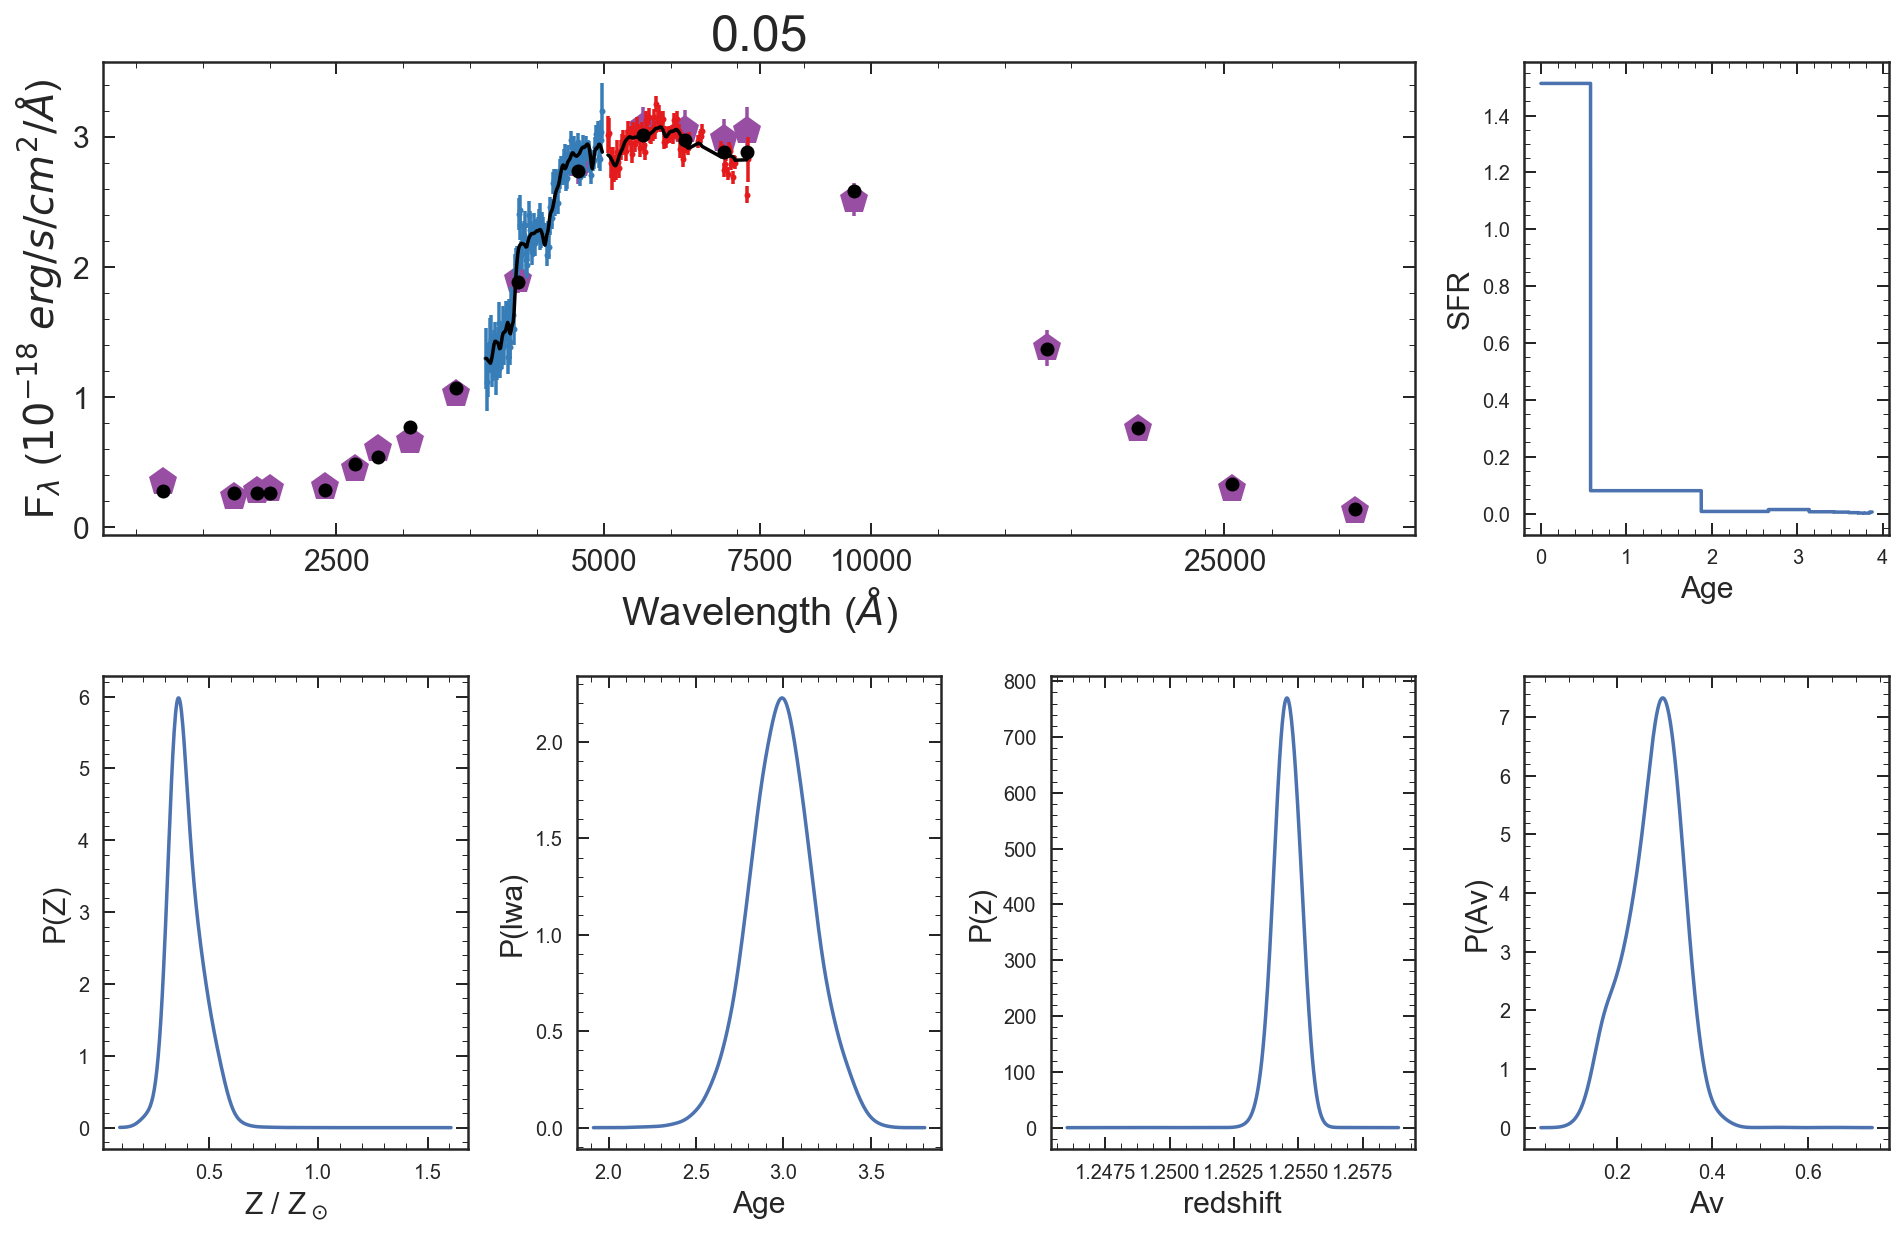

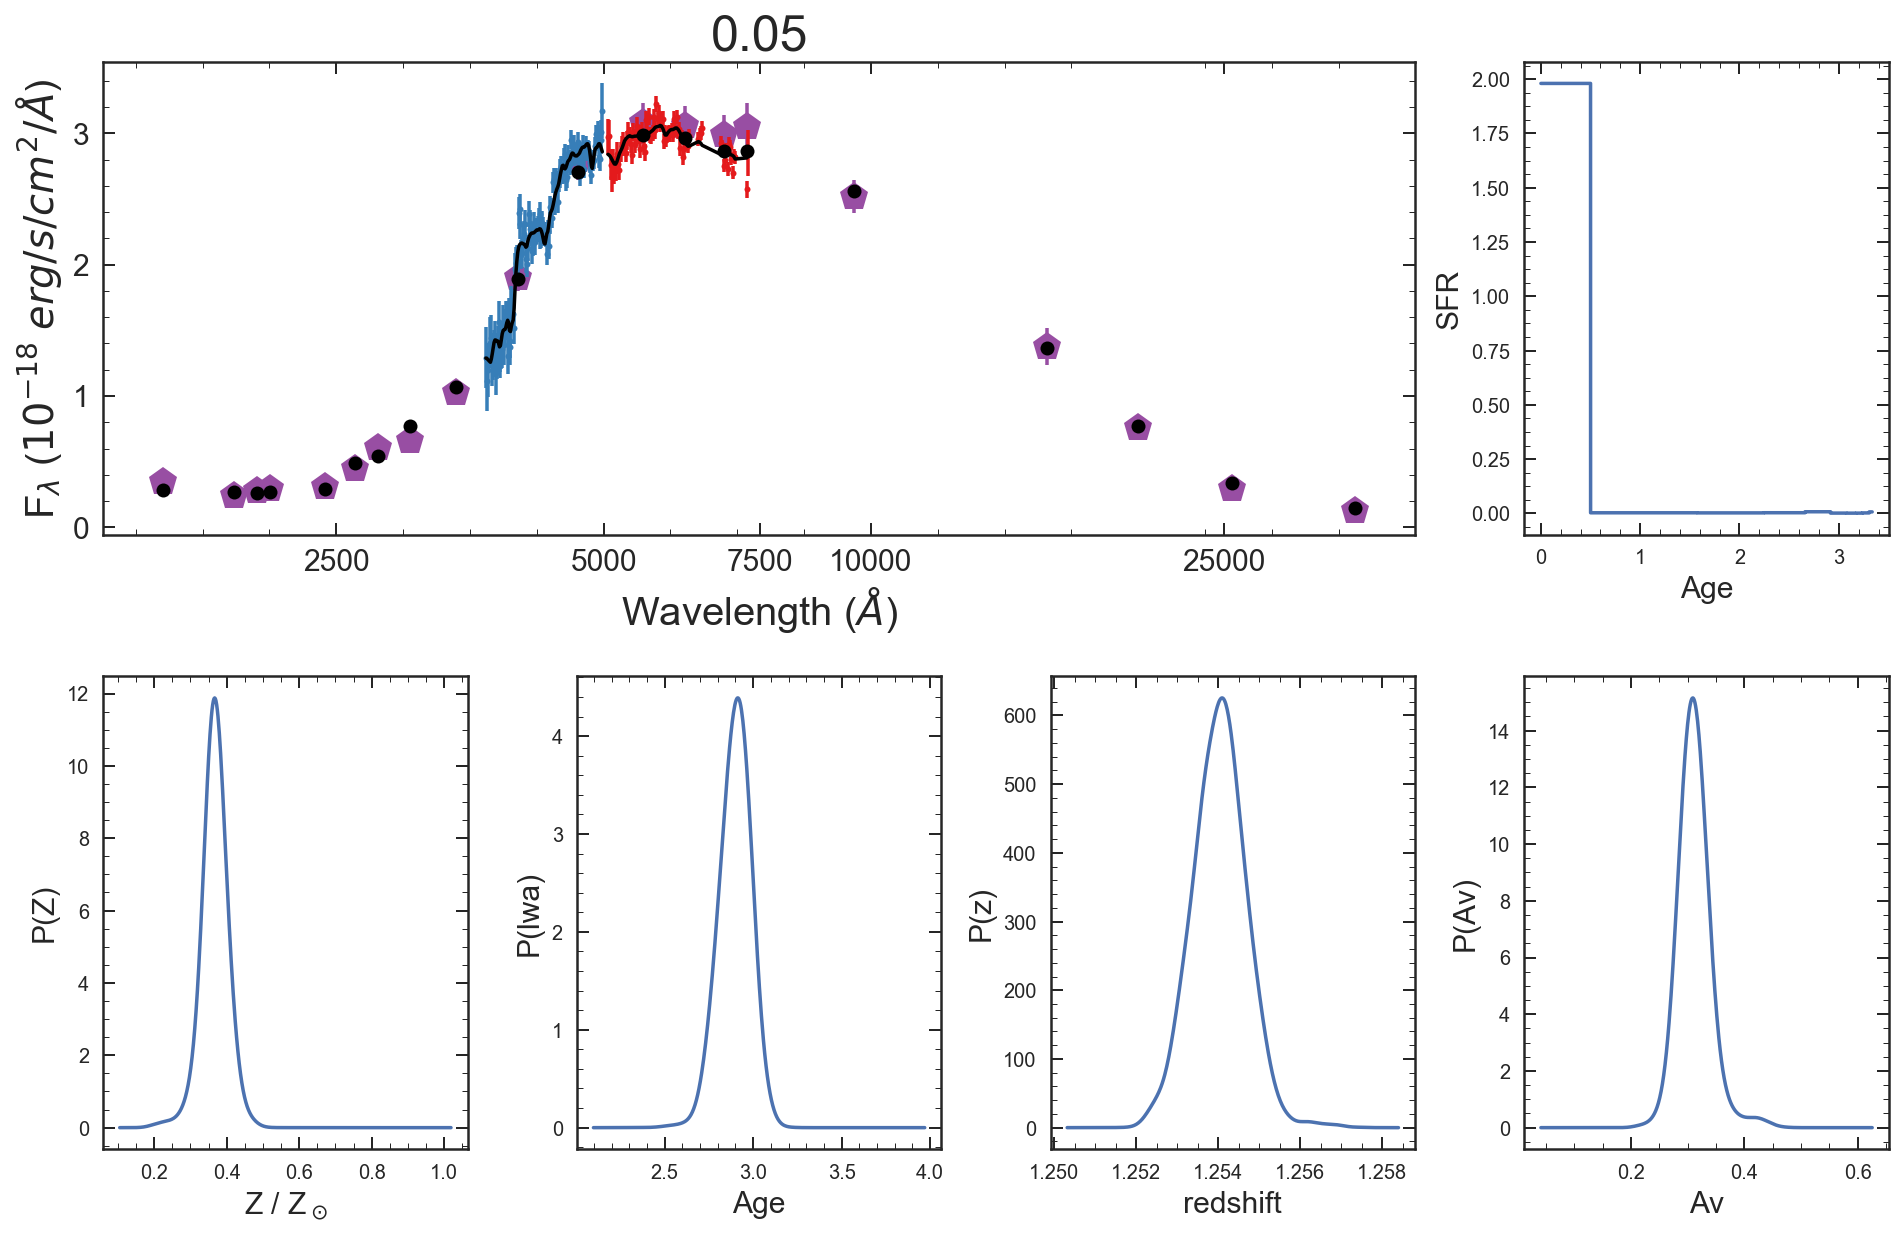

In [261]:
for i in range(30):
    if i // 10 == 0:
        errterm = 0
    if i // 10 == 1:
        errterm = 0.02
    if i // 10 == 2:
        errterm = 0.05
        
    PLOT(i+1,errterm,savefig=True)